<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

In [1]:
"""from google.colab import drive
drive.mount('/content/gdrive/')

!pip install -q condacolab
import condacolab
condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')\n\n!pip install -q condacolab\nimport condacolab\ncondacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=1, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=5, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=70, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=70, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=40, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex999_channel_seeds_PGM1_v2_debug.pth'

#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW100Seed_22channels.pth'


print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=batches)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


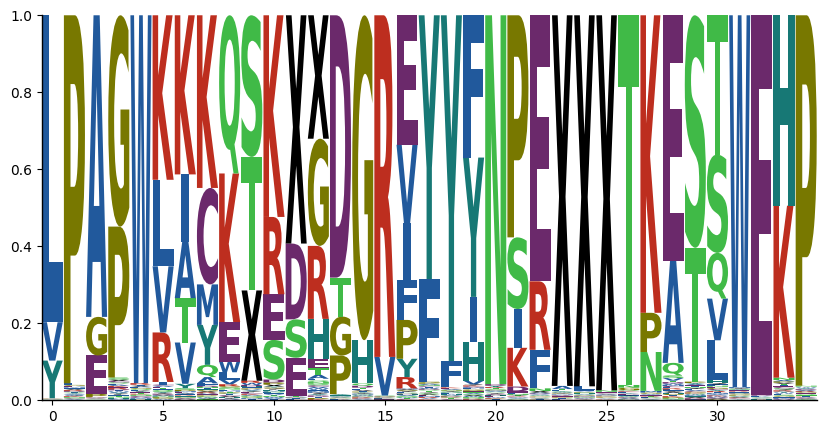

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq,500, 1, logdir=logdir, out_modelname=outmodel_name )
    #check_parameter_historic = list(deepseq.parameters())
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()
        
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS                
                optimizer.step()

                
                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-15,15] ) #[15,15]

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)#, weight_decay=1e-5)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1000, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # in iter 500 crash

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Number of training points:  10


Epoch 1/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)
Epoch 1/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00,  8.94samples/s]

Epoch 1/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00,  8.94samples/s, loss=506.65057373046875]

Epoch 1/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00, 10.04samples/s, loss=506.65057373046875]

Epoch 1/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00, 10.04samples/s, loss=514.2228393554688]

Epoch 1/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.98samples/s, loss=514.2228393554688]

Epoch 2/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]

Epoch 2/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.36samples/s]

Epoch 2/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.36samples/s, loss=487.77667236328125]

Epoch 2/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=487.77667236328125]

Epoch 2/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=518.6184692382812]

Epoch 2/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=518.6184692382812]

Epoch 3/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]

Epoch 3/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.38samples/s]

Epoch 3/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.38samples/s, loss=481.071533203125]

Epoch 3/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=481.071533203125]

Epoch 3/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=515.6796264648438]

Epoch 3/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=515.6796264648438]

Epoch 4/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]

Epoch 4/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.46samples/s]

Epoch 4/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=491.1144104003906]

Epoch 4/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=491.1144104003906]

Epoch 4/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=514.0252685546875]

Epoch 4/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=514.0252685546875]

Epoch 5/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]

Epoch 5/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 5/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=490.3840026855469]

Epoch 5/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=490.3840026855469]

Epoch 5/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=513.6383666992188]

Epoch 5/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=513.6383666992188]

Epoch 6/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]

Epoch 6/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 6/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=482.8222961425781]

Epoch 6/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=482.8222961425781]

Epoch 6/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=514.6387939453125]

Epoch 6/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=514.6387939453125]

Epoch 7/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]

Epoch 7/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.45samples/s]

Epoch 7/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=477.73602294921875]

Epoch 7/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=477.73602294921875]

Epoch 7/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=513.939208984375]

Epoch 7/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.03samples/s, loss=513.939208984375]

Epoch 8/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]

Epoch 8/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.44samples/s]

Epoch 8/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=492.9467468261719]

Epoch 8/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=492.9467468261719]

Epoch 8/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=511.7219543457031]

Epoch 8/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=511.7219543457031]

Epoch 9/1000:   0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]

Epoch 9/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [00:00<00:00, 14.40samples/s]

Epoch 9/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.40samples/s, loss=481.6908264160156]

Epoch 9/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=481.6908264160156]

Epoch 9/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=511.5643615722656]

Epoch 9/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=511.5643615722656]

Epoch 10/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 10/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.46samples/s]

Epoch 10/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=492.0706481933594]

Epoch 10/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=492.0706481933594]

Epoch 10/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=509.8530578613281]

Epoch 10/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=509.8530578613281]

Epoch 11/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 11/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.44samples/s]

Epoch 11/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=507.135009765625]

Epoch 11/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=507.135009765625]

Epoch 11/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=507.468505859375]

Epoch 11/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=507.468505859375]

Epoch 12/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 12/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 12/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=483.84344482421875]

Epoch 12/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=483.84344482421875]

Epoch 12/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=511.8572998046875]

Epoch 12/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=511.8572998046875]

Epoch 13/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 13/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 13/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=465.89056396484375]

Epoch 13/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=465.89056396484375]

Epoch 13/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=505.8727111816406]

Epoch 13/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=505.8727111816406]

Epoch 14/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 14/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 14/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=471.126220703125]

Epoch 14/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=471.126220703125]

Epoch 14/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=520.8265380859375]

Epoch 14/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=520.8265380859375]

Epoch 15/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 15/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.46samples/s]

Epoch 15/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=478.3189697265625]

Epoch 15/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=478.3189697265625]

Epoch 15/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=509.5554504394531]

Epoch 15/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=509.5554504394531]

Epoch 16/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 16/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.41samples/s]

Epoch 16/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.41samples/s, loss=460.8932800292969]

Epoch 16/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=460.8932800292969]

Epoch 16/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=511.0447998046875]

Epoch 16/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=511.0447998046875]

Epoch 17/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 17/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 17/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=465.797119140625]

Epoch 17/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=465.797119140625]

Epoch 17/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=505.42230224609375]

Epoch 17/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=505.42230224609375]

Epoch 18/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 18/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.43samples/s]

Epoch 18/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=480.97528076171875]

Epoch 18/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=480.97528076171875]

Epoch 18/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=509.620361328125]

Epoch 18/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=509.620361328125]

Epoch 19/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 19/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 19/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=499.2077331542969]

Epoch 19/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=499.2077331542969]

Epoch 19/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=515.8411865234375]

Epoch 19/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=515.8411865234375]

Epoch 20/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 20/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 20/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.48samples/s, loss=494.1357421875]

Epoch 20/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=494.1357421875]

Epoch 20/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=506.7483215332031]

Epoch 20/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=506.7483215332031]

Epoch 21/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 21/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.46samples/s]

Epoch 21/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.46samples/s, loss=499.1884765625]

Epoch 21/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=499.1884765625]

Epoch 21/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=503.19415283203125]

Epoch 21/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=503.19415283203125]

Epoch 22/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 22/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 22/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=472.52655029296875]

Epoch 22/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=472.52655029296875]

Epoch 22/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=507.46441650390625]

Epoch 22/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=507.46441650390625]

Epoch 23/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 23/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 23/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=477.8866271972656]

Epoch 23/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=477.8866271972656]

Epoch 23/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=506.0989990234375]

Epoch 23/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=506.0989990234375]

Epoch 24/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 24/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.41samples/s]

Epoch 24/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=485.29229736328125]

Epoch 24/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13samples/s, loss=485.29229736328125]

Epoch 24/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13samples/s, loss=505.3449401855469]

Epoch 24/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=505.3449401855469]

Epoch 25/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 25/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 25/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=479.2637023925781]

Epoch 25/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=479.2637023925781]

Epoch 25/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=501.15826416015625]

Epoch 25/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=501.15826416015625]

Epoch 26/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 26/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.45samples/s]

Epoch 26/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=484.8722839355469]

Epoch 26/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=484.8722839355469]

Epoch 26/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=500.7071228027344]

Epoch 26/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=500.7071228027344]

Epoch 27/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 27/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 27/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=470.09210205078125]

Epoch 27/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=470.09210205078125]

Epoch 27/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=501.47491455078125]

Epoch 27/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=501.47491455078125]

Epoch 28/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 28/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 28/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=469.65557861328125]

Epoch 28/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=469.65557861328125]

Epoch 28/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=501.48455810546875]

Epoch 28/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=501.48455810546875]

Epoch 29/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 29/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 29/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=467.3641357421875]

Epoch 29/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=467.3641357421875]

Epoch 29/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=501.1032409667969]

Epoch 29/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=501.1032409667969]

Epoch 30/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 30/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 30/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.52samples/s, loss=499.7500915527344]

Epoch 30/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=499.7500915527344]

Epoch 30/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=496.78515625]

Epoch 30/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=496.78515625]

Epoch 31/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 31/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 31/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=465.81365966796875]

Epoch 31/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=465.81365966796875]

Epoch 31/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=503.41607666015625]

Epoch 31/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=503.41607666015625]

Epoch 32/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 32/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 32/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=466.17010498046875]

Epoch 32/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=466.17010498046875]

Epoch 32/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=494.55535888671875]

Epoch 32/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=494.55535888671875]

Epoch 33/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 33/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 33/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=472.8179931640625]

Epoch 33/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=472.8179931640625]

Epoch 33/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=490.9188232421875]

Epoch 33/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=490.9188232421875]

Epoch 34/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 34/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 34/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.50samples/s, loss=471.8558654785156]

Epoch 34/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=471.8558654785156]

Epoch 34/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=494.61004638671875]

Epoch 34/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=494.61004638671875]

Epoch 35/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 35/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 13.78samples/s]

Epoch 35/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 13.78samples/s, loss=475.76025390625]

Epoch 35/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=475.76025390625]

Epoch 35/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=497.9195861816406]

Epoch 35/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=497.9195861816406]

Epoch 36/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 36/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.43samples/s]

Epoch 36/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.43samples/s, loss=478.4010009765625]

Epoch 36/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=478.4010009765625]

Epoch 36/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=493.57733154296875]

Epoch 36/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=493.57733154296875]

Epoch 37/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 37/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 37/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=464.6546325683594]

Epoch 37/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=464.6546325683594]

Epoch 37/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=490.1344299316406]

Epoch 37/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=490.1344299316406]

Epoch 38/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 38/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 38/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=498.1418762207031]

Epoch 38/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=498.1418762207031]

Epoch 38/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=494.2478332519531]

Epoch 38/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=494.2478332519531]

Epoch 39/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 39/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 39/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=486.2764892578125]

Epoch 39/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=486.2764892578125]

Epoch 39/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=490.0474853515625]

Epoch 39/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=490.0474853515625]

Epoch 40/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 40/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 40/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.49samples/s, loss=471.81884765625]

Epoch 40/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=471.81884765625]

Epoch 40/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=490.00811767578125]

Epoch 40/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=490.00811767578125]

Epoch 41/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 41/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.33samples/s]

Epoch 41/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.33samples/s, loss=478.0588073730469]

Epoch 41/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=478.0588073730469]

Epoch 41/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=490.71942138671875]

Epoch 41/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=490.71942138671875]

Epoch 42/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 42/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.35samples/s]

Epoch 42/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.35samples/s, loss=490.9765930175781]

Epoch 42/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=490.9765930175781]

Epoch 42/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=487.57440185546875]

Epoch 42/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.01samples/s, loss=487.57440185546875]

Epoch 43/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 43/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 43/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=489.8674621582031]

Epoch 43/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=489.8674621582031]

Epoch 43/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=490.09027099609375]

Epoch 43/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=490.09027099609375]

Epoch 44/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 44/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.43samples/s]

Epoch 44/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.43samples/s, loss=478.7745666503906]

Epoch 44/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=478.7745666503906]

Epoch 44/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=485.23272705078125]

Epoch 44/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=485.23272705078125]

Epoch 45/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 45/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.44samples/s]

Epoch 45/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=481.2682189941406]

Epoch 45/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=481.2682189941406]

Epoch 45/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=490.051025390625]

Epoch 45/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=490.051025390625]

Epoch 46/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 46/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 46/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=480.1632385253906]

Epoch 46/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=480.1632385253906]

Epoch 46/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=481.52227783203125]

Epoch 46/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=481.52227783203125]

Epoch 47/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 47/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.44samples/s]

Epoch 47/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=465.3494567871094]

Epoch 47/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=465.3494567871094]

Epoch 47/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=492.0326843261719]

Epoch 47/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=492.0326843261719]

Epoch 48/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 48/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.38samples/s]

Epoch 48/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.38samples/s, loss=477.8719177246094]

Epoch 48/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=477.8719177246094]

Epoch 48/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=482.9662780761719]

Epoch 48/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=482.9662780761719]

Epoch 49/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 49/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.43samples/s]

Epoch 49/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.43samples/s, loss=477.5237121582031]

Epoch 49/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=477.5237121582031]

Epoch 49/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=491.8477478027344]

Epoch 49/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=491.8477478027344]

Epoch 50/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 50/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.43samples/s]

Epoch 50/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=470.75006103515625]

Epoch 50/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=470.75006103515625]

Epoch 50/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=485.56011962890625]

Epoch 50/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=485.56011962890625]

Epoch 51/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 51/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.46samples/s]

Epoch 51/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=481.132080078125]

Epoch 51/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=481.132080078125]

Epoch 51/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=486.0216369628906]

Epoch 51/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=486.0216369628906]

Epoch 52/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 52/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 52/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=462.8414306640625]

Epoch 52/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=462.8414306640625]

Epoch 52/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=484.21612548828125]

Epoch 52/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=484.21612548828125]

Epoch 53/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 53/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 53/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=486.7370300292969]

Epoch 53/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=486.7370300292969]

Epoch 53/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=487.0746765136719]

Epoch 53/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=487.0746765136719]

Epoch 54/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 54/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 54/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=480.9915466308594]

Epoch 54/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=480.9915466308594]

Epoch 54/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=481.4465026855469]

Epoch 54/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=481.4465026855469]

Epoch 55/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 55/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.45samples/s]

Epoch 55/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=499.4877624511719]

Epoch 55/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=499.4877624511719]

Epoch 55/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=484.3754577636719]

Epoch 55/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=484.3754577636719]

Epoch 56/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 56/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.40samples/s]

Epoch 56/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=458.17462158203125]

Epoch 56/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=458.17462158203125]

Epoch 56/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=485.3641052246094]

Epoch 56/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=485.3641052246094]

Epoch 57/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 57/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 57/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=462.95526123046875]

Epoch 57/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=462.95526123046875]

Epoch 57/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=484.0624084472656]

Epoch 57/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=484.0624084472656]

Epoch 58/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 58/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.46samples/s]

Epoch 58/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=478.8412170410156]

Epoch 58/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=478.8412170410156]

Epoch 58/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=481.13262939453125]

Epoch 58/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=481.13262939453125]

Epoch 59/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 59/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.45samples/s]

Epoch 59/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=462.14788818359375]

Epoch 59/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=462.14788818359375]

Epoch 59/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=491.31768798828125]

Epoch 59/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=491.31768798828125]

Epoch 60/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 60/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.11samples/s]

Epoch 60/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.11samples/s, loss=475.9380187988281]

Epoch 60/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=475.9380187988281]

Epoch 60/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=489.52374267578125]

Epoch 60/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09samples/s, loss=489.52374267578125]

Epoch 61/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 61/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 61/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.50samples/s, loss=478.2630920410156]

Epoch 61/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=478.2630920410156]

Epoch 61/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=487.3582763671875]

Epoch 61/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=487.3582763671875]

Epoch 62/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 62/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.41samples/s]

Epoch 62/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.41samples/s, loss=460.7697448730469]

Epoch 62/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=460.7697448730469]

Epoch 62/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=488.5617370605469]

Epoch 62/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=488.5617370605469]

Epoch 63/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 63/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 63/1000:  50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 5/10 [00:00<00:00, 14.51samples/s, loss=465.94140625]

Epoch 63/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=465.94140625]

Epoch 63/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=488.3943176269531]

Epoch 63/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=488.3943176269531]

Epoch 64/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 64/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 64/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=474.5782165527344]

Epoch 64/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=474.5782165527344]

Epoch 64/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=482.1089172363281]

Epoch 64/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=482.1089172363281]

Epoch 65/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 65/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 65/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=480.5746765136719]

Epoch 65/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=480.5746765136719]

Epoch 65/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=487.36297607421875]

Epoch 65/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=487.36297607421875]

Epoch 66/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 66/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 66/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=479.36944580078125]

Epoch 66/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=479.36944580078125]

Epoch 66/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=479.5346984863281]

Epoch 66/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=479.5346984863281]

Epoch 67/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 67/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 67/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=485.34490966796875]

Epoch 67/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=485.34490966796875]

Epoch 67/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=481.01727294921875]

Epoch 67/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=481.01727294921875]

Epoch 68/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 68/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.46samples/s]

Epoch 68/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.46samples/s, loss=481.1014404296875]

Epoch 68/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=481.1014404296875]

Epoch 68/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=486.78778076171875]

Epoch 68/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=486.78778076171875]

Epoch 69/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 69/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 69/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=473.9443054199219]

Epoch 69/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=473.9443054199219]

Epoch 69/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=486.3721618652344]

Epoch 69/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=486.3721618652344]

Epoch 70/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 70/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 70/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=473.452392578125]

Epoch 70/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=473.452392578125]

Epoch 70/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=480.7425537109375]

Epoch 70/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=480.7425537109375]

Epoch 71/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 71/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 71/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=474.9638366699219]

Epoch 71/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=474.9638366699219]

Epoch 71/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=480.07623291015625]

Epoch 71/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=480.07623291015625]

Epoch 72/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 72/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 12.41samples/s]

Epoch 72/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 12.41samples/s, loss=489.3852233886719]

Epoch 72/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.64samples/s, loss=489.3852233886719]

Epoch 72/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.64samples/s, loss=485.70751953125]

Epoch 72/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.69samples/s, loss=485.70751953125]

Epoch 73/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 73/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 12.49samples/s]

Epoch 73/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 12.49samples/s, loss=469.50616455078125]

Epoch 73/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.73samples/s, loss=469.50616455078125]

Epoch 73/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.73samples/s, loss=482.53472900390625]

Epoch 73/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.76samples/s, loss=482.53472900390625]

Epoch 74/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 74/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 12.97samples/s]

Epoch 74/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 12.97samples/s, loss=486.80047607421875]

Epoch 74/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=486.80047607421875]

Epoch 74/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=487.80865478515625]

Epoch 74/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.51samples/s, loss=487.80865478515625]

Epoch 75/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 75/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.10samples/s]

Epoch 75/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.10samples/s, loss=458.0004577636719]

Epoch 75/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=458.0004577636719]

Epoch 75/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=477.2901916503906]

Epoch 75/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.90samples/s, loss=477.2901916503906]

Epoch 76/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 76/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.25samples/s]

Epoch 76/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.25samples/s, loss=476.1187744140625]

Epoch 76/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13samples/s, loss=476.1187744140625]

Epoch 76/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13samples/s, loss=488.1532897949219]

Epoch 76/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=488.1532897949219]

Epoch 77/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 77/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.39samples/s]

Epoch 77/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.39samples/s, loss=458.4743347167969]

Epoch 77/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=458.4743347167969]

Epoch 77/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=485.6875915527344]

Epoch 77/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.19samples/s, loss=485.6875915527344]

Epoch 78/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 78/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 78/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=473.08831787109375]

Epoch 78/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=473.08831787109375]

Epoch 78/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=495.966796875]

Epoch 78/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=495.966796875]

Epoch 79/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 79/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 79/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=485.967529296875]

Epoch 79/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=485.967529296875]

Epoch 79/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=476.83990478515625]

Epoch 79/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=476.83990478515625]

Epoch 80/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 80/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.44samples/s]

Epoch 80/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=486.01556396484375]

Epoch 80/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=486.01556396484375]

Epoch 80/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=490.4274597167969]

Epoch 80/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=490.4274597167969]

Epoch 81/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 81/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 81/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=480.091064453125]

Epoch 81/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=480.091064453125]

Epoch 81/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=484.2909851074219]

Epoch 81/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=484.2909851074219]

Epoch 82/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 82/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 82/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=475.06011962890625]

Epoch 82/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=475.06011962890625]

Epoch 82/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=489.2350158691406]

Epoch 82/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=489.2350158691406]

Epoch 83/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 83/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 83/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=459.17083740234375]

Epoch 83/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=459.17083740234375]

Epoch 83/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=485.6648254394531]

Epoch 83/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=485.6648254394531]

Epoch 84/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 84/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 84/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=469.97283935546875]

Epoch 84/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=469.97283935546875]

Epoch 84/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=488.08251953125]

Epoch 84/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=488.08251953125]

Epoch 85/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 85/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 85/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.53samples/s, loss=477.7325439453125]

Epoch 85/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=477.7325439453125]

Epoch 85/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=486.68603515625]

Epoch 85/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=486.68603515625]

Epoch 86/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 86/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 86/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=466.49249267578125]

Epoch 86/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=466.49249267578125]

Epoch 86/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=495.6848449707031]

Epoch 86/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=495.6848449707031]

Epoch 87/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 87/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 87/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=452.5492858886719]

Epoch 87/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=452.5492858886719]

Epoch 87/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=487.100341796875]

Epoch 87/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=487.100341796875]

Epoch 88/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 88/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 88/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=470.36212158203125]

Epoch 88/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=470.36212158203125]

Epoch 88/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=484.5028991699219]

Epoch 88/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=484.5028991699219]

Epoch 89/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 89/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 89/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=467.1810302734375]

Epoch 89/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=467.1810302734375]

Epoch 89/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=484.1468200683594]

Epoch 89/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=484.1468200683594]

Epoch 90/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 90/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 90/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.50samples/s, loss=489.911376953125]

Epoch 90/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=489.911376953125]

Epoch 90/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=490.5921936035156]

Epoch 90/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=490.5921936035156]

Epoch 91/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 91/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 91/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=467.8791198730469]

Epoch 91/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=467.8791198730469]

Epoch 91/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=479.7088928222656]

Epoch 91/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=479.7088928222656]

Epoch 92/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 92/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 92/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=465.7954406738281]

Epoch 92/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=465.7954406738281]

Epoch 92/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=487.0227355957031]

Epoch 92/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=487.0227355957031]

Epoch 93/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 93/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 93/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=459.8617858886719]

Epoch 93/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=459.8617858886719]

Epoch 93/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=484.3698425292969]

Epoch 93/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=484.3698425292969]

Epoch 94/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 94/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 94/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.50samples/s, loss=473.8412170410156]

Epoch 94/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=473.8412170410156]

Epoch 94/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=489.490966796875]

Epoch 94/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=489.490966796875]

Epoch 95/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 95/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 95/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=459.50653076171875]

Epoch 95/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=459.50653076171875]

Epoch 95/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=488.5892639160156]

Epoch 95/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=488.5892639160156]

Epoch 96/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 96/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 96/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.48samples/s, loss=469.8662109375]

Epoch 96/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=469.8662109375]

Epoch 96/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=482.0959777832031]

Epoch 96/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=482.0959777832031]

Epoch 97/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 97/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 97/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=457.5032043457031]

Epoch 97/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=457.5032043457031]

Epoch 97/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=479.2084045410156]

Epoch 97/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=479.2084045410156]

Epoch 98/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 98/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 98/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=455.1485595703125]

Epoch 98/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=455.1485595703125]

Epoch 98/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=490.3608703613281]

Epoch 98/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=490.3608703613281]

Epoch 99/1000:   0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?samples/s]

Epoch 99/1000:  50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 99/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=449.4936828613281]

Epoch 99/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=449.4936828613281]

Epoch 99/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=486.47747802734375]

Epoch 99/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=486.47747802734375]

Epoch 100/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 100/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 100/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=494.8321838378906]

Epoch 100/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=494.8321838378906]

Epoch 100/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=487.1529846191406]

Epoch 100/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=487.1529846191406]

Epoch 101/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 101/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 101/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=476.6921081542969]

Epoch 101/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=476.6921081542969]

Epoch 101/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=489.09478759765625]

Epoch 101/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=489.09478759765625]

Epoch 102/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 102/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]

Epoch 102/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=461.2124938964844]

Epoch 102/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=461.2124938964844]

Epoch 102/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=485.6064147949219]

Epoch 102/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=485.6064147949219]

Epoch 103/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 103/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.35samples/s]

Epoch 103/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.35samples/s, loss=454.6031188964844]

Epoch 103/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=454.6031188964844]

Epoch 103/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=485.646728515625]

Epoch 103/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=485.646728515625]

Epoch 104/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 104/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 104/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=466.2144775390625]

Epoch 104/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=466.2144775390625]

Epoch 104/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=488.5507507324219]

Epoch 104/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=488.5507507324219]

Epoch 105/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 105/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 105/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.58samples/s, loss=467.2841796875]

Epoch 105/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=467.2841796875]

Epoch 105/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=481.66754150390625]

Epoch 105/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=481.66754150390625]

Epoch 106/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 106/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 106/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=481.78643798828125]

Epoch 106/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=481.78643798828125]

Epoch 106/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=481.6665344238281]

Epoch 106/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=481.6665344238281]

Epoch 107/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 107/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 107/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=471.3052978515625]

Epoch 107/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=471.3052978515625]

Epoch 107/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=492.4380798339844]

Epoch 107/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=492.4380798339844]

Epoch 108/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 108/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]

Epoch 108/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=473.4972839355469]

Epoch 108/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=473.4972839355469]

Epoch 108/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=483.0132751464844]

Epoch 108/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=483.0132751464844]

Epoch 109/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 109/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.20samples/s]

Epoch 109/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.20samples/s, loss=484.0534973144531]

Epoch 109/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=484.0534973144531]

Epoch 109/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=483.7109680175781]

Epoch 109/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=483.7109680175781]

Epoch 110/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 110/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 110/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=485.14788818359375]

Epoch 110/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=485.14788818359375]

Epoch 110/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=482.93804931640625]

Epoch 110/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=482.93804931640625]

Epoch 111/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 111/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 111/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=483.6215515136719]

Epoch 111/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=483.6215515136719]

Epoch 111/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=486.4501037597656]

Epoch 111/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=486.4501037597656]

Epoch 112/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 112/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 112/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=459.23626708984375]

Epoch 112/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=459.23626708984375]

Epoch 112/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=491.6240539550781]

Epoch 112/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=491.6240539550781]

Epoch 113/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 113/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 113/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=473.3582458496094]

Epoch 113/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=473.3582458496094]

Epoch 113/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=488.23724365234375]

Epoch 113/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=488.23724365234375]

Epoch 114/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 114/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 114/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=466.3284606933594]

Epoch 114/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=466.3284606933594]

Epoch 114/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=486.85894775390625]

Epoch 114/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=486.85894775390625]

Epoch 115/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 115/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 115/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=479.28948974609375]

Epoch 115/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=479.28948974609375]

Epoch 115/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=482.4727478027344]

Epoch 115/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=482.4727478027344]

Epoch 116/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 116/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 116/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=479.33282470703125]

Epoch 116/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=479.33282470703125]

Epoch 116/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=483.1790466308594]

Epoch 116/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=483.1790466308594]

Epoch 117/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 117/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 117/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=467.6976013183594]

Epoch 117/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=467.6976013183594]

Epoch 117/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=487.6966552734375]

Epoch 117/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=487.6966552734375]

Epoch 118/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 118/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 118/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.57samples/s, loss=466.497314453125]

Epoch 118/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=466.497314453125]

Epoch 118/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=476.94647216796875]

Epoch 118/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=476.94647216796875]

Epoch 119/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 119/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 119/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=482.6915588378906]

Epoch 119/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=482.6915588378906]

Epoch 119/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=483.8698425292969]

Epoch 119/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=483.8698425292969]

Epoch 120/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 120/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 120/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=467.50079345703125]

Epoch 120/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=467.50079345703125]

Epoch 120/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=481.9970397949219]

Epoch 120/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=481.9970397949219]

Epoch 121/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 121/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 121/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=470.4791259765625]

Epoch 121/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=470.4791259765625]

Epoch 121/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=482.502197265625]

Epoch 121/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=482.502197265625]

Epoch 122/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 122/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 122/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=468.2827453613281]

Epoch 122/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=468.2827453613281]

Epoch 122/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=493.0477600097656]

Epoch 122/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=493.0477600097656]

Epoch 123/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 123/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 123/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=484.3482971191406]

Epoch 123/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=484.3482971191406]

Epoch 123/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=485.63897705078125]

Epoch 123/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=485.63897705078125]

Epoch 124/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 124/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 124/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=473.14068603515625]

Epoch 124/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=473.14068603515625]

Epoch 124/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=483.1329650878906]

Epoch 124/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=483.1329650878906]

Epoch 125/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 125/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 125/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=471.65545654296875]

Epoch 125/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=471.65545654296875]

Epoch 125/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=488.497802734375]

Epoch 125/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=488.497802734375]

Epoch 126/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 126/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 126/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=469.7275085449219]

Epoch 126/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=469.7275085449219]

Epoch 126/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=494.3540344238281]

Epoch 126/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=494.3540344238281]

Epoch 127/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 127/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.22samples/s]

Epoch 127/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.22samples/s, loss=466.4535827636719]

Epoch 127/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=466.4535827636719]

Epoch 127/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=483.1532287597656]

Epoch 127/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=483.1532287597656]

Epoch 128/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 128/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 128/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=452.8677673339844]

Epoch 128/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=452.8677673339844]

Epoch 128/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=487.13543701171875]

Epoch 128/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=487.13543701171875]

Epoch 129/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 129/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 129/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=479.6008605957031]

Epoch 129/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=479.6008605957031]

Epoch 129/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=487.72967529296875]

Epoch 129/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=487.72967529296875]

Epoch 130/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 130/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 130/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=485.8407287597656]

Epoch 130/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=485.8407287597656]

Epoch 130/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=484.1878662109375]

Epoch 130/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=484.1878662109375]

Epoch 131/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 131/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 131/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=451.0692443847656]

Epoch 131/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=451.0692443847656]

Epoch 131/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=489.3242492675781]

Epoch 131/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=489.3242492675781]

Epoch 132/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 132/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 132/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=464.5283508300781]

Epoch 132/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=464.5283508300781]

Epoch 132/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=480.11578369140625]

Epoch 132/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=480.11578369140625]

Epoch 133/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 133/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 133/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=467.62664794921875]

Epoch 133/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=467.62664794921875]

Epoch 133/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=481.0252685546875]

Epoch 133/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=481.0252685546875]

Epoch 134/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 134/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 134/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=475.7375183105469]

Epoch 134/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=475.7375183105469]

Epoch 134/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=487.6237487792969]

Epoch 134/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=487.6237487792969]

Epoch 135/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 135/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 135/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=474.77703857421875]

Epoch 135/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=474.77703857421875]

Epoch 135/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=487.0144348144531]

Epoch 135/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10samples/s, loss=487.0144348144531]

Epoch 136/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 136/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 136/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=475.6562194824219]

Epoch 136/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=475.6562194824219]

Epoch 136/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=485.00262451171875]

Epoch 136/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=485.00262451171875]

Epoch 137/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 137/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 137/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=466.4651184082031]

Epoch 137/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=466.4651184082031]

Epoch 137/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=486.7005920410156]

Epoch 137/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=486.7005920410156]

Epoch 138/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 138/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 138/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=457.3123779296875]

Epoch 138/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=457.3123779296875]

Epoch 138/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=487.3200378417969]

Epoch 138/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=487.3200378417969]

Epoch 139/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 139/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 139/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.53samples/s, loss=469.272216796875]

Epoch 139/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=469.272216796875]

Epoch 139/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=489.1103820800781]

Epoch 139/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=489.1103820800781]

Epoch 140/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 140/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 140/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=471.60552978515625]

Epoch 140/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=471.60552978515625]

Epoch 140/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=481.2548828125]

Epoch 140/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=481.2548828125]

Epoch 141/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 141/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 141/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=469.6336364746094]

Epoch 141/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=469.6336364746094]

Epoch 141/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=488.4781799316406]

Epoch 141/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=488.4781799316406]

Epoch 142/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 142/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 142/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=481.4339294433594]

Epoch 142/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=481.4339294433594]

Epoch 142/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=478.603759765625]

Epoch 142/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=478.603759765625]

Epoch 143/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 143/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 143/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=467.95794677734375]

Epoch 143/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=467.95794677734375]

Epoch 143/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=488.97552490234375]

Epoch 143/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=488.97552490234375]

Epoch 144/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 144/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 144/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.53samples/s, loss=477.000732421875]

Epoch 144/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=477.000732421875]

Epoch 144/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=488.7461853027344]

Epoch 144/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=488.7461853027344]

Epoch 145/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 145/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 145/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=476.3228454589844]

Epoch 145/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=476.3228454589844]

Epoch 145/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=483.0710754394531]

Epoch 145/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=483.0710754394531]

Epoch 146/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 146/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 146/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.56samples/s, loss=465.623291015625]

Epoch 146/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=465.623291015625]

Epoch 146/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=488.3648986816406]

Epoch 146/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=488.3648986816406]

Epoch 147/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 147/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 147/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=457.91192626953125]

Epoch 147/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=457.91192626953125]

Epoch 147/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=489.11077880859375]

Epoch 147/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=489.11077880859375]

Epoch 148/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 148/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 148/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=478.7825622558594]

Epoch 148/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=478.7825622558594]

Epoch 148/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=482.3031311035156]

Epoch 148/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=482.3031311035156]

Epoch 149/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 149/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 149/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=467.39727783203125]

Epoch 149/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=467.39727783203125]

Epoch 149/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=485.8570556640625]

Epoch 149/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=485.8570556640625]

Epoch 150/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 150/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 150/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=451.4869689941406]

Epoch 150/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=451.4869689941406]

Epoch 150/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=486.40802001953125]

Epoch 150/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=486.40802001953125]

Epoch 151/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 151/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]

Epoch 151/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=465.5718078613281]

Epoch 151/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=465.5718078613281]

Epoch 151/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=481.0588684082031]

Epoch 151/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10samples/s, loss=481.0588684082031]

Epoch 152/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 152/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 152/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=468.9544982910156]

Epoch 152/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=468.9544982910156]

Epoch 152/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=486.64874267578125]

Epoch 152/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=486.64874267578125]

Epoch 153/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 153/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 153/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=459.9293518066406]

Epoch 153/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=459.9293518066406]

Epoch 153/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=485.0171813964844]

Epoch 153/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=485.0171813964844]

Epoch 154/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 154/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 154/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=463.6210021972656]

Epoch 154/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=463.6210021972656]

Epoch 154/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=486.9991149902344]

Epoch 154/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=486.9991149902344]

Epoch 155/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 155/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 155/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=465.4747009277344]

Epoch 155/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=465.4747009277344]

Epoch 155/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=487.72021484375]

Epoch 155/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=487.72021484375]

Epoch 156/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 156/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 156/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=451.6161804199219]

Epoch 156/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=451.6161804199219]

Epoch 156/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=489.1771545410156]

Epoch 156/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=489.1771545410156]

Epoch 157/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 157/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 157/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=466.2877502441406]

Epoch 157/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=466.2877502441406]

Epoch 157/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=481.87799072265625]

Epoch 157/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=481.87799072265625]

Epoch 158/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 158/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 158/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=463.7301330566406]

Epoch 158/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=463.7301330566406]

Epoch 158/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=485.12091064453125]

Epoch 158/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=485.12091064453125]

Epoch 159/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 159/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 159/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=461.4582214355469]

Epoch 159/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=461.4582214355469]

Epoch 159/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=493.6587829589844]

Epoch 159/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=493.6587829589844]

Epoch 160/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 160/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 160/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=493.35919189453125]

Epoch 160/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=493.35919189453125]

Epoch 160/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=481.00433349609375]

Epoch 160/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=481.00433349609375]

Epoch 161/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 161/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 161/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=456.79193115234375]

Epoch 161/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=456.79193115234375]

Epoch 161/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=487.1505126953125]

Epoch 161/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=487.1505126953125]

Epoch 162/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 162/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 162/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=463.3737487792969]

Epoch 162/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=463.3737487792969]

Epoch 162/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=484.34442138671875]

Epoch 162/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=484.34442138671875]

Epoch 163/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 163/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 163/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=475.9757995605469]

Epoch 163/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=475.9757995605469]

Epoch 163/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=481.5944519042969]

Epoch 163/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=481.5944519042969]

Epoch 164/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 164/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 164/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=465.93646240234375]

Epoch 164/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=465.93646240234375]

Epoch 164/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=486.75286865234375]

Epoch 164/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=486.75286865234375]

Epoch 165/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 165/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 165/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=465.4763488769531]

Epoch 165/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=465.4763488769531]

Epoch 165/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=484.104248046875]

Epoch 165/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=484.104248046875]

Epoch 166/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 166/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 166/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=464.4252624511719]

Epoch 166/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=464.4252624511719]

Epoch 166/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=487.2073974609375]

Epoch 166/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=487.2073974609375]

Epoch 167/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 167/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 167/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=470.5827941894531]

Epoch 167/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=470.5827941894531]

Epoch 167/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=482.620849609375]

Epoch 167/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=482.620849609375]

Epoch 168/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 168/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 168/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=457.9879150390625]

Epoch 168/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=457.9879150390625]

Epoch 168/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=482.4681701660156]

Epoch 168/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=482.4681701660156]

Epoch 169/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 169/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 169/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=453.2868957519531]

Epoch 169/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=453.2868957519531]

Epoch 169/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=484.7086486816406]

Epoch 169/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=484.7086486816406]

Epoch 170/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 170/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 170/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=469.1984558105469]

Epoch 170/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=469.1984558105469]

Epoch 170/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=479.63348388671875]

Epoch 170/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=479.63348388671875]

Epoch 171/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 171/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 171/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=466.6476745605469]

Epoch 171/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=466.6476745605469]

Epoch 171/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=489.9712829589844]

Epoch 171/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=489.9712829589844]

Epoch 172/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 172/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 172/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=478.6468200683594]

Epoch 172/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=478.6468200683594]

Epoch 172/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=477.32159423828125]

Epoch 172/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=477.32159423828125]

Epoch 173/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 173/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 173/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.53samples/s, loss=461.809326171875]

Epoch 173/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=461.809326171875]

Epoch 173/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=490.8638916015625]

Epoch 173/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=490.8638916015625]

Epoch 174/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 174/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 174/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=465.7396240234375]

Epoch 174/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=465.7396240234375]

Epoch 174/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=484.0210266113281]

Epoch 174/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=484.0210266113281]

Epoch 175/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 175/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]

Epoch 175/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.44samples/s, loss=464.288818359375]

Epoch 175/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=464.288818359375]

Epoch 175/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=487.6579895019531]

Epoch 175/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=487.6579895019531]

Epoch 176/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 176/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.34samples/s]

Epoch 176/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.34samples/s, loss=464.4317626953125]

Epoch 176/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04samples/s, loss=464.4317626953125]

Epoch 176/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04samples/s, loss=489.6983947753906]

Epoch 176/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=489.6983947753906]

Epoch 177/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 177/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 177/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=463.5888977050781]

Epoch 177/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=463.5888977050781]

Epoch 177/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=483.6825256347656]

Epoch 177/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=483.6825256347656]

Epoch 178/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 178/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 178/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=462.6844787597656]

Epoch 178/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=462.6844787597656]

Epoch 178/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=489.4571228027344]

Epoch 178/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=489.4571228027344]

Epoch 179/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 179/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 179/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=456.08843994140625]

Epoch 179/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=456.08843994140625]

Epoch 179/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=490.80072021484375]

Epoch 179/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=490.80072021484375]

Epoch 180/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 180/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 180/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=457.1824645996094]

Epoch 180/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=457.1824645996094]

Epoch 180/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=486.11944580078125]

Epoch 180/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=486.11944580078125]

Epoch 181/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 181/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 181/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=456.70037841796875]

Epoch 181/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=456.70037841796875]

Epoch 181/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=487.0224914550781]

Epoch 181/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=487.0224914550781]

Epoch 182/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 182/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 182/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=457.90496826171875]

Epoch 182/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=457.90496826171875]

Epoch 182/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=489.3941345214844]

Epoch 182/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=489.3941345214844]

Epoch 183/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 183/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 183/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=463.88055419921875]

Epoch 183/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=463.88055419921875]

Epoch 183/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=486.93701171875]

Epoch 183/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=486.93701171875]

Epoch 184/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 184/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 184/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=466.8560485839844]

Epoch 184/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=466.8560485839844]

Epoch 184/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=482.2442932128906]

Epoch 184/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=482.2442932128906]

Epoch 185/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 185/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]

Epoch 185/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=468.1455383300781]

Epoch 185/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16samples/s, loss=468.1455383300781]

Epoch 185/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16samples/s, loss=488.263671875]

Epoch 185/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08samples/s, loss=488.263671875]

Epoch 186/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 186/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 186/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=456.1395568847656]

Epoch 186/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=456.1395568847656]

Epoch 186/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=483.7153625488281]

Epoch 186/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=483.7153625488281]

Epoch 187/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 187/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 187/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=460.79974365234375]

Epoch 187/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=460.79974365234375]

Epoch 187/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=491.9149475097656]

Epoch 187/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=491.9149475097656]

Epoch 188/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 188/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 188/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=467.34759521484375]

Epoch 188/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=467.34759521484375]

Epoch 188/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=483.57318115234375]

Epoch 188/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=483.57318115234375]

Epoch 189/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 189/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 189/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=463.8780212402344]

Epoch 189/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=463.8780212402344]

Epoch 189/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=490.32794189453125]

Epoch 189/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=490.32794189453125]

Epoch 190/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 190/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 190/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=467.5531921386719]

Epoch 190/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=467.5531921386719]

Epoch 190/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=485.7223205566406]

Epoch 190/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=485.7223205566406]

Epoch 191/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 191/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 191/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=467.4171447753906]

Epoch 191/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=467.4171447753906]

Epoch 191/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=487.2541198730469]

Epoch 191/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=487.2541198730469]

Epoch 192/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 192/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 192/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=470.1668395996094]

Epoch 192/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=470.1668395996094]

Epoch 192/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=486.2148742675781]

Epoch 192/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=486.2148742675781]

Epoch 193/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 193/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 193/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=472.5105285644531]

Epoch 193/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=472.5105285644531]

Epoch 193/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=481.8960266113281]

Epoch 193/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=481.8960266113281]

Epoch 194/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 194/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 194/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=462.50830078125]

Epoch 194/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=462.50830078125]

Epoch 194/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=487.4414978027344]

Epoch 194/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=487.4414978027344]

Epoch 195/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 195/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 195/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=472.4241943359375]

Epoch 195/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=472.4241943359375]

Epoch 195/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=489.10235595703125]

Epoch 195/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=489.10235595703125]

Epoch 196/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 196/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 196/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=466.26043701171875]

Epoch 196/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=466.26043701171875]

Epoch 196/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=482.41552734375]

Epoch 196/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=482.41552734375]

Epoch 197/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 197/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 197/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=469.1537170410156]

Epoch 197/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=469.1537170410156]

Epoch 197/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=487.1640930175781]

Epoch 197/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=487.1640930175781]

Epoch 198/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 198/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 198/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=465.2420349121094]

Epoch 198/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=465.2420349121094]

Epoch 198/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=486.17657470703125]

Epoch 198/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=486.17657470703125]

Epoch 199/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 199/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 199/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=463.7957458496094]

Epoch 199/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=463.7957458496094]

Epoch 199/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=484.7976379394531]

Epoch 199/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=484.7976379394531]

Epoch 200/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 200/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 200/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=479.3546447753906]

Epoch 200/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=479.3546447753906]

Epoch 200/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=479.0229187011719]

Epoch 200/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=479.0229187011719]

Epoch 201/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 201/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 201/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=461.00347900390625]

Epoch 201/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=461.00347900390625]

Epoch 201/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=482.86126708984375]

Epoch 201/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=482.86126708984375]

Epoch 202/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 202/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 202/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.53samples/s, loss=463.3037109375]

Epoch 202/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=463.3037109375]

Epoch 202/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=483.2339782714844]

Epoch 202/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=483.2339782714844]

Epoch 203/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 203/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 203/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=483.7079772949219]

Epoch 203/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=483.7079772949219]

Epoch 203/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=479.13079833984375]

Epoch 203/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=479.13079833984375]

Epoch 204/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 204/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 204/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.53samples/s, loss=469.481689453125]

Epoch 204/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=469.481689453125]

Epoch 204/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=492.0627136230469]

Epoch 204/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=492.0627136230469]

Epoch 205/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

From Here


Epoch 205/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 205/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=472.51727294921875]

Epoch 205/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=472.51727294921875]

Epoch 205/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=489.6590881347656]

Epoch 205/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=489.6590881347656]

Epoch 206/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 206/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 206/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=448.49542236328125]

Epoch 206/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=448.49542236328125]

Epoch 206/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=492.18609619140625]

Epoch 206/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=492.18609619140625]

Epoch 207/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 207/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 207/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=469.3105773925781]

Epoch 207/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=469.3105773925781]

Epoch 207/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=489.44329833984375]

Epoch 207/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=489.44329833984375]

Epoch 208/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 208/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 208/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=470.86932373046875]

Epoch 208/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=470.86932373046875]

Epoch 208/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=482.78424072265625]

Epoch 208/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=482.78424072265625]

Epoch 209/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 209/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 209/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=467.4746398925781]

Epoch 209/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=467.4746398925781]

Epoch 209/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=489.0126037597656]

Epoch 209/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=489.0126037597656]

Epoch 210/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 210/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 210/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=466.0991516113281]

Epoch 210/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=466.0991516113281]

Epoch 210/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=485.0989990234375]

Epoch 210/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=485.0989990234375]

Epoch 211/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 211/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 211/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=466.7000732421875]

Epoch 211/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=466.7000732421875]

Epoch 211/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=488.28564453125]

Epoch 211/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=488.28564453125]

Epoch 212/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 212/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 212/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=490.7257995605469]

Epoch 212/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=490.7257995605469]

Epoch 212/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=481.6452331542969]

Epoch 212/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=481.6452331542969]

Epoch 213/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 213/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 213/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=466.04034423828125]

Epoch 213/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=466.04034423828125]

Epoch 213/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=485.4556579589844]

Epoch 213/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=485.4556579589844]

Epoch 214/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 214/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 214/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=467.2348937988281]

Epoch 214/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=467.2348937988281]

Epoch 214/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=488.73736572265625]

Epoch 214/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=488.73736572265625]

Epoch 215/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 215/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 215/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=473.4932861328125]

Epoch 215/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=473.4932861328125]

Epoch 215/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=491.5888977050781]

Epoch 215/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=491.5888977050781]

Epoch 216/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 216/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 216/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=457.1146545410156]

Epoch 216/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=457.1146545410156]

Epoch 216/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=486.0572204589844]

Epoch 216/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=486.0572204589844]

Epoch 217/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 217/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 217/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=479.2084045410156]

Epoch 217/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=479.2084045410156]

Epoch 217/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=486.42974853515625]

Epoch 217/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=486.42974853515625]

Epoch 218/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 218/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 218/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=462.6128234863281]

Epoch 218/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=462.6128234863281]

Epoch 218/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=482.99798583984375]

Epoch 218/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=482.99798583984375]

Epoch 219/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 219/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 219/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.53samples/s, loss=468.732421875]

Epoch 219/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=468.732421875]

Epoch 219/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=486.56134033203125]

Epoch 219/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=486.56134033203125]

Epoch 220/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 220/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 220/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=468.7202453613281]

Epoch 220/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=468.7202453613281]

Epoch 220/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=483.5556945800781]

Epoch 220/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=483.5556945800781]

Epoch 221/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 221/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 221/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=469.26177978515625]

Epoch 221/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=469.26177978515625]

Epoch 221/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=482.217529296875]

Epoch 221/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=482.217529296875]

Epoch 222/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 222/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 222/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=473.08758544921875]

Epoch 222/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=473.08758544921875]

Epoch 222/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=484.53167724609375]

Epoch 222/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=484.53167724609375]

Epoch 223/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 223/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 223/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=472.08441162109375]

Epoch 223/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=472.08441162109375]

Epoch 223/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=478.4181823730469]

Epoch 223/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=478.4181823730469]

Epoch 224/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 224/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 224/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=463.3846435546875]

Epoch 224/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=463.3846435546875]

Epoch 224/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=491.2517395019531]

Epoch 224/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=491.2517395019531]

Epoch 225/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 225/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 225/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=468.9710998535156]

Epoch 225/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=468.9710998535156]

Epoch 225/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=489.1859130859375]

Epoch 225/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09samples/s, loss=489.1859130859375]

Epoch 226/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 226/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 226/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=470.6055908203125]

Epoch 226/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=470.6055908203125]

Epoch 226/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=484.2102966308594]

Epoch 226/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=484.2102966308594]

Epoch 227/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 227/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 227/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=452.6221008300781]

Epoch 227/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=452.6221008300781]

Epoch 227/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=484.8592529296875]

Epoch 227/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=484.8592529296875]

Epoch 228/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 228/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 228/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=460.63348388671875]

Epoch 228/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=460.63348388671875]

Epoch 228/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=482.43408203125]

Epoch 228/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=482.43408203125]

Epoch 229/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 229/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 229/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=457.66265869140625]

Epoch 229/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=457.66265869140625]

Epoch 229/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=485.8656005859375]

Epoch 229/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=485.8656005859375]

Epoch 230/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 230/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 230/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.53samples/s, loss=484.738037109375]

Epoch 230/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=484.738037109375]

Epoch 230/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=483.9139709472656]

Epoch 230/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=483.9139709472656]

Epoch 231/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 231/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 231/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=468.6695556640625]

Epoch 231/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=468.6695556640625]

Epoch 231/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=484.5068359375]

Epoch 231/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=484.5068359375]

Epoch 232/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 232/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 232/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=462.6864318847656]

Epoch 232/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=462.6864318847656]

Epoch 232/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=476.33355712890625]

Epoch 232/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=476.33355712890625]

Epoch 233/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 233/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 233/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=463.1871032714844]

Epoch 233/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=463.1871032714844]

Epoch 233/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=483.0620422363281]

Epoch 233/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=483.0620422363281]

Epoch 234/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 234/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 234/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=471.94281005859375]

Epoch 234/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=471.94281005859375]

Epoch 234/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=489.6175537109375]

Epoch 234/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=489.6175537109375]

Epoch 235/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 235/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 235/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=471.9578857421875]

Epoch 235/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=471.9578857421875]

Epoch 235/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=481.1290283203125]

Epoch 235/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=481.1290283203125]

Epoch 236/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 236/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 236/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=460.44818115234375]

Epoch 236/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=460.44818115234375]

Epoch 236/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=488.6246337890625]

Epoch 236/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=488.6246337890625]

Epoch 237/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 237/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 237/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=465.1502685546875]

Epoch 237/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=465.1502685546875]

Epoch 237/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=477.91058349609375]

Epoch 237/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.89samples/s, loss=477.91058349609375]

Epoch 238/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 238/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.52samples/s]

Epoch 238/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 13.52samples/s, loss=471.1063232421875]

Epoch 238/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=471.1063232421875]

Epoch 238/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=482.77874755859375]

Epoch 238/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.95samples/s, loss=482.77874755859375]

Epoch 239/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 239/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 239/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=473.2030029296875]

Epoch 239/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=473.2030029296875]

Epoch 239/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=481.9513854980469]

Epoch 239/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=481.9513854980469]

Epoch 240/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 240/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 240/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=463.43878173828125]

Epoch 240/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=463.43878173828125]

Epoch 240/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=484.408203125]

Epoch 240/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=484.408203125]

Epoch 241/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 241/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 241/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=468.8332214355469]

Epoch 241/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=468.8332214355469]

Epoch 241/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=479.9267883300781]

Epoch 241/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=479.9267883300781]

Epoch 242/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 242/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 242/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=461.0589599609375]

Epoch 242/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=461.0589599609375]

Epoch 242/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=484.9577941894531]

Epoch 242/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=484.9577941894531]

Epoch 243/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 243/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.29samples/s]

Epoch 243/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.29samples/s, loss=468.2772216796875]

Epoch 243/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=468.2772216796875]

Epoch 243/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=485.9690246582031]

Epoch 243/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=485.9690246582031]

Epoch 244/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 244/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.08samples/s]

Epoch 244/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.08samples/s, loss=469.694580078125]

Epoch 244/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=469.694580078125]

Epoch 244/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=479.6660461425781]

Epoch 244/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.12samples/s, loss=479.6660461425781]

Epoch 245/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 245/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 245/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=463.3128356933594]

Epoch 245/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=463.3128356933594]

Epoch 245/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=484.179931640625]

Epoch 245/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=484.179931640625]

Epoch 246/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 246/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 246/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=465.1084899902344]

Epoch 246/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=465.1084899902344]

Epoch 246/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=484.3422546386719]

Epoch 246/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=484.3422546386719]

Epoch 247/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 247/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 247/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=456.7644348144531]

Epoch 247/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=456.7644348144531]

Epoch 247/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=484.56756591796875]

Epoch 247/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=484.56756591796875]

Epoch 248/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 248/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 248/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=464.2056579589844]

Epoch 248/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=464.2056579589844]

Epoch 248/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=486.19268798828125]

Epoch 248/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=486.19268798828125]

Epoch 249/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 249/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 249/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=471.2317810058594]

Epoch 249/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=471.2317810058594]

Epoch 249/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=483.2874755859375]

Epoch 249/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=483.2874755859375]

Epoch 250/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 250/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 250/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=461.5763854980469]

Epoch 250/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=461.5763854980469]

Epoch 250/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=474.2204895019531]

Epoch 250/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=474.2204895019531]

Epoch 251/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 251/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 251/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=464.7750549316406]

Epoch 251/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=464.7750549316406]

Epoch 251/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=487.0345764160156]

Epoch 251/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=487.0345764160156]

Epoch 252/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 252/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 252/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=470.4296569824219]

Epoch 252/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=470.4296569824219]

Epoch 252/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=486.0142822265625]

Epoch 252/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=486.0142822265625]

Epoch 253/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 253/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 253/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=462.51409912109375]

Epoch 253/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=462.51409912109375]

Epoch 253/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=484.6621398925781]

Epoch 253/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=484.6621398925781]

Epoch 254/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 254/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 254/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.54samples/s, loss=460.5263671875]

Epoch 254/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=460.5263671875]

Epoch 254/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=489.8504943847656]

Epoch 254/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=489.8504943847656]

Epoch 255/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 255/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 255/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=465.35406494140625]

Epoch 255/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=465.35406494140625]

Epoch 255/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=476.5699462890625]

Epoch 255/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=476.5699462890625]

Epoch 256/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 256/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 256/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=464.5789794921875]

Epoch 256/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=464.5789794921875]

Epoch 256/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=487.1175842285156]

Epoch 256/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=487.1175842285156]

Epoch 257/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 257/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 257/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=482.9353942871094]

Epoch 257/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=482.9353942871094]

Epoch 257/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=483.2438659667969]

Epoch 257/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=483.2438659667969]

Epoch 258/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 258/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 258/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=479.32843017578125]

Epoch 258/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=479.32843017578125]

Epoch 258/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=487.0948791503906]

Epoch 258/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=487.0948791503906]

Epoch 259/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 259/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 259/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=472.6231689453125]

Epoch 259/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=472.6231689453125]

Epoch 259/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=477.6632080078125]

Epoch 259/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=477.6632080078125]

Epoch 260/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 260/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 260/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=480.4676818847656]

Epoch 260/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=480.4676818847656]

Epoch 260/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=479.533203125]

Epoch 260/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=479.533203125]

Epoch 261/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 261/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 261/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=470.4425964355469]

Epoch 261/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=470.4425964355469]

Epoch 261/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=485.20220947265625]

Epoch 261/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=485.20220947265625]

Epoch 262/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 262/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 262/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=477.4244384765625]

Epoch 262/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=477.4244384765625]

Epoch 262/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=480.5111083984375]

Epoch 262/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=480.5111083984375]

Epoch 263/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 263/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 263/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=466.81573486328125]

Epoch 263/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=466.81573486328125]

Epoch 263/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=483.725830078125]

Epoch 263/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=483.725830078125]

Epoch 264/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 264/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 264/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=470.7643127441406]

Epoch 264/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=470.7643127441406]

Epoch 264/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=484.1944274902344]

Epoch 264/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=484.1944274902344]

Epoch 265/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 265/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 265/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=478.3139343261719]

Epoch 265/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=478.3139343261719]

Epoch 265/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=481.4556579589844]

Epoch 265/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=481.4556579589844]

Epoch 266/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 266/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 266/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=459.4117736816406]

Epoch 266/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=459.4117736816406]

Epoch 266/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=489.494140625]

Epoch 266/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=489.494140625]

Epoch 267/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 267/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 267/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=464.0526428222656]

Epoch 267/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=464.0526428222656]

Epoch 267/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=486.79620361328125]

Epoch 267/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=486.79620361328125]

Epoch 268/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 268/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 268/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=469.4189758300781]

Epoch 268/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=469.4189758300781]

Epoch 268/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=487.1180419921875]

Epoch 268/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=487.1180419921875]

Epoch 269/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 269/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 269/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=459.3467102050781]

Epoch 269/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=459.3467102050781]

Epoch 269/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=481.4346618652344]

Epoch 269/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=481.4346618652344]

Epoch 270/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 270/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 270/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=477.10064697265625]

Epoch 270/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=477.10064697265625]

Epoch 270/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=476.80682373046875]

Epoch 270/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=476.80682373046875]

Epoch 271/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 271/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 271/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=469.969970703125]

Epoch 271/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=469.969970703125]

Epoch 271/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=483.0526123046875]

Epoch 271/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=483.0526123046875]

Epoch 272/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 272/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]

Epoch 272/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=449.92034912109375]

Epoch 272/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=449.92034912109375]

Epoch 272/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=484.53399658203125]

Epoch 272/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=484.53399658203125]

Epoch 273/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 273/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 273/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=468.41131591796875]

Epoch 273/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=468.41131591796875]

Epoch 273/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=488.74456787109375]

Epoch 273/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=488.74456787109375]

Epoch 274/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 274/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.36samples/s]

Epoch 274/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.36samples/s, loss=470.554443359375]

Epoch 274/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=470.554443359375]

Epoch 274/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=491.1748962402344]

Epoch 274/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=491.1748962402344]

Epoch 275/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 275/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 275/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=483.8034973144531]

Epoch 275/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=483.8034973144531]

Epoch 275/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=477.175048828125]

Epoch 275/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=477.175048828125]

Epoch 276/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 276/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 276/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=466.34320068359375]

Epoch 276/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=466.34320068359375]

Epoch 276/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=472.359130859375]

Epoch 276/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=472.359130859375]

Epoch 277/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 277/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 277/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=477.60589599609375]

Epoch 277/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=477.60589599609375]

Epoch 277/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=485.34619140625]

Epoch 277/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=485.34619140625]

Epoch 278/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 278/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 278/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=475.27142333984375]

Epoch 278/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=475.27142333984375]

Epoch 278/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=479.16156005859375]

Epoch 278/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=479.16156005859375]

Epoch 279/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 279/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 279/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=470.7182922363281]

Epoch 279/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=470.7182922363281]

Epoch 279/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=475.0621337890625]

Epoch 279/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=475.0621337890625]

Epoch 280/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 280/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 280/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=461.4588623046875]

Epoch 280/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=461.4588623046875]

Epoch 280/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=473.5437316894531]

Epoch 280/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=473.5437316894531]

Epoch 281/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 281/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 281/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.49samples/s, loss=463.036865234375]

Epoch 281/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=463.036865234375]

Epoch 281/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=485.7077331542969]

Epoch 281/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=485.7077331542969]

Epoch 282/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 282/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 282/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=476.45819091796875]

Epoch 282/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=476.45819091796875]

Epoch 282/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=473.20159912109375]

Epoch 282/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=473.20159912109375]

Epoch 283/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 283/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 283/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=471.8966369628906]

Epoch 283/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=471.8966369628906]

Epoch 283/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=477.1896057128906]

Epoch 283/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=477.1896057128906]

Epoch 284/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 284/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]

Epoch 284/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=465.1415710449219]

Epoch 284/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=465.1415710449219]

Epoch 284/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=479.0509338378906]

Epoch 284/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=479.0509338378906]

Epoch 285/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 285/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 285/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.47samples/s, loss=469.646240234375]

Epoch 285/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=469.646240234375]

Epoch 285/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=482.4471435546875]

Epoch 285/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=482.4471435546875]

Epoch 286/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 286/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 286/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=463.6639709472656]

Epoch 286/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=463.6639709472656]

Epoch 286/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=474.0518798828125]

Epoch 286/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=474.0518798828125]

Epoch 287/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 287/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 287/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=471.81402587890625]

Epoch 287/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=471.81402587890625]

Epoch 287/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=475.344482421875]

Epoch 287/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=475.344482421875]

Epoch 288/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 288/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 288/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=468.96771240234375]

Epoch 288/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=468.96771240234375]

Epoch 288/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=471.111572265625]

Epoch 288/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=471.111572265625]

Epoch 289/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 289/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 289/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=472.19708251953125]

Epoch 289/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=472.19708251953125]

Epoch 289/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=475.93603515625]

Epoch 289/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=475.93603515625]

Epoch 290/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 290/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 290/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=461.8793029785156]

Epoch 290/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=461.8793029785156]

Epoch 290/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=476.8782043457031]

Epoch 290/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=476.8782043457031]

Epoch 291/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 291/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 291/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=471.7587585449219]

Epoch 291/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=471.7587585449219]

Epoch 291/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=479.81591796875]

Epoch 291/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=479.81591796875]

Epoch 292/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 292/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 292/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=465.7247009277344]

Epoch 292/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=465.7247009277344]

Epoch 292/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=473.3983459472656]

Epoch 292/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=473.3983459472656]

Epoch 293/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 293/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 293/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=461.09808349609375]

Epoch 293/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=461.09808349609375]

Epoch 293/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=475.4208068847656]

Epoch 293/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=475.4208068847656]

Epoch 294/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 294/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 294/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=463.5256042480469]

Epoch 294/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=463.5256042480469]

Epoch 294/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=487.2205810546875]

Epoch 294/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=487.2205810546875]

Epoch 295/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 295/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 295/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=463.8226623535156]

Epoch 295/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=463.8226623535156]

Epoch 295/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=478.7724304199219]

Epoch 295/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=478.7724304199219]

Epoch 296/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 296/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 296/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=460.7408142089844]

Epoch 296/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=460.7408142089844]

Epoch 296/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=485.35546875]

Epoch 296/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=485.35546875]

Epoch 297/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 297/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 297/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=472.56268310546875]

Epoch 297/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=472.56268310546875]

Epoch 297/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=475.09283447265625]

Epoch 297/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=475.09283447265625]

Epoch 298/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 298/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 298/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=450.9550476074219]

Epoch 298/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=450.9550476074219]

Epoch 298/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=482.2864685058594]

Epoch 298/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=482.2864685058594]

Epoch 299/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 299/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 299/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=470.647705078125]

Epoch 299/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=470.647705078125]

Epoch 299/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=481.5923767089844]

Epoch 299/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=481.5923767089844]

Epoch 300/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 300/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 300/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=468.5636901855469]

Epoch 300/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=468.5636901855469]

Epoch 300/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=478.1442565917969]

Epoch 300/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=478.1442565917969]

Epoch 301/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 301/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 301/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=465.8624572753906]

Epoch 301/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=465.8624572753906]

Epoch 301/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=482.0804748535156]

Epoch 301/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=482.0804748535156]

Epoch 302/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 302/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 302/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=459.1554870605469]

Epoch 302/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=459.1554870605469]

Epoch 302/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=480.58782958984375]

Epoch 302/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=480.58782958984375]

Epoch 303/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 303/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 303/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.57samples/s, loss=469.13330078125]

Epoch 303/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=469.13330078125]

Epoch 303/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=478.1974182128906]

Epoch 303/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=478.1974182128906]

Epoch 304/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 304/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 304/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=457.10028076171875]

Epoch 304/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.10028076171875]

Epoch 304/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=477.8737487792969]

Epoch 304/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=477.8737487792969]

Epoch 305/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 305/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 305/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=471.84490966796875]

Epoch 305/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=471.84490966796875]

Epoch 305/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=481.0406188964844]

Epoch 305/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=481.0406188964844]

Epoch 306/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 306/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.26samples/s]

Epoch 306/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.26samples/s, loss=466.8702392578125]

Epoch 306/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=466.8702392578125]

Epoch 306/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=473.4499206542969]

Epoch 306/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=473.4499206542969]

Epoch 307/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 307/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 307/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=475.7534484863281]

Epoch 307/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=475.7534484863281]

Epoch 307/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=478.053466796875]

Epoch 307/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=478.053466796875]

Epoch 308/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 308/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 308/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=471.04998779296875]

Epoch 308/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=471.04998779296875]

Epoch 308/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=480.704345703125]

Epoch 308/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=480.704345703125]

Epoch 309/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 309/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 309/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=465.0948791503906]

Epoch 309/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=465.0948791503906]

Epoch 309/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=474.95269775390625]

Epoch 309/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=474.95269775390625]

Epoch 310/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 310/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.33samples/s]

Epoch 310/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.33samples/s, loss=467.5010681152344]

Epoch 310/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=467.5010681152344]

Epoch 310/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=482.53125]

Epoch 310/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=482.53125]

Epoch 311/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 311/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.97samples/s]

Epoch 311/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 13.97samples/s, loss=462.75799560546875]

Epoch 311/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=462.75799560546875]

Epoch 311/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=475.8781433105469]

Epoch 311/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=475.8781433105469]

Epoch 312/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 312/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 312/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=463.69439697265625]

Epoch 312/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=463.69439697265625]

Epoch 312/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=481.76226806640625]

Epoch 312/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=481.76226806640625]

Epoch 313/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 313/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 313/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=461.7739562988281]

Epoch 313/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=461.7739562988281]

Epoch 313/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=480.7425537109375]

Epoch 313/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=480.7425537109375]

Epoch 314/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 314/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 314/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=470.3755798339844]

Epoch 314/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=470.3755798339844]

Epoch 314/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=472.7535400390625]

Epoch 314/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=472.7535400390625]

Epoch 315/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 315/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 315/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.59samples/s, loss=466.56494140625]

Epoch 315/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=466.56494140625]

Epoch 315/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=484.65850830078125]

Epoch 315/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=484.65850830078125]

Epoch 316/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 316/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 316/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=469.17718505859375]

Epoch 316/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=469.17718505859375]

Epoch 316/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=482.9919738769531]

Epoch 316/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=482.9919738769531]

Epoch 317/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 317/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 317/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=470.5317687988281]

Epoch 317/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=470.5317687988281]

Epoch 317/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=476.12432861328125]

Epoch 317/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=476.12432861328125]

Epoch 318/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 318/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 318/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=465.9012145996094]

Epoch 318/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=465.9012145996094]

Epoch 318/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=474.7518005371094]

Epoch 318/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=474.7518005371094]

Epoch 319/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 319/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 319/1000:  50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 5/10 [00:00<00:00, 14.58samples/s, loss=465.8515625]

Epoch 319/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=465.8515625]

Epoch 319/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=481.53485107421875]

Epoch 319/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=481.53485107421875]

Epoch 320/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 320/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 320/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=461.5963439941406]

Epoch 320/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=461.5963439941406]

Epoch 320/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=469.4212341308594]

Epoch 320/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=469.4212341308594]

Epoch 321/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 321/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 321/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.58samples/s, loss=473.16748046875]

Epoch 321/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=473.16748046875]

Epoch 321/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=475.38800048828125]

Epoch 321/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=475.38800048828125]

Epoch 322/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 322/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 322/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=462.4857177734375]

Epoch 322/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=462.4857177734375]

Epoch 322/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=473.6308288574219]

Epoch 322/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=473.6308288574219]

Epoch 323/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 323/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 323/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=473.1499328613281]

Epoch 323/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=473.1499328613281]

Epoch 323/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=481.2313537597656]

Epoch 323/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=481.2313537597656]

Epoch 324/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 324/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 324/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=466.25372314453125]

Epoch 324/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=466.25372314453125]

Epoch 324/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=479.161376953125]

Epoch 324/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=479.161376953125]

Epoch 325/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 325/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 325/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=471.9468688964844]

Epoch 325/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=471.9468688964844]

Epoch 325/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=473.2362976074219]

Epoch 325/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=473.2362976074219]

Epoch 326/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 326/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 326/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=466.34063720703125]

Epoch 326/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=466.34063720703125]

Epoch 326/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=473.3611755371094]

Epoch 326/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=473.3611755371094]

Epoch 327/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 327/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 327/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.58samples/s, loss=463.432861328125]

Epoch 327/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=463.432861328125]

Epoch 327/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=472.06719970703125]

Epoch 327/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=472.06719970703125]

Epoch 328/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 328/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 328/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=469.8822021484375]

Epoch 328/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=469.8822021484375]

Epoch 328/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=473.0181579589844]

Epoch 328/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=473.0181579589844]

Epoch 329/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 329/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]

Epoch 329/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=466.9725341796875]

Epoch 329/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=466.9725341796875]

Epoch 329/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=464.8609619140625]

Epoch 329/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=464.8609619140625]

Epoch 330/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 330/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 330/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.59samples/s, loss=463.9697265625]

Epoch 330/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=463.9697265625]

Epoch 330/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=469.7168884277344]

Epoch 330/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=469.7168884277344]

Epoch 331/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 331/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 331/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=464.7507629394531]

Epoch 331/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=464.7507629394531]

Epoch 331/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=470.5319519042969]

Epoch 331/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=470.5319519042969]

Epoch 332/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 332/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 332/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=462.6963195800781]

Epoch 332/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=462.6963195800781]

Epoch 332/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=476.0773620605469]

Epoch 332/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=476.0773620605469]

Epoch 333/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 333/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 333/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=461.88214111328125]

Epoch 333/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=461.88214111328125]

Epoch 333/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=463.7239990234375]

Epoch 333/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=463.7239990234375]

Epoch 334/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 334/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 334/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=460.7040710449219]

Epoch 334/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=460.7040710449219]

Epoch 334/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=471.56292724609375]

Epoch 334/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=471.56292724609375]

Epoch 335/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 335/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 335/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=467.12774658203125]

Epoch 335/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=467.12774658203125]

Epoch 335/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=479.38873291015625]

Epoch 335/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=479.38873291015625]

Epoch 336/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 336/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 336/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.50samples/s, loss=467.2021484375]

Epoch 336/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=467.2021484375]

Epoch 336/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=472.6517028808594]

Epoch 336/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=472.6517028808594]

Epoch 337/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 337/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 337/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=468.5260925292969]

Epoch 337/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=468.5260925292969]

Epoch 337/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=476.29913330078125]

Epoch 337/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=476.29913330078125]

Epoch 338/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 338/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 338/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=469.4234619140625]

Epoch 338/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=469.4234619140625]

Epoch 338/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=479.9580078125]

Epoch 338/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=479.9580078125]

Epoch 339/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 339/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 339/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=467.1551208496094]

Epoch 339/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=467.1551208496094]

Epoch 339/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=473.88385009765625]

Epoch 339/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=473.88385009765625]

Epoch 340/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 340/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.07samples/s]

Epoch 340/1000:  50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 5/10 [00:00<00:00, 14.07samples/s, loss=453.8046875]

Epoch 340/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=453.8046875]

Epoch 340/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=468.1650695800781]

Epoch 340/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=468.1650695800781]

Epoch 341/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 341/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 341/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.56samples/s, loss=471.86376953125]

Epoch 341/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=471.86376953125]

Epoch 341/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=477.9192810058594]

Epoch 341/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=477.9192810058594]

Epoch 342/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 342/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 342/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=468.32537841796875]

Epoch 342/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=468.32537841796875]

Epoch 342/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=478.2472229003906]

Epoch 342/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=478.2472229003906]

Epoch 343/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 343/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 343/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=466.89727783203125]

Epoch 343/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=466.89727783203125]

Epoch 343/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=475.1309814453125]

Epoch 343/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=475.1309814453125]

Epoch 344/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 344/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 344/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=462.25299072265625]

Epoch 344/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=462.25299072265625]

Epoch 344/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=468.8727722167969]

Epoch 344/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.59samples/s, loss=468.8727722167969]

Epoch 345/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 345/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.40samples/s]

Epoch 345/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 12.40samples/s, loss=466.6036071777344]

Epoch 345/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.69samples/s, loss=466.6036071777344]

Epoch 345/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.69samples/s, loss=470.8244934082031]

Epoch 345/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.71samples/s, loss=470.8244934082031]

Epoch 346/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 346/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.49samples/s]

Epoch 346/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 12.49samples/s, loss=467.2420959472656]

Epoch 346/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.72samples/s, loss=467.2420959472656]

Epoch 346/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.72samples/s, loss=483.2292785644531]

Epoch 346/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.74samples/s, loss=483.2292785644531]

Epoch 347/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 347/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.15samples/s]

Epoch 347/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.15samples/s, loss=465.4473876953125]

Epoch 347/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=465.4473876953125]

Epoch 347/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=475.735107421875]

Epoch 347/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.90samples/s, loss=475.735107421875]

Epoch 348/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 348/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.34samples/s]

Epoch 348/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.34samples/s, loss=470.6755065917969]

Epoch 348/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16samples/s, loss=470.6755065917969]

Epoch 348/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.16samples/s, loss=466.2434997558594]

Epoch 348/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=466.2434997558594]

Epoch 349/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 349/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.19samples/s]

Epoch 349/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.19samples/s, loss=471.9491271972656]

Epoch 349/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=471.9491271972656]

Epoch 349/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=473.8207092285156]

Epoch 349/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=473.8207092285156]

Epoch 350/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 350/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 350/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=467.5514831542969]

Epoch 350/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=467.5514831542969]

Epoch 350/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=469.04473876953125]

Epoch 350/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=469.04473876953125]

Epoch 351/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 351/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 351/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=457.0192565917969]

Epoch 351/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=457.0192565917969]

Epoch 351/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=472.1164855957031]

Epoch 351/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=472.1164855957031]

Epoch 352/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 352/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 352/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=461.3999328613281]

Epoch 352/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=461.3999328613281]

Epoch 352/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=491.9011535644531]

Epoch 352/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=491.9011535644531]

Epoch 353/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 353/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 353/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.57samples/s, loss=478.925048828125]

Epoch 353/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=478.925048828125]

Epoch 353/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=482.4142150878906]

Epoch 353/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=482.4142150878906]

Epoch 354/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 354/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 354/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=468.0374450683594]

Epoch 354/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=468.0374450683594]

Epoch 354/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=467.5732421875]

Epoch 354/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=467.5732421875]

Epoch 355/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 355/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 355/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.54samples/s, loss=468.6884765625]

Epoch 355/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=468.6884765625]

Epoch 355/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=471.158203125]

Epoch 355/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=471.158203125]

Epoch 356/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 356/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 356/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=474.45220947265625]

Epoch 356/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=474.45220947265625]

Epoch 356/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=470.5451354980469]

Epoch 356/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=470.5451354980469]

Epoch 357/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 357/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 357/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=472.16387939453125]

Epoch 357/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=472.16387939453125]

Epoch 357/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=470.9597473144531]

Epoch 357/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=470.9597473144531]

Epoch 358/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 358/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 358/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=464.0460510253906]

Epoch 358/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=464.0460510253906]

Epoch 358/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=470.187255859375]

Epoch 358/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=470.187255859375]

Epoch 359/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 359/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 359/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.55samples/s, loss=461.465087890625]

Epoch 359/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=461.465087890625]

Epoch 359/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=467.0908508300781]

Epoch 359/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=467.0908508300781]

Epoch 360/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 360/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 360/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=460.2034912109375]

Epoch 360/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=460.2034912109375]

Epoch 360/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=475.9234924316406]

Epoch 360/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=475.9234924316406]

Epoch 361/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 361/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 361/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=475.31475830078125]

Epoch 361/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=475.31475830078125]

Epoch 361/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=477.3301696777344]

Epoch 361/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=477.3301696777344]

Epoch 362/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 362/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 362/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=467.9263000488281]

Epoch 362/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=467.9263000488281]

Epoch 362/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=469.840087890625]

Epoch 362/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=469.840087890625]

Epoch 363/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 363/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 363/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.53samples/s, loss=465.142578125]

Epoch 363/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=465.142578125]

Epoch 363/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=468.5127868652344]

Epoch 363/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=468.5127868652344]

Epoch 364/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 364/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 364/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=463.6651306152344]

Epoch 364/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=463.6651306152344]

Epoch 364/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=461.5155944824219]

Epoch 364/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=461.5155944824219]

Epoch 365/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 365/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 365/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.56samples/s, loss=474.540283203125]

Epoch 365/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=474.540283203125]

Epoch 365/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=475.6756896972656]

Epoch 365/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=475.6756896972656]

Epoch 366/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 366/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 366/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=464.1891784667969]

Epoch 366/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=464.1891784667969]

Epoch 366/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=466.1668395996094]

Epoch 366/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=466.1668395996094]

Epoch 367/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 367/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 367/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=466.4945983886719]

Epoch 367/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=466.4945983886719]

Epoch 367/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=470.6119689941406]

Epoch 367/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=470.6119689941406]

Epoch 368/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 368/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 368/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=467.47369384765625]

Epoch 368/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=467.47369384765625]

Epoch 368/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=469.88421630859375]

Epoch 368/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=469.88421630859375]

Epoch 369/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 369/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 369/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=460.56219482421875]

Epoch 369/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=460.56219482421875]

Epoch 369/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=469.52777099609375]

Epoch 369/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=469.52777099609375]

Epoch 370/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 370/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 370/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=461.83465576171875]

Epoch 370/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=461.83465576171875]

Epoch 370/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=474.3567199707031]

Epoch 370/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=474.3567199707031]

Epoch 371/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 371/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 371/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=463.2312316894531]

Epoch 371/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=463.2312316894531]

Epoch 371/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=464.20257568359375]

Epoch 371/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=464.20257568359375]

Epoch 372/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 372/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 372/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=480.9163513183594]

Epoch 372/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=480.9163513183594]

Epoch 372/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=477.2807922363281]

Epoch 372/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=477.2807922363281]

Epoch 373/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 373/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 373/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=459.8695983886719]

Epoch 373/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=459.8695983886719]

Epoch 373/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=470.2331237792969]

Epoch 373/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.66samples/s, loss=470.2331237792969]

Epoch 374/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 374/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 374/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=466.34674072265625]

Epoch 374/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=466.34674072265625]

Epoch 374/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=472.1205749511719]

Epoch 374/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=472.1205749511719]

Epoch 375/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 375/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 375/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=465.7645568847656]

Epoch 375/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=465.7645568847656]

Epoch 375/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=469.5307922363281]

Epoch 375/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=469.5307922363281]

Epoch 376/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 376/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 376/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.52samples/s, loss=471.778076171875]

Epoch 376/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=471.778076171875]

Epoch 376/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=470.98065185546875]

Epoch 376/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=470.98065185546875]

Epoch 377/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 377/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.17samples/s]

Epoch 377/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.17samples/s, loss=467.7556457519531]

Epoch 377/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=467.7556457519531]

Epoch 377/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=484.2301940917969]

Epoch 377/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10samples/s, loss=484.2301940917969]

Epoch 378/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 378/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.10samples/s]

Epoch 378/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.10samples/s, loss=472.2188415527344]

Epoch 378/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=472.2188415527344]

Epoch 378/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=467.0352478027344]

Epoch 378/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=467.0352478027344]

Epoch 379/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 379/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 379/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=468.91949462890625]

Epoch 379/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=468.91949462890625]

Epoch 379/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=466.293701171875]

Epoch 379/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=466.293701171875]

Epoch 380/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 380/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 380/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=460.82659912109375]

Epoch 380/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=460.82659912109375]

Epoch 380/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=468.2990417480469]

Epoch 380/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=468.2990417480469]

Epoch 381/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 381/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]

Epoch 381/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=458.8836669921875]

Epoch 381/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=458.8836669921875]

Epoch 381/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=478.1633605957031]

Epoch 381/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=478.1633605957031]

Epoch 382/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 382/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 382/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=458.2102966308594]

Epoch 382/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=458.2102966308594]

Epoch 382/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=467.8241271972656]

Epoch 382/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=467.8241271972656]

Epoch 383/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 383/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 383/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=464.2418212890625]

Epoch 383/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=464.2418212890625]

Epoch 383/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=474.1253662109375]

Epoch 383/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=474.1253662109375]

Epoch 384/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 384/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 384/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=458.8548583984375]

Epoch 384/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=458.8548583984375]

Epoch 384/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=474.76409912109375]

Epoch 384/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=474.76409912109375]

Epoch 385/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 385/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 385/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.48samples/s, loss=461.114013671875]

Epoch 385/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=461.114013671875]

Epoch 385/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=465.7922058105469]

Epoch 385/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=465.7922058105469]

Epoch 386/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 386/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 386/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=465.6533508300781]

Epoch 386/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=465.6533508300781]

Epoch 386/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=465.6710205078125]

Epoch 386/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=465.6710205078125]

Epoch 387/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 387/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 387/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=462.1890563964844]

Epoch 387/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=462.1890563964844]

Epoch 387/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=472.4857177734375]

Epoch 387/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=472.4857177734375]

Epoch 388/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 388/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 388/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=465.88092041015625]

Epoch 388/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=465.88092041015625]

Epoch 388/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=472.4188232421875]

Epoch 388/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=472.4188232421875]

Epoch 389/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 389/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 389/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=470.14654541015625]

Epoch 389/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=470.14654541015625]

Epoch 389/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=464.62872314453125]

Epoch 389/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=464.62872314453125]

Epoch 390/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 390/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 390/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.52samples/s, loss=467.15283203125]

Epoch 390/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=467.15283203125]

Epoch 390/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=468.023193359375]

Epoch 390/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=468.023193359375]

Epoch 391/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 391/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 391/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=462.8500061035156]

Epoch 391/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=462.8500061035156]

Epoch 391/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=473.4642639160156]

Epoch 391/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=473.4642639160156]

Epoch 392/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 392/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 392/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.53samples/s, loss=459.749267578125]

Epoch 392/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=459.749267578125]

Epoch 392/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=467.10186767578125]

Epoch 392/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=467.10186767578125]

Epoch 393/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 393/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 393/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=460.6369323730469]

Epoch 393/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=460.6369323730469]

Epoch 393/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=465.12139892578125]

Epoch 393/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=465.12139892578125]

Epoch 394/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 394/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 394/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=462.63116455078125]

Epoch 394/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=462.63116455078125]

Epoch 394/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=468.7560729980469]

Epoch 394/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=468.7560729980469]

Epoch 395/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 395/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 395/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=467.5751647949219]

Epoch 395/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=467.5751647949219]

Epoch 395/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=466.1902770996094]

Epoch 395/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=466.1902770996094]

Epoch 396/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 396/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 396/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=469.2511291503906]

Epoch 396/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=469.2511291503906]

Epoch 396/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=476.6473693847656]

Epoch 396/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=476.6473693847656]

Epoch 397/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 397/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 397/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=466.56231689453125]

Epoch 397/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=466.56231689453125]

Epoch 397/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=469.57305908203125]

Epoch 397/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=469.57305908203125]

Epoch 398/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 398/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 398/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=460.8415832519531]

Epoch 398/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=460.8415832519531]

Epoch 398/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=468.0698547363281]

Epoch 398/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=468.0698547363281]

Epoch 399/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 399/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 399/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=464.4805603027344]

Epoch 399/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=464.4805603027344]

Epoch 399/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=472.081298828125]

Epoch 399/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=472.081298828125]

Epoch 400/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 400/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 400/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=465.0783386230469]

Epoch 400/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=465.0783386230469]

Epoch 400/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=478.1470031738281]

Epoch 400/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=478.1470031738281]

Epoch 401/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 401/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 401/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=470.8165588378906]

Epoch 401/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=470.8165588378906]

Epoch 401/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=472.37017822265625]

Epoch 401/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=472.37017822265625]

Epoch 402/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 402/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 402/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=465.4717712402344]

Epoch 402/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=465.4717712402344]

Epoch 402/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=464.1511535644531]

Epoch 402/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=464.1511535644531]

Epoch 403/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 403/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 403/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=457.5936584472656]

Epoch 403/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=457.5936584472656]

Epoch 403/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=465.5047912597656]

Epoch 403/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=465.5047912597656]

Epoch 404/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 404/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 404/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=470.31744384765625]

Epoch 404/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=470.31744384765625]

Epoch 404/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=473.38525390625]

Epoch 404/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=473.38525390625]

Epoch 405/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 405/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 405/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.51samples/s, loss=459.3583984375]

Epoch 405/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=459.3583984375]

Epoch 405/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=476.5284423828125]

Epoch 405/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=476.5284423828125]

Epoch 406/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 406/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 406/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=469.6861572265625]

Epoch 406/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=469.6861572265625]

Epoch 406/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=477.0846252441406]

Epoch 406/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=477.0846252441406]

Epoch 407/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 407/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 407/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=465.63690185546875]

Epoch 407/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=465.63690185546875]

Epoch 407/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=471.49420166015625]

Epoch 407/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.60samples/s, loss=471.49420166015625]

Epoch 408/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 408/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 408/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=471.7778625488281]

Epoch 408/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=471.7778625488281]

Epoch 408/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=479.41046142578125]

Epoch 408/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=479.41046142578125]

Epoch 409/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 409/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 409/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=466.25030517578125]

Epoch 409/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=466.25030517578125]

Epoch 409/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=471.5082092285156]

Epoch 409/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=471.5082092285156]

Epoch 410/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 410/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 410/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=458.0037536621094]

Epoch 410/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=458.0037536621094]

Epoch 410/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=477.04205322265625]

Epoch 410/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=477.04205322265625]

Epoch 411/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 411/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 411/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=470.5802001953125]

Epoch 411/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=470.5802001953125]

Epoch 411/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=472.805908203125]

Epoch 411/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=472.805908203125]

Epoch 412/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 412/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 412/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=461.4595031738281]

Epoch 412/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=461.4595031738281]

Epoch 412/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=473.68487548828125]

Epoch 412/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=473.68487548828125]

Epoch 413/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 413/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 413/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=452.3356018066406]

Epoch 413/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=452.3356018066406]

Epoch 413/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=468.3730773925781]

Epoch 413/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=468.3730773925781]

Epoch 414/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 414/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 414/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=466.7320251464844]

Epoch 414/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=466.7320251464844]

Epoch 414/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=475.4817199707031]

Epoch 414/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=475.4817199707031]

Epoch 415/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 415/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 415/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=465.8869934082031]

Epoch 415/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=465.8869934082031]

Epoch 415/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=469.8367004394531]

Epoch 415/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=469.8367004394531]

Epoch 416/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 416/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 416/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=475.53594970703125]

Epoch 416/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=475.53594970703125]

Epoch 416/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=475.718994140625]

Epoch 416/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=475.718994140625]

Epoch 417/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 417/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 417/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=464.1256103515625]

Epoch 417/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=464.1256103515625]

Epoch 417/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=470.794677734375]

Epoch 417/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=470.794677734375]

Epoch 418/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 418/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 418/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=461.04168701171875]

Epoch 418/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=461.04168701171875]

Epoch 418/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=473.32635498046875]

Epoch 418/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=473.32635498046875]

Epoch 419/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 419/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 419/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=457.28704833984375]

Epoch 419/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=457.28704833984375]

Epoch 419/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=465.72052001953125]

Epoch 419/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=465.72052001953125]

Epoch 420/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 420/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 420/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=474.6292724609375]

Epoch 420/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=474.6292724609375]

Epoch 420/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=467.3921813964844]

Epoch 420/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=467.3921813964844]

Epoch 421/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 421/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 421/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=464.0544738769531]

Epoch 421/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=464.0544738769531]

Epoch 421/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=471.2776184082031]

Epoch 421/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=471.2776184082031]

Epoch 422/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 422/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 422/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=463.3665466308594]

Epoch 422/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=463.3665466308594]

Epoch 422/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=469.71221923828125]

Epoch 422/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=469.71221923828125]

Epoch 423/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 423/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 423/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=458.90338134765625]

Epoch 423/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=458.90338134765625]

Epoch 423/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=467.2080993652344]

Epoch 423/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=467.2080993652344]

Epoch 424/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 424/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 424/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=474.59820556640625]

Epoch 424/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=474.59820556640625]

Epoch 424/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=465.57000732421875]

Epoch 424/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=465.57000732421875]

Epoch 425/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 425/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 425/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=461.34613037109375]

Epoch 425/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=461.34613037109375]

Epoch 425/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=468.74462890625]

Epoch 425/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=468.74462890625]

Epoch 426/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 426/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 426/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=460.6427307128906]

Epoch 426/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=460.6427307128906]

Epoch 426/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=467.76019287109375]

Epoch 426/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=467.76019287109375]

Epoch 427/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 427/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 427/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=464.9011535644531]

Epoch 427/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=464.9011535644531]

Epoch 427/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=468.19775390625]

Epoch 427/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=468.19775390625]

Epoch 428/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 428/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 428/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.54samples/s, loss=457.80078125]

Epoch 428/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=457.80078125]

Epoch 428/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=470.8536071777344]

Epoch 428/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=470.8536071777344]

Epoch 429/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 429/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 429/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.53samples/s, loss=461.73046875]

Epoch 429/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=461.73046875]

Epoch 429/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=478.5556945800781]

Epoch 429/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=478.5556945800781]

Epoch 430/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 430/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 430/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=462.45635986328125]

Epoch 430/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=462.45635986328125]

Epoch 430/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=467.5419921875]

Epoch 430/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=467.5419921875]

Epoch 431/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 431/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 431/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=465.4874267578125]

Epoch 431/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=465.4874267578125]

Epoch 431/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=463.61834716796875]

Epoch 431/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=463.61834716796875]

Epoch 432/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 432/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 432/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=460.05010986328125]

Epoch 432/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=460.05010986328125]

Epoch 432/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=467.8269348144531]

Epoch 432/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=467.8269348144531]

Epoch 433/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 433/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 433/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=462.7976379394531]

Epoch 433/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=462.7976379394531]

Epoch 433/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=469.3211364746094]

Epoch 433/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=469.3211364746094]

Epoch 434/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 434/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 434/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=459.6095275878906]

Epoch 434/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=459.6095275878906]

Epoch 434/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=465.45233154296875]

Epoch 434/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=465.45233154296875]

Epoch 435/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 435/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 435/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=460.53948974609375]

Epoch 435/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=460.53948974609375]

Epoch 435/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=471.1772766113281]

Epoch 435/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=471.1772766113281]

Epoch 436/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 436/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 436/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=465.8000183105469]

Epoch 436/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=465.8000183105469]

Epoch 436/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=462.0392150878906]

Epoch 436/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=462.0392150878906]

Epoch 437/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 437/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 437/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=461.5179443359375]

Epoch 437/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=461.5179443359375]

Epoch 437/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=467.2396240234375]

Epoch 437/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=467.2396240234375]

Epoch 438/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 438/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 438/1000:  50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 5/10 [00:00<00:00, 14.54samples/s, loss=461.5703125]

Epoch 438/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=461.5703125]

Epoch 438/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=470.8674621582031]

Epoch 438/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=470.8674621582031]

Epoch 439/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 439/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 439/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=466.2120056152344]

Epoch 439/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=466.2120056152344]

Epoch 439/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=465.81488037109375]

Epoch 439/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=465.81488037109375]

Epoch 440/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 440/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 440/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=463.32415771484375]

Epoch 440/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=463.32415771484375]

Epoch 440/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=474.6866149902344]

Epoch 440/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=474.6866149902344]

Epoch 441/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 441/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 441/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=463.7489929199219]

Epoch 441/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=463.7489929199219]

Epoch 441/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=473.5277404785156]

Epoch 441/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.49samples/s, loss=473.5277404785156]

Epoch 442/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 442/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 442/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=463.64300537109375]

Epoch 442/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=463.64300537109375]

Epoch 442/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=477.27655029296875]

Epoch 442/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=477.27655029296875]

Epoch 443/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 443/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 443/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=459.5942077636719]

Epoch 443/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=459.5942077636719]

Epoch 443/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=459.12872314453125]

Epoch 443/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=459.12872314453125]

Epoch 444/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 444/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]

Epoch 444/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=463.50213623046875]

Epoch 444/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=463.50213623046875]

Epoch 444/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=468.2823486328125]

Epoch 444/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=468.2823486328125]

Epoch 445/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 445/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.14samples/s]

Epoch 445/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.14samples/s, loss=463.0672912597656]

Epoch 445/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=463.0672912597656]

Epoch 445/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=475.21014404296875]

Epoch 445/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=475.21014404296875]

Epoch 446/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 446/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 446/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=460.7195129394531]

Epoch 446/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=460.7195129394531]

Epoch 446/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=480.3138732910156]

Epoch 446/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=480.3138732910156]

Epoch 447/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 447/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 447/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=463.3711853027344]

Epoch 447/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=463.3711853027344]

Epoch 447/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=470.9590148925781]

Epoch 447/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=470.9590148925781]

Epoch 448/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 448/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 448/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=465.67193603515625]

Epoch 448/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=465.67193603515625]

Epoch 448/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=462.80792236328125]

Epoch 448/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=462.80792236328125]

Epoch 449/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 449/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 449/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=459.7596130371094]

Epoch 449/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=459.7596130371094]

Epoch 449/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=473.4754333496094]

Epoch 449/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=473.4754333496094]

Epoch 450/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 450/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 450/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=471.6943054199219]

Epoch 450/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=471.6943054199219]

Epoch 450/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=467.3778381347656]

Epoch 450/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=467.3778381347656]

Epoch 451/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 451/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 451/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=476.3208923339844]

Epoch 451/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=476.3208923339844]

Epoch 451/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=466.2982177734375]

Epoch 451/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=466.2982177734375]

Epoch 452/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 452/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 452/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=460.4132080078125]

Epoch 452/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=460.4132080078125]

Epoch 452/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=465.09429931640625]

Epoch 452/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=465.09429931640625]

Epoch 453/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 453/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 453/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=462.6146240234375]

Epoch 453/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=462.6146240234375]

Epoch 453/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=469.1073913574219]

Epoch 453/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=469.1073913574219]

Epoch 454/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 454/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 454/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=463.03228759765625]

Epoch 454/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=463.03228759765625]

Epoch 454/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=458.2808837890625]

Epoch 454/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=458.2808837890625]

Epoch 455/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 455/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 455/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=462.4553527832031]

Epoch 455/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=462.4553527832031]

Epoch 455/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=473.7323913574219]

Epoch 455/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=473.7323913574219]

Epoch 456/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 456/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 456/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=470.7283630371094]

Epoch 456/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=470.7283630371094]

Epoch 456/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=464.9889831542969]

Epoch 456/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=464.9889831542969]

Epoch 457/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 457/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 457/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.52samples/s, loss=466.349365234375]

Epoch 457/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=466.349365234375]

Epoch 457/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=467.4638366699219]

Epoch 457/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=467.4638366699219]

Epoch 458/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 458/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 458/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=461.9874572753906]

Epoch 458/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=461.9874572753906]

Epoch 458/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=466.5367126464844]

Epoch 458/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=466.5367126464844]

Epoch 459/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 459/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 459/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=464.4003601074219]

Epoch 459/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=464.4003601074219]

Epoch 459/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=466.2222900390625]

Epoch 459/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=466.2222900390625]

Epoch 460/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 460/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 460/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=460.27325439453125]

Epoch 460/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=460.27325439453125]

Epoch 460/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=468.96697998046875]

Epoch 460/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=468.96697998046875]

Epoch 461/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 461/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 461/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=467.8418884277344]

Epoch 461/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=467.8418884277344]

Epoch 461/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=476.45855712890625]

Epoch 461/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=476.45855712890625]

Epoch 462/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 462/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 462/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=464.19854736328125]

Epoch 462/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=464.19854736328125]

Epoch 462/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=470.89642333984375]

Epoch 462/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=470.89642333984375]

Epoch 463/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 463/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 463/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=468.2735900878906]

Epoch 463/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=468.2735900878906]

Epoch 463/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=462.2869873046875]

Epoch 463/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=462.2869873046875]

Epoch 464/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 464/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 464/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=463.9430236816406]

Epoch 464/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=463.9430236816406]

Epoch 464/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=475.901123046875]

Epoch 464/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=475.901123046875]

Epoch 465/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 465/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 465/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=468.7101135253906]

Epoch 465/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=468.7101135253906]

Epoch 465/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=464.4145202636719]

Epoch 465/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=464.4145202636719]

Epoch 466/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 466/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 466/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=460.27667236328125]

Epoch 466/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=460.27667236328125]

Epoch 466/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=466.2942199707031]

Epoch 466/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=466.2942199707031]

Epoch 467/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 467/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 467/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=461.9712829589844]

Epoch 467/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=461.9712829589844]

Epoch 467/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=463.86663818359375]

Epoch 467/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=463.86663818359375]

Epoch 468/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 468/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 468/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=455.7410888671875]

Epoch 468/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=455.7410888671875]

Epoch 468/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=465.9923400878906]

Epoch 468/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=465.9923400878906]

Epoch 469/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 469/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 469/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.52samples/s, loss=459.103759765625]

Epoch 469/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=459.103759765625]

Epoch 469/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=465.0188903808594]

Epoch 469/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=465.0188903808594]

Epoch 470/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 470/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 470/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=471.4443664550781]

Epoch 470/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=471.4443664550781]

Epoch 470/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=468.8139953613281]

Epoch 470/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=468.8139953613281]

Epoch 471/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 471/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 471/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=473.5106506347656]

Epoch 471/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=473.5106506347656]

Epoch 471/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.33samples/s, loss=473.1203918457031]

Epoch 471/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=473.1203918457031]

Epoch 472/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 472/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 472/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=463.39471435546875]

Epoch 472/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=463.39471435546875]

Epoch 472/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=466.37060546875]

Epoch 472/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=466.37060546875]

Epoch 473/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 473/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 473/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.52samples/s, loss=463.181884765625]

Epoch 473/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=463.181884765625]

Epoch 473/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=466.8316345214844]

Epoch 473/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=466.8316345214844]

Epoch 474/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 474/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 474/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=464.7699279785156]

Epoch 474/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=464.7699279785156]

Epoch 474/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=474.85650634765625]

Epoch 474/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=474.85650634765625]

Epoch 475/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 475/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 475/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=458.89276123046875]

Epoch 475/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=458.89276123046875]

Epoch 475/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=469.0968322753906]

Epoch 475/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.41samples/s, loss=469.0968322753906]

Epoch 476/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 476/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 476/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=464.94830322265625]

Epoch 476/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=464.94830322265625]

Epoch 476/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=470.0222473144531]

Epoch 476/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=470.0222473144531]

Epoch 477/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 477/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 477/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=463.31500244140625]

Epoch 477/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=463.31500244140625]

Epoch 477/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=478.4092712402344]

Epoch 477/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=478.4092712402344]

Epoch 478/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 478/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 478/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=474.2272033691406]

Epoch 478/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=474.2272033691406]

Epoch 478/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=464.8404846191406]

Epoch 478/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=464.8404846191406]

Epoch 479/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 479/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 479/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=457.72601318359375]

Epoch 479/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=457.72601318359375]

Epoch 479/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=471.04046630859375]

Epoch 479/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=471.04046630859375]

Epoch 480/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 480/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]

Epoch 480/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=465.1207580566406]

Epoch 480/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=465.1207580566406]

Epoch 480/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=476.1631164550781]

Epoch 480/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=476.1631164550781]

Epoch 481/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 481/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 481/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.49samples/s, loss=466.1748046875]

Epoch 481/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=466.1748046875]

Epoch 481/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=467.776611328125]

Epoch 481/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=467.776611328125]

Epoch 482/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 482/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]

Epoch 482/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=467.18634033203125]

Epoch 482/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=467.18634033203125]

Epoch 482/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=461.8040771484375]

Epoch 482/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=461.8040771484375]

Epoch 483/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 483/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 483/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.49samples/s, loss=464.34765625]

Epoch 483/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=464.34765625]

Epoch 483/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=467.91070556640625]

Epoch 483/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=467.91070556640625]

Epoch 484/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 484/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.44samples/s]

Epoch 484/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.44samples/s, loss=461.8624267578125]

Epoch 484/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=461.8624267578125]

Epoch 484/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=462.7047424316406]

Epoch 484/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=462.7047424316406]

Epoch 485/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 485/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 485/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=469.49261474609375]

Epoch 485/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=469.49261474609375]

Epoch 485/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=470.98736572265625]

Epoch 485/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=470.98736572265625]

Epoch 486/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 486/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 486/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=472.33966064453125]

Epoch 486/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=472.33966064453125]

Epoch 486/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=470.7929992675781]

Epoch 486/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=470.7929992675781]

Epoch 487/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 487/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 487/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=459.6539611816406]

Epoch 487/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=459.6539611816406]

Epoch 487/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=474.241943359375]

Epoch 487/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=474.241943359375]

Epoch 488/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 488/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 488/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=467.3553161621094]

Epoch 488/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=467.3553161621094]

Epoch 488/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=473.4214172363281]

Epoch 488/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=473.4214172363281]

Epoch 489/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 489/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 489/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.51samples/s, loss=461.3643493652344]

Epoch 489/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=461.3643493652344]

Epoch 489/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=473.5785827636719]

Epoch 489/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=473.5785827636719]

Epoch 490/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 490/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.48samples/s]

Epoch 490/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.48samples/s, loss=465.3865051269531]

Epoch 490/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=465.3865051269531]

Epoch 490/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=468.9275207519531]

Epoch 490/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=468.9275207519531]

Epoch 491/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 491/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 491/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=460.95880126953125]

Epoch 491/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=460.95880126953125]

Epoch 491/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=472.5445251464844]

Epoch 491/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=472.5445251464844]

Epoch 492/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 492/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.46samples/s]

Epoch 492/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.46samples/s, loss=467.12835693359375]

Epoch 492/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=467.12835693359375]

Epoch 492/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=466.3492736816406]

Epoch 492/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=466.3492736816406]

Epoch 493/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 493/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]

Epoch 493/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.45samples/s, loss=459.114013671875]

Epoch 493/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=459.114013671875]

Epoch 493/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37samples/s, loss=469.046875]

Epoch 493/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=469.046875]

Epoch 494/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 494/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 494/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=462.2142639160156]

Epoch 494/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=462.2142639160156]

Epoch 494/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=468.9329833984375]

Epoch 494/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=468.9329833984375]

Epoch 495/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 495/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 495/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=466.0602111816406]

Epoch 495/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=466.0602111816406]

Epoch 495/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=464.2877197265625]

Epoch 495/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10samples/s, loss=464.2877197265625]

Epoch 496/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 496/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.49samples/s]

Epoch 496/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.49samples/s, loss=464.3247375488281]

Epoch 496/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=464.3247375488281]

Epoch 496/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=464.8642578125]

Epoch 496/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=464.8642578125]

Epoch 497/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 497/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 497/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=461.9369812011719]

Epoch 497/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=461.9369812011719]

Epoch 497/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=469.5816955566406]

Epoch 497/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=469.5816955566406]

Epoch 498/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 498/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 498/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=462.1848449707031]

Epoch 498/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=462.1848449707031]

Epoch 498/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=463.945068359375]

Epoch 498/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=463.945068359375]

Epoch 499/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 499/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 499/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=461.55841064453125]

Epoch 499/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=461.55841064453125]

Epoch 499/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=469.8980407714844]

Epoch 499/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=469.8980407714844]

Epoch 500/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 500/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 500/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=462.89166259765625]

Epoch 500/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=462.89166259765625]

Epoch 500/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.9876403808594]

Epoch 500/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=459.9876403808594]

Epoch 501/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 501/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 501/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=463.0874938964844]

Epoch 501/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=463.0874938964844]

Epoch 501/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=462.237548828125]

Epoch 501/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=462.237548828125]

Epoch 502/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 502/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 502/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=468.5769958496094]

Epoch 502/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=468.5769958496094]

Epoch 502/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=472.4955749511719]

Epoch 502/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=472.4955749511719]

Epoch 503/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 503/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 503/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=466.1383056640625]

Epoch 503/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=466.1383056640625]

Epoch 503/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=461.92120361328125]

Epoch 503/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=461.92120361328125]

Epoch 504/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 504/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 504/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=461.19464111328125]

Epoch 504/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=461.19464111328125]

Epoch 504/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=471.4965515136719]

Epoch 504/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=471.4965515136719]

Epoch 505/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 505/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 505/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=459.7270812988281]

Epoch 505/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=459.7270812988281]

Epoch 505/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=465.20947265625]

Epoch 505/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=465.20947265625]

Epoch 506/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 506/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 506/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=462.6169128417969]

Epoch 506/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=462.6169128417969]

Epoch 506/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=472.01556396484375]

Epoch 506/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=472.01556396484375]

Epoch 507/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 507/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 507/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=463.5632019042969]

Epoch 507/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=463.5632019042969]

Epoch 507/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=480.3473815917969]

Epoch 507/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=480.3473815917969]

Epoch 508/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 508/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 508/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=462.3804016113281]

Epoch 508/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=462.3804016113281]

Epoch 508/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=460.3244323730469]

Epoch 508/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=460.3244323730469]

Epoch 509/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 509/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 509/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=461.73443603515625]

Epoch 509/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=461.73443603515625]

Epoch 509/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=460.0968017578125]

Epoch 509/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.38samples/s, loss=460.0968017578125]

Epoch 510/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 510/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 510/1000:  50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 5/10 [00:00<00:00, 14.57samples/s, loss=462.3671875]

Epoch 510/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=462.3671875]

Epoch 510/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=470.7859802246094]

Epoch 510/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=470.7859802246094]

Epoch 511/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 511/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.36samples/s]

Epoch 511/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.36samples/s, loss=461.19976806640625]

Epoch 511/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=461.19976806640625]

Epoch 511/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=458.4053649902344]

Epoch 511/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=458.4053649902344]

Epoch 512/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 512/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.34samples/s]

Epoch 512/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.34samples/s, loss=459.1960144042969]

Epoch 512/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=459.1960144042969]

Epoch 512/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=458.6231689453125]

Epoch 512/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=458.6231689453125]

Epoch 513/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 513/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 513/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=464.1527099609375]

Epoch 513/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=464.1527099609375]

Epoch 513/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=466.0420837402344]

Epoch 513/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=466.0420837402344]

Epoch 514/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 514/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 514/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.57samples/s, loss=465.392578125]

Epoch 514/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=465.392578125]

Epoch 514/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=469.7290954589844]

Epoch 514/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=469.7290954589844]

Epoch 515/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 515/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 515/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=468.1942443847656]

Epoch 515/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=468.1942443847656]

Epoch 515/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=465.1498718261719]

Epoch 515/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=465.1498718261719]

Epoch 516/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 516/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 516/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=460.3827209472656]

Epoch 516/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=460.3827209472656]

Epoch 516/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=461.29840087890625]

Epoch 516/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=461.29840087890625]

Epoch 517/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 517/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 517/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=471.5849304199219]

Epoch 517/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=471.5849304199219]

Epoch 517/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=469.80401611328125]

Epoch 517/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=469.80401611328125]

Epoch 518/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 518/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 518/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=454.7001647949219]

Epoch 518/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=454.7001647949219]

Epoch 518/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=456.4152526855469]

Epoch 518/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=456.4152526855469]

Epoch 519/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 519/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 519/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=459.96124267578125]

Epoch 519/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=459.96124267578125]

Epoch 519/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=471.53369140625]

Epoch 519/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=471.53369140625]

Epoch 520/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 520/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 520/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=476.3863525390625]

Epoch 520/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=476.3863525390625]

Epoch 520/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=472.0545654296875]

Epoch 520/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=472.0545654296875]

Epoch 521/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 521/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 521/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=463.1528015136719]

Epoch 521/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=463.1528015136719]

Epoch 521/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=468.6945495605469]

Epoch 521/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=468.6945495605469]

Epoch 522/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 522/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 522/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=459.1155090332031]

Epoch 522/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.1155090332031]

Epoch 522/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=471.19049072265625]

Epoch 522/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=471.19049072265625]

Epoch 523/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 523/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 523/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=462.0047302246094]

Epoch 523/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=462.0047302246094]

Epoch 523/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=473.6053771972656]

Epoch 523/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=473.6053771972656]

Epoch 524/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 524/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 524/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.60samples/s, loss=457.748046875]

Epoch 524/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.748046875]

Epoch 524/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=467.1077575683594]

Epoch 524/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=467.1077575683594]

Epoch 525/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 525/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 525/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=463.69659423828125]

Epoch 525/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=463.69659423828125]

Epoch 525/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=470.31097412109375]

Epoch 525/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=470.31097412109375]

Epoch 526/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 526/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 526/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.51samples/s, loss=461.2333984375]

Epoch 526/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=461.2333984375]

Epoch 526/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=468.7115173339844]

Epoch 526/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=468.7115173339844]

Epoch 527/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 527/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 527/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=462.1317443847656]

Epoch 527/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=462.1317443847656]

Epoch 527/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=460.31610107421875]

Epoch 527/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=460.31610107421875]

Epoch 528/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 528/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 528/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=460.15093994140625]

Epoch 528/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=460.15093994140625]

Epoch 528/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=472.4548034667969]

Epoch 528/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=472.4548034667969]

Epoch 529/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 529/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 529/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=466.1175842285156]

Epoch 529/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=466.1175842285156]

Epoch 529/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=470.7529602050781]

Epoch 529/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=470.7529602050781]

Epoch 530/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 530/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.27samples/s]

Epoch 530/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.27samples/s, loss=458.8668518066406]

Epoch 530/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=458.8668518066406]

Epoch 530/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39samples/s, loss=473.417236328125]

Epoch 530/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=473.417236328125]

Epoch 531/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 531/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 531/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=462.24114990234375]

Epoch 531/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=462.24114990234375]

Epoch 531/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=469.31756591796875]

Epoch 531/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=469.31756591796875]

Epoch 532/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 532/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 532/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=464.11090087890625]

Epoch 532/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=464.11090087890625]

Epoch 532/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=469.897705078125]

Epoch 532/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=469.897705078125]

Epoch 533/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 533/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 533/1000:  50%|███████████████████████████████████████████████████████████████████████████████                                                                               | 5/10 [00:00<00:00, 14.59samples/s, loss=460.171875]

Epoch 533/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=460.171875]

Epoch 533/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=465.44976806640625]

Epoch 533/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=465.44976806640625]

Epoch 534/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 534/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 534/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.56samples/s, loss=466.69677734375]

Epoch 534/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=466.69677734375]

Epoch 534/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=463.34869384765625]

Epoch 534/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=463.34869384765625]

Epoch 535/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 535/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 535/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=457.56658935546875]

Epoch 535/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=457.56658935546875]

Epoch 535/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=467.07708740234375]

Epoch 535/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=467.07708740234375]

Epoch 536/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 536/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 536/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=460.8480529785156]

Epoch 536/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=460.8480529785156]

Epoch 536/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=480.25189208984375]

Epoch 536/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=480.25189208984375]

Epoch 537/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 537/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 537/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=468.4243469238281]

Epoch 537/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=468.4243469238281]

Epoch 537/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=469.6234130859375]

Epoch 537/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=469.6234130859375]

Epoch 538/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 538/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 538/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=460.2515869140625]

Epoch 538/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=460.2515869140625]

Epoch 538/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=469.0541076660156]

Epoch 538/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=469.0541076660156]

Epoch 539/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 539/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 539/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=461.1755065917969]

Epoch 539/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=461.1755065917969]

Epoch 539/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=456.9583435058594]

Epoch 539/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=456.9583435058594]

Epoch 540/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 540/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 540/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=457.7057189941406]

Epoch 540/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=457.7057189941406]

Epoch 540/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=469.6358642578125]

Epoch 540/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=469.6358642578125]

Epoch 541/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 541/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 541/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=465.4893493652344]

Epoch 541/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=465.4893493652344]

Epoch 541/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=463.7456970214844]

Epoch 541/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=463.7456970214844]

Epoch 542/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 542/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 542/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=456.1054382324219]

Epoch 542/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=456.1054382324219]

Epoch 542/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=467.0149841308594]

Epoch 542/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=467.0149841308594]

Epoch 543/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 543/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 543/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=457.43939208984375]

Epoch 543/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=457.43939208984375]

Epoch 543/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=456.7722473144531]

Epoch 543/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.26samples/s, loss=456.7722473144531]

Epoch 544/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 544/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 544/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=465.3744812011719]

Epoch 544/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=465.3744812011719]

Epoch 544/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=463.6349792480469]

Epoch 544/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=463.6349792480469]

Epoch 545/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 545/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 545/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=461.4799499511719]

Epoch 545/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=461.4799499511719]

Epoch 545/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.8575134277344]

Epoch 545/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=459.8575134277344]

Epoch 546/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 546/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 546/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=458.05035400390625]

Epoch 546/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=458.05035400390625]

Epoch 546/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=466.84039306640625]

Epoch 546/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=466.84039306640625]

Epoch 547/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 547/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 547/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=460.45391845703125]

Epoch 547/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=460.45391845703125]

Epoch 547/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=460.4571838378906]

Epoch 547/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=460.4571838378906]

Epoch 548/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 548/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 548/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=458.7591857910156]

Epoch 548/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=458.7591857910156]

Epoch 548/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=472.5260009765625]

Epoch 548/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=472.5260009765625]

Epoch 549/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 549/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 549/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=460.0220947265625]

Epoch 549/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=460.0220947265625]

Epoch 549/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=457.7772216796875]

Epoch 549/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=457.7772216796875]

Epoch 550/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 550/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 550/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=462.8503112792969]

Epoch 550/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=462.8503112792969]

Epoch 550/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=465.72454833984375]

Epoch 550/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=465.72454833984375]

Epoch 551/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 551/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 551/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=464.10064697265625]

Epoch 551/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=464.10064697265625]

Epoch 551/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=471.61846923828125]

Epoch 551/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=471.61846923828125]

Epoch 552/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 552/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 552/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=465.7757568359375]

Epoch 552/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=465.7757568359375]

Epoch 552/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=473.9115905761719]

Epoch 552/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=473.9115905761719]

Epoch 553/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 553/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 553/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=461.9525146484375]

Epoch 553/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=461.9525146484375]

Epoch 553/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=463.4488830566406]

Epoch 553/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=463.4488830566406]

Epoch 554/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 554/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 554/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=459.4970397949219]

Epoch 554/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=459.4970397949219]

Epoch 554/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=468.6672058105469]

Epoch 554/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=468.6672058105469]

Epoch 555/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 555/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 555/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.54samples/s, loss=462.784423828125]

Epoch 555/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=462.784423828125]

Epoch 555/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=473.8672790527344]

Epoch 555/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=473.8672790527344]

Epoch 556/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 556/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 556/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=470.35198974609375]

Epoch 556/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=470.35198974609375]

Epoch 556/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=468.7039794921875]

Epoch 556/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=468.7039794921875]

Epoch 557/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 557/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 557/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=463.99774169921875]

Epoch 557/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=463.99774169921875]

Epoch 557/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=471.9374694824219]

Epoch 557/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=471.9374694824219]

Epoch 558/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 558/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 558/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=458.9572448730469]

Epoch 558/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=458.9572448730469]

Epoch 558/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=466.2388000488281]

Epoch 558/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=466.2388000488281]

Epoch 559/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 559/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 559/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=461.7625427246094]

Epoch 559/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=461.7625427246094]

Epoch 559/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=458.28631591796875]

Epoch 559/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=458.28631591796875]

Epoch 560/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 560/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 560/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=471.2228698730469]

Epoch 560/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=471.2228698730469]

Epoch 560/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=456.9714660644531]

Epoch 560/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=456.9714660644531]

Epoch 561/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 561/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 561/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=455.7057800292969]

Epoch 561/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=455.7057800292969]

Epoch 561/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=467.82794189453125]

Epoch 561/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=467.82794189453125]

Epoch 562/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 562/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 562/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=460.2151794433594]

Epoch 562/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=460.2151794433594]

Epoch 562/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=463.9696960449219]

Epoch 562/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=463.9696960449219]

Epoch 563/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 563/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 563/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=461.1400451660156]

Epoch 563/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=461.1400451660156]

Epoch 563/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=475.5492858886719]

Epoch 563/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=475.5492858886719]

Epoch 564/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 564/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 564/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=461.6077880859375]

Epoch 564/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=461.6077880859375]

Epoch 564/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=471.5594482421875]

Epoch 564/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=471.5594482421875]

Epoch 565/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 565/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 565/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=459.0011291503906]

Epoch 565/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=459.0011291503906]

Epoch 565/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=458.869384765625]

Epoch 565/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=458.869384765625]

Epoch 566/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 566/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 566/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=465.8583068847656]

Epoch 566/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=465.8583068847656]

Epoch 566/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=465.3475646972656]

Epoch 566/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=465.3475646972656]

Epoch 567/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 567/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 567/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=459.8829040527344]

Epoch 567/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=459.8829040527344]

Epoch 567/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=458.5459899902344]

Epoch 567/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=458.5459899902344]

Epoch 568/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 568/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 568/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=462.4382629394531]

Epoch 568/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=462.4382629394531]

Epoch 568/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=462.4188232421875]

Epoch 568/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=462.4188232421875]

Epoch 569/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 569/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 569/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=457.7020568847656]

Epoch 569/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=457.7020568847656]

Epoch 569/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=467.9410400390625]

Epoch 569/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=467.9410400390625]

Epoch 570/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 570/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 570/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=461.8116455078125]

Epoch 570/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=461.8116455078125]

Epoch 570/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=464.0291442871094]

Epoch 570/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=464.0291442871094]

Epoch 571/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 571/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 571/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=464.8721008300781]

Epoch 571/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=464.8721008300781]

Epoch 571/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=457.3763427734375]

Epoch 571/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=457.3763427734375]

Epoch 572/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 572/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 572/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=463.1556396484375]

Epoch 572/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=463.1556396484375]

Epoch 572/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=465.35968017578125]

Epoch 572/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=465.35968017578125]

Epoch 573/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 573/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 573/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=470.42706298828125]

Epoch 573/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=470.42706298828125]

Epoch 573/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=464.3306884765625]

Epoch 573/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=464.3306884765625]

Epoch 574/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 574/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 574/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=461.3159484863281]

Epoch 574/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=461.3159484863281]

Epoch 574/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=464.7442932128906]

Epoch 574/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=464.7442932128906]

Epoch 575/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 575/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.51samples/s]

Epoch 575/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.51samples/s, loss=459.32275390625]

Epoch 575/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=459.32275390625]

Epoch 575/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=464.99273681640625]

Epoch 575/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=464.99273681640625]

Epoch 576/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 576/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 576/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=464.6620178222656]

Epoch 576/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=464.6620178222656]

Epoch 576/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=464.3105163574219]

Epoch 576/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=464.3105163574219]

Epoch 577/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 577/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 577/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=461.07086181640625]

Epoch 577/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=461.07086181640625]

Epoch 577/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=464.53765869140625]

Epoch 577/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.03samples/s, loss=464.53765869140625]

Epoch 578/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 578/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 11.85samples/s]

Epoch 578/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 11.85samples/s, loss=462.0947265625]

Epoch 578/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=462.0947265625]

Epoch 578/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=466.89520263671875]

Epoch 578/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.35samples/s, loss=466.89520263671875]

Epoch 579/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 579/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 579/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=461.7792053222656]

Epoch 579/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=461.7792053222656]

Epoch 579/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=468.3562927246094]

Epoch 579/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=468.3562927246094]

Epoch 580/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 580/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 580/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=464.71246337890625]

Epoch 580/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=464.71246337890625]

Epoch 580/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=460.5472412109375]

Epoch 580/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=460.5472412109375]

Epoch 581/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 581/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 581/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=460.54742431640625]

Epoch 581/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=460.54742431640625]

Epoch 581/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=456.6076965332031]

Epoch 581/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=456.6076965332031]

Epoch 582/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 582/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 582/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=458.1610412597656]

Epoch 582/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=458.1610412597656]

Epoch 582/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=462.96453857421875]

Epoch 582/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=462.96453857421875]

Epoch 583/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 583/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 583/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=457.1827087402344]

Epoch 583/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=457.1827087402344]

Epoch 583/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=464.4537658691406]

Epoch 583/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=464.4537658691406]

Epoch 584/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 584/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 584/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.58samples/s, loss=461.1103515625]

Epoch 584/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=461.1103515625]

Epoch 584/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=462.1195068359375]

Epoch 584/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=462.1195068359375]

Epoch 585/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 585/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 585/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=460.5595397949219]

Epoch 585/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=460.5595397949219]

Epoch 585/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=455.1089172363281]

Epoch 585/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=455.1089172363281]

Epoch 586/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 586/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 586/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=471.3539733886719]

Epoch 586/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=471.3539733886719]

Epoch 586/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=469.1117248535156]

Epoch 586/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=469.1117248535156]

Epoch 587/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 587/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 587/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=459.8555908203125]

Epoch 587/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=459.8555908203125]

Epoch 587/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=455.45404052734375]

Epoch 587/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=455.45404052734375]

Epoch 588/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 588/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 588/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=461.2851867675781]

Epoch 588/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=461.2851867675781]

Epoch 588/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.63287353515625]

Epoch 588/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=457.63287353515625]

Epoch 589/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 589/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 589/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=459.41729736328125]

Epoch 589/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=459.41729736328125]

Epoch 589/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=462.3027038574219]

Epoch 589/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=462.3027038574219]

Epoch 590/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 590/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 590/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=462.0822448730469]

Epoch 590/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=462.0822448730469]

Epoch 590/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=470.0816955566406]

Epoch 590/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=470.0816955566406]

Epoch 591/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 591/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 591/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=459.4283142089844]

Epoch 591/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=459.4283142089844]

Epoch 591/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=462.1795349121094]

Epoch 591/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=462.1795349121094]

Epoch 592/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 592/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 592/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=458.67901611328125]

Epoch 592/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=458.67901611328125]

Epoch 592/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=461.4485778808594]

Epoch 592/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=461.4485778808594]

Epoch 593/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 593/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 593/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=461.26068115234375]

Epoch 593/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=461.26068115234375]

Epoch 593/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=464.31939697265625]

Epoch 593/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=464.31939697265625]

Epoch 594/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 594/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 594/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.61samples/s, loss=459.73681640625]

Epoch 594/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=459.73681640625]

Epoch 594/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=456.7429504394531]

Epoch 594/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=456.7429504394531]

Epoch 595/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 595/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 595/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=459.9570007324219]

Epoch 595/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=459.9570007324219]

Epoch 595/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=459.532470703125]

Epoch 595/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=459.532470703125]

Epoch 596/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 596/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 596/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=471.42218017578125]

Epoch 596/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=471.42218017578125]

Epoch 596/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=450.60369873046875]

Epoch 596/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=450.60369873046875]

Epoch 597/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 597/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 597/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=458.4974670410156]

Epoch 597/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=458.4974670410156]

Epoch 597/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=457.4757995605469]

Epoch 597/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=457.4757995605469]

Epoch 598/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 598/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 598/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=468.38946533203125]

Epoch 598/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=468.38946533203125]

Epoch 598/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=469.875]

Epoch 598/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=469.875]

Epoch 599/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 599/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 599/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=462.4014587402344]

Epoch 599/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=462.4014587402344]

Epoch 599/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=456.2563171386719]

Epoch 599/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=456.2563171386719]

Epoch 600/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 600/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 600/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=460.4948425292969]

Epoch 600/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=460.4948425292969]

Epoch 600/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=462.3182678222656]

Epoch 600/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=462.3182678222656]

Epoch 601/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 601/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 601/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=463.5519104003906]

Epoch 601/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=463.5519104003906]

Epoch 601/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=467.6459655761719]

Epoch 601/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=467.6459655761719]

Epoch 602/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 602/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 602/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.59samples/s, loss=462.163818359375]

Epoch 602/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=462.163818359375]

Epoch 602/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=469.5992126464844]

Epoch 602/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=469.5992126464844]

Epoch 603/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 603/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 603/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=461.8226013183594]

Epoch 603/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=461.8226013183594]

Epoch 603/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=469.23248291015625]

Epoch 603/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=469.23248291015625]

Epoch 604/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 604/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 604/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=460.9889221191406]

Epoch 604/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=460.9889221191406]

Epoch 604/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=456.6241455078125]

Epoch 604/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=456.6241455078125]

Epoch 605/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 605/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 605/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=461.8272705078125]

Epoch 605/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=461.8272705078125]

Epoch 605/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=456.7994384765625]

Epoch 605/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=456.7994384765625]

Epoch 606/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 606/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 606/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=460.77020263671875]

Epoch 606/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=460.77020263671875]

Epoch 606/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=471.9912109375]

Epoch 606/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=471.9912109375]

Epoch 607/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 607/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.47samples/s]

Epoch 607/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.47samples/s, loss=460.2089538574219]

Epoch 607/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=460.2089538574219]

Epoch 607/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.0794372558594]

Epoch 607/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=459.0794372558594]

Epoch 608/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 608/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 608/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=460.59600830078125]

Epoch 608/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=460.59600830078125]

Epoch 608/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=466.78814697265625]

Epoch 608/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=466.78814697265625]

Epoch 609/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 609/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 609/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=461.94012451171875]

Epoch 609/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=461.94012451171875]

Epoch 609/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=470.11590576171875]

Epoch 609/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=470.11590576171875]

Epoch 610/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 610/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 610/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=463.3715515136719]

Epoch 610/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=463.3715515136719]

Epoch 610/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=458.75482177734375]

Epoch 610/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=458.75482177734375]

Epoch 611/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 611/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 611/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=461.63494873046875]

Epoch 611/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=461.63494873046875]

Epoch 611/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=461.62359619140625]

Epoch 611/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=461.62359619140625]

Epoch 612/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 612/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00,  9.91samples/s]

Epoch 612/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00,  9.91samples/s, loss=458.66131591796875]

Epoch 612/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.68samples/s, loss=458.66131591796875]

Epoch 612/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.68samples/s, loss=454.5150146484375]

Epoch 612/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.56samples/s, loss=454.5150146484375]

Epoch 613/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 613/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 613/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=458.7927551269531]

Epoch 613/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=458.7927551269531]

Epoch 613/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=451.13116455078125]

Epoch 613/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=451.13116455078125]

Epoch 614/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 614/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 614/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=457.85308837890625]

Epoch 614/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=457.85308837890625]

Epoch 614/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=456.50360107421875]

Epoch 614/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=456.50360107421875]

Epoch 615/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 615/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 615/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=456.56097412109375]

Epoch 615/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=456.56097412109375]

Epoch 615/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=452.4449157714844]

Epoch 615/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=452.4449157714844]

Epoch 616/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 616/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 616/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=461.68499755859375]

Epoch 616/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=461.68499755859375]

Epoch 616/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=459.9159851074219]

Epoch 616/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=459.9159851074219]

Epoch 617/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 617/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 617/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=459.6108703613281]

Epoch 617/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=459.6108703613281]

Epoch 617/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=472.9598388671875]

Epoch 617/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=472.9598388671875]

Epoch 618/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 618/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.63samples/s]

Epoch 618/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 12.63samples/s, loss=477.9624328613281]

Epoch 618/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.85samples/s, loss=477.9624328613281]

Epoch 618/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.85samples/s, loss=459.3096008300781]

Epoch 618/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.87samples/s, loss=459.3096008300781]

Epoch 619/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 619/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.57samples/s]

Epoch 619/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 12.57samples/s, loss=456.97967529296875]

Epoch 619/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.81samples/s, loss=456.97967529296875]

Epoch 619/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.81samples/s, loss=457.9523620605469]

Epoch 619/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.82samples/s, loss=457.9523620605469]

Epoch 620/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 620/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 13.34samples/s]

Epoch 620/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 13.34samples/s, loss=457.5288391113281]

Epoch 620/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.85samples/s, loss=457.5288391113281]

Epoch 620/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.85samples/s, loss=468.0483703613281]

Epoch 620/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.70samples/s, loss=468.0483703613281]

Epoch 621/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 621/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.21samples/s]

Epoch 621/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.21samples/s, loss=459.21112060546875]

Epoch 621/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=459.21112060546875]

Epoch 621/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=453.0457458496094]

Epoch 621/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=453.0457458496094]

Epoch 622/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 622/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.38samples/s]

Epoch 622/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.38samples/s, loss=456.7965087890625]

Epoch 622/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=456.7965087890625]

Epoch 622/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=453.4645690917969]

Epoch 622/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=453.4645690917969]

Epoch 623/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 623/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.29samples/s]

Epoch 623/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.29samples/s, loss=458.6256408691406]

Epoch 623/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=458.6256408691406]

Epoch 623/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=454.4826354980469]

Epoch 623/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=454.4826354980469]

Epoch 624/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 624/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 624/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=460.8372497558594]

Epoch 624/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=460.8372497558594]

Epoch 624/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=453.333251953125]

Epoch 624/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=453.333251953125]

Epoch 625/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 625/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 625/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.60samples/s, loss=457.89501953125]

Epoch 625/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.89501953125]

Epoch 625/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=462.0939636230469]

Epoch 625/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=462.0939636230469]

Epoch 626/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 626/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 626/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=460.72540283203125]

Epoch 626/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=460.72540283203125]

Epoch 626/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=456.53533935546875]

Epoch 626/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=456.53533935546875]

Epoch 627/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 627/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 627/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=461.19500732421875]

Epoch 627/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=461.19500732421875]

Epoch 627/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=466.2779235839844]

Epoch 627/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=466.2779235839844]

Epoch 628/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 628/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 628/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=462.8116149902344]

Epoch 628/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=462.8116149902344]

Epoch 628/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=461.6929931640625]

Epoch 628/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=461.6929931640625]

Epoch 629/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 629/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 629/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=457.8938903808594]

Epoch 629/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=457.8938903808594]

Epoch 629/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=458.7657165527344]

Epoch 629/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=458.7657165527344]

Epoch 630/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 630/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 630/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=458.8162536621094]

Epoch 630/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=458.8162536621094]

Epoch 630/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=467.2790222167969]

Epoch 630/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=467.2790222167969]

Epoch 631/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 631/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 631/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=459.4387512207031]

Epoch 631/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=459.4387512207031]

Epoch 631/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=463.59368896484375]

Epoch 631/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=463.59368896484375]

Epoch 632/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 632/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 632/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=465.9092712402344]

Epoch 632/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=465.9092712402344]

Epoch 632/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=458.9685363769531]

Epoch 632/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=458.9685363769531]

Epoch 633/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 633/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 633/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=460.1573791503906]

Epoch 633/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=460.1573791503906]

Epoch 633/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=461.6952209472656]

Epoch 633/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=461.6952209472656]

Epoch 634/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 634/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 634/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=458.22515869140625]

Epoch 634/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=458.22515869140625]

Epoch 634/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=463.28643798828125]

Epoch 634/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=463.28643798828125]

Epoch 635/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 635/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 635/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=462.2838134765625]

Epoch 635/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=462.2838134765625]

Epoch 635/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=457.3583679199219]

Epoch 635/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=457.3583679199219]

Epoch 636/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 636/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 636/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=460.5689392089844]

Epoch 636/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=460.5689392089844]

Epoch 636/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=458.11859130859375]

Epoch 636/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=458.11859130859375]

Epoch 637/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 637/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 637/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=462.0854187011719]

Epoch 637/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=462.0854187011719]

Epoch 637/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=452.4468994140625]

Epoch 637/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=452.4468994140625]

Epoch 638/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 638/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 638/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=466.5700378417969]

Epoch 638/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=466.5700378417969]

Epoch 638/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=456.6109619140625]

Epoch 638/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=456.6109619140625]

Epoch 639/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 639/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 639/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=461.86383056640625]

Epoch 639/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=461.86383056640625]

Epoch 639/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=459.5338134765625]

Epoch 639/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=459.5338134765625]

Epoch 640/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 640/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 640/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.59samples/s, loss=458.302001953125]

Epoch 640/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=458.302001953125]

Epoch 640/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=449.4141845703125]

Epoch 640/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=449.4141845703125]

Epoch 641/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 641/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.54samples/s]

Epoch 641/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.54samples/s, loss=459.8440246582031]

Epoch 641/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=459.8440246582031]

Epoch 641/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=460.0641784667969]

Epoch 641/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=460.0641784667969]

Epoch 642/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 642/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 642/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=460.2393798828125]

Epoch 642/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=460.2393798828125]

Epoch 642/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=451.44586181640625]

Epoch 642/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=451.44586181640625]

Epoch 643/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 643/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 643/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=459.9072570800781]

Epoch 643/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=459.9072570800781]

Epoch 643/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=459.7149658203125]

Epoch 643/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=459.7149658203125]

Epoch 644/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 644/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 644/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=462.2264099121094]

Epoch 644/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=462.2264099121094]

Epoch 644/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=451.77081298828125]

Epoch 644/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=451.77081298828125]

Epoch 645/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 645/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 645/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.58samples/s, loss=460.9091796875]

Epoch 645/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=460.9091796875]

Epoch 645/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=457.6414489746094]

Epoch 645/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=457.6414489746094]

Epoch 646/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 646/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 10.33samples/s]

Epoch 646/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 10.33samples/s, loss=459.1785583496094]

Epoch 646/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.76samples/s, loss=459.1785583496094]

Epoch 646/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.76samples/s, loss=450.8773193359375]

Epoch 646/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.67samples/s, loss=450.8773193359375]

Epoch 647/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 647/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 647/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=460.19146728515625]

Epoch 647/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=460.19146728515625]

Epoch 647/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=456.1167297363281]

Epoch 647/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=456.1167297363281]

Epoch 648/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 648/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 648/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=461.7939758300781]

Epoch 648/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=461.7939758300781]

Epoch 648/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=457.2662658691406]

Epoch 648/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=457.2662658691406]

Epoch 649/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 649/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 649/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=461.7922058105469]

Epoch 649/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=461.7922058105469]

Epoch 649/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=468.34722900390625]

Epoch 649/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=468.34722900390625]

Epoch 650/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 650/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 650/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=461.2312927246094]

Epoch 650/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=461.2312927246094]

Epoch 650/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=455.6698913574219]

Epoch 650/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=455.6698913574219]

Epoch 651/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 651/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 651/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=462.0977783203125]

Epoch 651/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=462.0977783203125]

Epoch 651/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=464.3427734375]

Epoch 651/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=464.3427734375]

Epoch 652/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 652/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 652/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=459.3809814453125]

Epoch 652/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=459.3809814453125]

Epoch 652/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=453.5196533203125]

Epoch 652/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=453.5196533203125]

Epoch 653/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 653/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 653/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=457.8415222167969]

Epoch 653/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=457.8415222167969]

Epoch 653/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=457.764404296875]

Epoch 653/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=457.764404296875]

Epoch 654/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 654/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 654/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=458.0445251464844]

Epoch 654/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=458.0445251464844]

Epoch 654/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=460.93511962890625]

Epoch 654/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=460.93511962890625]

Epoch 655/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 655/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 655/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=459.3260803222656]

Epoch 655/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=459.3260803222656]

Epoch 655/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=451.3738098144531]

Epoch 655/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=451.3738098144531]

Epoch 656/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 656/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 656/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=465.9247741699219]

Epoch 656/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=465.9247741699219]

Epoch 656/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=460.99066162109375]

Epoch 656/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=460.99066162109375]

Epoch 657/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 657/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 657/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=460.6734313964844]

Epoch 657/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=460.6734313964844]

Epoch 657/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=462.4094543457031]

Epoch 657/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=462.4094543457031]

Epoch 658/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 658/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 658/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=466.6885986328125]

Epoch 658/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=466.6885986328125]

Epoch 658/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=454.8916931152344]

Epoch 658/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=454.8916931152344]

Epoch 659/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 659/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 659/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=464.7887878417969]

Epoch 659/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=464.7887878417969]

Epoch 659/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=454.91351318359375]

Epoch 659/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=454.91351318359375]

Epoch 660/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 660/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 660/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=478.1815490722656]

Epoch 660/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=478.1815490722656]

Epoch 660/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=452.9663391113281]

Epoch 660/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=452.9663391113281]

Epoch 661/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 661/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 661/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=459.26531982421875]

Epoch 661/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.26531982421875]

Epoch 661/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.8009033203125]

Epoch 661/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=459.8009033203125]

Epoch 662/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 662/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 662/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=459.74444580078125]

Epoch 662/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.74444580078125]

Epoch 662/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=457.6905212402344]

Epoch 662/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=457.6905212402344]

Epoch 663/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 663/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 663/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.59samples/s, loss=467.026611328125]

Epoch 663/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=467.026611328125]

Epoch 663/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=452.77325439453125]

Epoch 663/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=452.77325439453125]

Epoch 664/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 664/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 664/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=458.9580993652344]

Epoch 664/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=458.9580993652344]

Epoch 664/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=469.2975769042969]

Epoch 664/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=469.2975769042969]

Epoch 665/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 665/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 665/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=458.0395202636719]

Epoch 665/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=458.0395202636719]

Epoch 665/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=451.70037841796875]

Epoch 665/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=451.70037841796875]

Epoch 666/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 666/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 666/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=468.9212646484375]

Epoch 666/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=468.9212646484375]

Epoch 666/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=461.9657287597656]

Epoch 666/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=461.9657287597656]

Epoch 667/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 667/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 667/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=459.9700622558594]

Epoch 667/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=459.9700622558594]

Epoch 667/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=453.088623046875]

Epoch 667/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=453.088623046875]

Epoch 668/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 668/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 668/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=462.3721923828125]

Epoch 668/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=462.3721923828125]

Epoch 668/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=455.6224060058594]

Epoch 668/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=455.6224060058594]

Epoch 669/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 669/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 669/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=459.4258728027344]

Epoch 669/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=459.4258728027344]

Epoch 669/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=449.529296875]

Epoch 669/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=449.529296875]

Epoch 670/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 670/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 670/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=460.5474853515625]

Epoch 670/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=460.5474853515625]

Epoch 670/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=447.30023193359375]

Epoch 670/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=447.30023193359375]

Epoch 671/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 671/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 671/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=458.9911804199219]

Epoch 671/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=458.9911804199219]

Epoch 671/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=472.5343322753906]

Epoch 671/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=472.5343322753906]

Epoch 672/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 672/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 672/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=457.3293762207031]

Epoch 672/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.3293762207031]

Epoch 672/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=456.8684387207031]

Epoch 672/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=456.8684387207031]

Epoch 673/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 673/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 673/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=460.0318908691406]

Epoch 673/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=460.0318908691406]

Epoch 673/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=457.2457275390625]

Epoch 673/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=457.2457275390625]

Epoch 674/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 674/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 674/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.55samples/s, loss=460.229736328125]

Epoch 674/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=460.229736328125]

Epoch 674/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=455.7951965332031]

Epoch 674/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=455.7951965332031]

Epoch 675/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 675/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 675/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=462.78363037109375]

Epoch 675/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=462.78363037109375]

Epoch 675/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=458.9529113769531]

Epoch 675/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=458.9529113769531]

Epoch 676/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 676/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 676/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=458.6484069824219]

Epoch 676/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=458.6484069824219]

Epoch 676/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=450.3181457519531]

Epoch 676/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=450.3181457519531]

Epoch 677/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 677/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 677/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=460.9179992675781]

Epoch 677/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=460.9179992675781]

Epoch 677/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=456.7231750488281]

Epoch 677/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=456.7231750488281]

Epoch 678/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 678/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 678/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=459.70062255859375]

Epoch 678/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=459.70062255859375]

Epoch 678/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=455.95654296875]

Epoch 678/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=455.95654296875]

Epoch 679/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 679/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 679/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=460.0186462402344]

Epoch 679/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=460.0186462402344]

Epoch 679/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=452.41455078125]

Epoch 679/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=452.41455078125]

Epoch 680/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 680/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00,  9.61samples/s]

Epoch 680/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00,  9.61samples/s, loss=458.58544921875]

Epoch 680/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.54samples/s, loss=458.58544921875]

Epoch 680/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.54samples/s, loss=455.83209228515625]

Epoch 680/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.43samples/s, loss=455.83209228515625]

Epoch 681/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 681/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 681/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=456.4830627441406]

Epoch 681/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=456.4830627441406]

Epoch 681/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=449.35101318359375]

Epoch 681/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=449.35101318359375]

Epoch 682/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 682/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 682/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=458.92462158203125]

Epoch 682/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=458.92462158203125]

Epoch 682/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=463.4437561035156]

Epoch 682/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=463.4437561035156]

Epoch 683/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 683/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 683/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=458.24420166015625]

Epoch 683/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=458.24420166015625]

Epoch 683/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=447.8836364746094]

Epoch 683/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=447.8836364746094]

Epoch 684/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 684/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 684/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=460.3065185546875]

Epoch 684/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=460.3065185546875]

Epoch 684/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=450.7259826660156]

Epoch 684/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=450.7259826660156]

Epoch 685/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 685/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 685/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=463.8639221191406]

Epoch 685/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=463.8639221191406]

Epoch 685/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=449.11419677734375]

Epoch 685/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=449.11419677734375]

Epoch 686/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 686/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 686/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=456.36883544921875]

Epoch 686/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=456.36883544921875]

Epoch 686/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=459.79815673828125]

Epoch 686/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=459.79815673828125]

Epoch 687/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 687/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 687/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=461.60626220703125]

Epoch 687/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=461.60626220703125]

Epoch 687/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=462.25732421875]

Epoch 687/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=462.25732421875]

Epoch 688/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 688/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 688/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=461.7603759765625]

Epoch 688/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=461.7603759765625]

Epoch 688/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=449.5137634277344]

Epoch 688/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=449.5137634277344]

Epoch 689/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 689/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 689/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=456.8728332519531]

Epoch 689/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=456.8728332519531]

Epoch 689/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=444.50946044921875]

Epoch 689/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=444.50946044921875]

Epoch 690/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 690/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 690/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=458.0623779296875]

Epoch 690/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=458.0623779296875]

Epoch 690/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=457.81463623046875]

Epoch 690/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=457.81463623046875]

Epoch 691/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 691/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 691/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=459.89715576171875]

Epoch 691/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.89715576171875]

Epoch 691/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=453.353759765625]

Epoch 691/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=453.353759765625]

Epoch 692/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 692/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 692/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=459.7482604980469]

Epoch 692/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.7482604980469]

Epoch 692/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=445.428955078125]

Epoch 692/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=445.428955078125]

Epoch 693/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 693/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 693/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=458.30303955078125]

Epoch 693/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=458.30303955078125]

Epoch 693/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=450.4598083496094]

Epoch 693/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=450.4598083496094]

Epoch 694/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 694/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 694/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=458.8833312988281]

Epoch 694/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=458.8833312988281]

Epoch 694/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=443.9832763671875]

Epoch 694/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=443.9832763671875]

Epoch 695/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 695/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 695/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=456.02117919921875]

Epoch 695/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=456.02117919921875]

Epoch 695/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=462.50506591796875]

Epoch 695/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=462.50506591796875]

Epoch 696/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 696/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 696/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=456.39508056640625]

Epoch 696/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=456.39508056640625]

Epoch 696/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=447.043212890625]

Epoch 696/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=447.043212890625]

Epoch 697/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 697/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 697/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=457.9225158691406]

Epoch 697/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=457.9225158691406]

Epoch 697/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=447.7640075683594]

Epoch 697/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=447.7640075683594]

Epoch 698/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 698/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 698/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=458.5388488769531]

Epoch 698/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=458.5388488769531]

Epoch 698/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=445.1527099609375]

Epoch 698/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=445.1527099609375]

Epoch 699/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 699/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 699/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.57samples/s, loss=457.32421875]

Epoch 699/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=457.32421875]

Epoch 699/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=446.35137939453125]

Epoch 699/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=446.35137939453125]

Epoch 700/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 700/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 700/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=455.8421325683594]

Epoch 700/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=455.8421325683594]

Epoch 700/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=455.01068115234375]

Epoch 700/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=455.01068115234375]

Epoch 701/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 701/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 701/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=458.7256774902344]

Epoch 701/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=458.7256774902344]

Epoch 701/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=447.2718811035156]

Epoch 701/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=447.2718811035156]

Epoch 702/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 702/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 702/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=459.4253234863281]

Epoch 702/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=459.4253234863281]

Epoch 702/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=450.5205078125]

Epoch 702/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=450.5205078125]

Epoch 703/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 703/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.52samples/s]

Epoch 703/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.52samples/s, loss=464.5228271484375]

Epoch 703/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=464.5228271484375]

Epoch 703/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=450.42864990234375]

Epoch 703/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=450.42864990234375]

Epoch 704/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 704/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 704/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=459.24237060546875]

Epoch 704/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=459.24237060546875]

Epoch 704/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=449.0135498046875]

Epoch 704/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=449.0135498046875]

Epoch 705/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 705/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 705/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=459.5487060546875]

Epoch 705/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.5487060546875]

Epoch 705/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=480.59747314453125]

Epoch 705/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=480.59747314453125]

Epoch 706/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 706/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 706/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=468.05047607421875]

Epoch 706/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=468.05047607421875]

Epoch 706/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=477.612548828125]

Epoch 706/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=477.612548828125]

Epoch 707/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 707/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 707/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=459.3500671386719]

Epoch 707/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=459.3500671386719]

Epoch 707/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=451.1260986328125]

Epoch 707/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=451.1260986328125]

Epoch 708/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 708/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 708/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=465.8187255859375]

Epoch 708/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=465.8187255859375]

Epoch 708/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=468.3567810058594]

Epoch 708/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=468.3567810058594]

Epoch 709/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 709/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 709/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=465.3211364746094]

Epoch 709/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=465.3211364746094]

Epoch 709/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=468.1094970703125]

Epoch 709/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=468.1094970703125]

Epoch 710/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 710/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 710/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=458.8133850097656]

Epoch 710/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=458.8133850097656]

Epoch 710/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=444.5661926269531]

Epoch 710/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=444.5661926269531]

Epoch 711/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 711/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 711/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=460.2468566894531]

Epoch 711/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=460.2468566894531]

Epoch 711/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=464.01959228515625]

Epoch 711/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=464.01959228515625]

Epoch 712/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 712/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 712/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=460.0599670410156]

Epoch 712/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=460.0599670410156]

Epoch 712/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=449.37152099609375]

Epoch 712/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=449.37152099609375]

Epoch 713/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 713/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.36samples/s]

Epoch 713/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.36samples/s, loss=458.8932800292969]

Epoch 713/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=458.8932800292969]

Epoch 713/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34samples/s, loss=445.8926086425781]

Epoch 713/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=445.8926086425781]

Epoch 714/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 714/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00,  9.29samples/s]

Epoch 714/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00,  9.29samples/s, loss=459.5494384765625]

Epoch 714/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.43samples/s, loss=459.5494384765625]

Epoch 714/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.43samples/s, loss=444.86590576171875]

Epoch 714/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.31samples/s, loss=444.86590576171875]

Epoch 715/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 715/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.66samples/s]

Epoch 715/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.66samples/s, loss=458.4586181640625]

Epoch 715/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=458.4586181640625]

Epoch 715/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=452.66259765625]

Epoch 715/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=452.66259765625]

Epoch 716/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 716/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.66samples/s]

Epoch 716/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.66samples/s, loss=455.0019226074219]

Epoch 716/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=455.0019226074219]

Epoch 716/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=452.67803955078125]

Epoch 716/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=452.67803955078125]

Epoch 717/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 717/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.67samples/s]

Epoch 717/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.67samples/s, loss=457.35833740234375]

Epoch 717/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=457.35833740234375]

Epoch 717/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=448.0908203125]

Epoch 717/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=448.0908203125]

Epoch 718/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 718/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.69samples/s]

Epoch 718/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.69samples/s, loss=459.045166015625]

Epoch 718/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=459.045166015625]

Epoch 718/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=463.8878479003906]

Epoch 718/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=463.8878479003906]

Epoch 719/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 719/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.66samples/s]

Epoch 719/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.66samples/s, loss=457.43841552734375]

Epoch 719/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=457.43841552734375]

Epoch 719/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=471.7996826171875]

Epoch 719/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=471.7996826171875]

Epoch 720/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 720/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 720/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.65samples/s, loss=455.01983642578125]

Epoch 720/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=455.01983642578125]

Epoch 720/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=453.51898193359375]

Epoch 720/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=453.51898193359375]

Epoch 721/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 721/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 721/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.65samples/s, loss=457.6209411621094]

Epoch 721/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=457.6209411621094]

Epoch 721/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=456.1444396972656]

Epoch 721/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=456.1444396972656]

Epoch 722/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 722/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 722/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.65samples/s, loss=459.6636047363281]

Epoch 722/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=459.6636047363281]

Epoch 722/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=460.0847473144531]

Epoch 722/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=460.0847473144531]

Epoch 723/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 723/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.67samples/s]

Epoch 723/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.67samples/s, loss=458.814208984375]

Epoch 723/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=458.814208984375]

Epoch 723/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=450.2884521484375]

Epoch 723/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=450.2884521484375]

Epoch 724/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 724/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.55samples/s]

Epoch 724/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.55samples/s, loss=461.21490478515625]

Epoch 724/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=461.21490478515625]

Epoch 724/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=467.6481018066406]

Epoch 724/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=467.6481018066406]

Epoch 725/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 725/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.66samples/s]

Epoch 725/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.66samples/s, loss=456.22357177734375]

Epoch 725/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56samples/s, loss=456.22357177734375]

Epoch 725/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56samples/s, loss=453.1025390625]

Epoch 725/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=453.1025390625]

Epoch 726/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 726/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 726/1000:  50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:00<00:00, 14.65samples/s, loss=458.25390625]

Epoch 726/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=458.25390625]

Epoch 726/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=450.8644104003906]

Epoch 726/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=450.8644104003906]

Epoch 727/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 727/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.67samples/s]

Epoch 727/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.67samples/s, loss=460.0639343261719]

Epoch 727/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=460.0639343261719]

Epoch 727/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=454.0360107421875]

Epoch 727/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=454.0360107421875]

Epoch 728/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 728/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 728/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=458.6053466796875]

Epoch 728/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=458.6053466796875]

Epoch 728/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=445.28521728515625]

Epoch 728/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=445.28521728515625]

Epoch 729/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 729/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 729/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=459.0382385253906]

Epoch 729/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=459.0382385253906]

Epoch 729/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=449.3427429199219]

Epoch 729/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=449.3427429199219]

Epoch 730/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 730/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 730/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.65samples/s, loss=460.4566650390625]

Epoch 730/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=460.4566650390625]

Epoch 730/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=444.2339172363281]

Epoch 730/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=444.2339172363281]

Epoch 731/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 731/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 731/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.65samples/s, loss=458.8575439453125]

Epoch 731/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56samples/s, loss=458.8575439453125]

Epoch 731/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56samples/s, loss=452.353271484375]

Epoch 731/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=452.353271484375]

Epoch 732/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 732/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.66samples/s]

Epoch 732/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.66samples/s, loss=457.0343322753906]

Epoch 732/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=457.0343322753906]

Epoch 732/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=445.4320373535156]

Epoch 732/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=445.4320373535156]

Epoch 733/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 733/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.64samples/s]

Epoch 733/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.64samples/s, loss=458.20556640625]

Epoch 733/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=458.20556640625]

Epoch 733/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=448.46826171875]

Epoch 733/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=448.46826171875]

Epoch 734/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 734/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.66samples/s]

Epoch 734/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.66samples/s, loss=458.8960266113281]

Epoch 734/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=458.8960266113281]

Epoch 734/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=448.5707092285156]

Epoch 734/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=448.5707092285156]

Epoch 735/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 735/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.66samples/s]

Epoch 735/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.66samples/s, loss=457.4684753417969]

Epoch 735/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=457.4684753417969]

Epoch 735/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=461.34747314453125]

Epoch 735/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=461.34747314453125]

Epoch 736/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 736/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.68samples/s]

Epoch 736/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.68samples/s, loss=455.656005859375]

Epoch 736/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=455.656005859375]

Epoch 736/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=448.6031799316406]

Epoch 736/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=448.6031799316406]

Epoch 737/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 737/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 737/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.65samples/s, loss=459.5213928222656]

Epoch 737/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56samples/s, loss=459.5213928222656]

Epoch 737/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56samples/s, loss=452.6597595214844]

Epoch 737/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=452.6597595214844]

Epoch 738/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 738/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 738/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.65samples/s, loss=455.87298583984375]

Epoch 738/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=455.87298583984375]

Epoch 738/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=442.4271240234375]

Epoch 738/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=442.4271240234375]

Epoch 739/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 739/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.64samples/s]

Epoch 739/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.64samples/s, loss=456.2920837402344]

Epoch 739/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=456.2920837402344]

Epoch 739/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=442.2023010253906]

Epoch 739/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=442.2023010253906]

Epoch 740/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 740/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 740/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.65samples/s, loss=459.9244079589844]

Epoch 740/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=459.9244079589844]

Epoch 740/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=443.9604797363281]

Epoch 740/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38samples/s, loss=443.9604797363281]

Epoch 741/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 741/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.66samples/s]

Epoch 741/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.66samples/s, loss=459.17388916015625]

Epoch 741/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=459.17388916015625]

Epoch 741/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=448.7566833496094]

Epoch 741/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=448.7566833496094]

Epoch 742/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 742/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.66samples/s]

Epoch 742/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.66samples/s, loss=457.8006896972656]

Epoch 742/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56samples/s, loss=457.8006896972656]

Epoch 742/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56samples/s, loss=445.4089660644531]

Epoch 742/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=445.4089660644531]

Epoch 743/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 743/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.64samples/s]

Epoch 743/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.64samples/s, loss=459.0917663574219]

Epoch 743/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=459.0917663574219]

Epoch 743/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=443.6058654785156]

Epoch 743/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=443.6058654785156]

Epoch 744/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 744/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 744/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.65samples/s, loss=458.5235900878906]

Epoch 744/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56samples/s, loss=458.5235900878906]

Epoch 744/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56samples/s, loss=465.46734619140625]

Epoch 744/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=465.46734619140625]

Epoch 745/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 745/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 745/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=458.5931396484375]

Epoch 745/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=458.5931396484375]

Epoch 745/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=452.49578857421875]

Epoch 745/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=452.49578857421875]

Epoch 746/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 746/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 746/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=457.0824890136719]

Epoch 746/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=457.0824890136719]

Epoch 746/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=443.1763916015625]

Epoch 746/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=443.1763916015625]

Epoch 747/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 747/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 747/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=458.1571044921875]

Epoch 747/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=458.1571044921875]

Epoch 747/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=452.79296875]

Epoch 747/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=452.79296875]

Epoch 748/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 748/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.66samples/s]

Epoch 748/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.66samples/s, loss=456.717041015625]

Epoch 748/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.30samples/s, loss=456.717041015625]

Epoch 748/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.30samples/s, loss=441.0609436035156]

Epoch 748/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.76samples/s, loss=441.0609436035156]

Epoch 749/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 749/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.64samples/s]

Epoch 749/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.64samples/s, loss=456.7513732910156]

Epoch 749/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=456.7513732910156]

Epoch 749/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=446.5135192871094]

Epoch 749/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=446.5135192871094]

Epoch 750/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 750/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.64samples/s]

Epoch 750/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.64samples/s, loss=458.9512023925781]

Epoch 750/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=458.9512023925781]

Epoch 750/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=451.4120788574219]

Epoch 750/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=451.4120788574219]

Epoch 751/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 751/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 751/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.65samples/s, loss=458.1083984375]

Epoch 751/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56samples/s, loss=458.1083984375]

Epoch 751/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56samples/s, loss=445.4091491699219]

Epoch 751/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=445.4091491699219]

Epoch 752/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 752/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 752/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.65samples/s, loss=457.97857666015625]

Epoch 752/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=457.97857666015625]

Epoch 752/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=447.6825256347656]

Epoch 752/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38samples/s, loss=447.6825256347656]

Epoch 753/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 753/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 753/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.65samples/s, loss=459.6180419921875]

Epoch 753/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=459.6180419921875]

Epoch 753/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=446.6703796386719]

Epoch 753/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=446.6703796386719]

Epoch 754/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 754/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.64samples/s]

Epoch 754/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.64samples/s, loss=457.7395324707031]

Epoch 754/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=457.7395324707031]

Epoch 754/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=443.0867004394531]

Epoch 754/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=443.0867004394531]

Epoch 755/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 755/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.65samples/s]

Epoch 755/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.65samples/s, loss=465.5068359375]

Epoch 755/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=465.5068359375]

Epoch 755/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=443.2213439941406]

Epoch 755/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=443.2213439941406]

Epoch 756/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 756/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 756/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=456.9004211425781]

Epoch 756/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=456.9004211425781]

Epoch 756/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=447.8281555175781]

Epoch 756/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=447.8281555175781]

Epoch 757/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 757/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.64samples/s]

Epoch 757/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.64samples/s, loss=456.1443176269531]

Epoch 757/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=456.1443176269531]

Epoch 757/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=454.015625]

Epoch 757/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=454.015625]

Epoch 758/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 758/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 758/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=459.2364501953125]

Epoch 758/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=459.2364501953125]

Epoch 758/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=444.3548583984375]

Epoch 758/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38samples/s, loss=444.3548583984375]

Epoch 759/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 759/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 759/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=456.79132080078125]

Epoch 759/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=456.79132080078125]

Epoch 759/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=455.4586181640625]

Epoch 759/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38samples/s, loss=455.4586181640625]

Epoch 760/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 760/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 760/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=454.8072814941406]

Epoch 760/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=454.8072814941406]

Epoch 760/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=459.82305908203125]

Epoch 760/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38samples/s, loss=459.82305908203125]

Epoch 761/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 761/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.64samples/s]

Epoch 761/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.64samples/s, loss=457.61724853515625]

Epoch 761/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=457.61724853515625]

Epoch 761/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=451.8576965332031]

Epoch 761/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38samples/s, loss=451.8576965332031]

Epoch 762/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 762/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 762/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=459.5530700683594]

Epoch 762/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=459.5530700683594]

Epoch 762/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=447.7432556152344]

Epoch 762/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=447.7432556152344]

Epoch 763/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 763/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 763/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=461.87432861328125]

Epoch 763/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=461.87432861328125]

Epoch 763/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.55samples/s, loss=446.304931640625]

Epoch 763/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=446.304931640625]

Epoch 764/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 764/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 764/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=457.64605712890625]

Epoch 764/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=457.64605712890625]

Epoch 764/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=443.9130859375]

Epoch 764/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=443.9130859375]

Epoch 765/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 765/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 765/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=458.0380554199219]

Epoch 765/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=458.0380554199219]

Epoch 765/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=445.79180908203125]

Epoch 765/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=445.79180908203125]

Epoch 766/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 766/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 766/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.63samples/s, loss=458.365966796875]

Epoch 766/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=458.365966796875]

Epoch 766/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=448.8652038574219]

Epoch 766/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=448.8652038574219]

Epoch 767/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 767/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 767/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=456.9189758300781]

Epoch 767/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=456.9189758300781]

Epoch 767/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=442.50531005859375]

Epoch 767/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=442.50531005859375]

Epoch 768/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 768/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 768/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=457.7933654785156]

Epoch 768/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=457.7933654785156]

Epoch 768/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=443.9679870605469]

Epoch 768/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=443.9679870605469]

Epoch 769/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 769/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.64samples/s]

Epoch 769/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.64samples/s, loss=458.4061279296875]

Epoch 769/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=458.4061279296875]

Epoch 769/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=443.67254638671875]

Epoch 769/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=443.67254638671875]

Epoch 770/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 770/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 770/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=460.3367919921875]

Epoch 770/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=460.3367919921875]

Epoch 770/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=445.7718811035156]

Epoch 770/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=445.7718811035156]

Epoch 771/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 771/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 771/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=455.5605163574219]

Epoch 771/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=455.5605163574219]

Epoch 771/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=452.42633056640625]

Epoch 771/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=452.42633056640625]

Epoch 772/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 772/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 772/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.59samples/s, loss=456.267578125]

Epoch 772/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=456.267578125]

Epoch 772/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=449.6528625488281]

Epoch 772/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=449.6528625488281]

Epoch 773/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 773/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 773/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=456.94354248046875]

Epoch 773/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=456.94354248046875]

Epoch 773/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=441.0878601074219]

Epoch 773/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=441.0878601074219]

Epoch 774/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 774/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.50samples/s]

Epoch 774/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.50samples/s, loss=455.89739990234375]

Epoch 774/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=455.89739990234375]

Epoch 774/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=444.7806701660156]

Epoch 774/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=444.7806701660156]

Epoch 775/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 775/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 775/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.61samples/s, loss=458.413818359375]

Epoch 775/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=458.413818359375]

Epoch 775/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=443.7797546386719]

Epoch 775/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=443.7797546386719]

Epoch 776/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 776/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 776/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=457.1984558105469]

Epoch 776/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.1984558105469]

Epoch 776/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=448.542236328125]

Epoch 776/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=448.542236328125]

Epoch 777/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 777/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 777/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=469.0432434082031]

Epoch 777/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=469.0432434082031]

Epoch 777/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=441.4606628417969]

Epoch 777/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=441.4606628417969]

Epoch 778/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 778/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 778/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=459.51385498046875]

Epoch 778/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=459.51385498046875]

Epoch 778/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=444.4476318359375]

Epoch 778/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=444.4476318359375]

Epoch 779/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 779/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 779/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=455.5733947753906]

Epoch 779/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=455.5733947753906]

Epoch 779/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=442.353515625]

Epoch 779/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=442.353515625]

Epoch 780/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 780/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 780/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=457.50518798828125]

Epoch 780/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=457.50518798828125]

Epoch 780/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=440.0900573730469]

Epoch 780/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=440.0900573730469]

Epoch 781/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 781/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]

Epoch 781/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.39samples/s, loss=457.116943359375]

Epoch 781/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=457.116943359375]

Epoch 781/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38samples/s, loss=444.1470947265625]

Epoch 781/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.20samples/s, loss=444.1470947265625]

Epoch 782/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 782/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.53samples/s]

Epoch 782/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.53samples/s, loss=456.85809326171875]

Epoch 782/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=456.85809326171875]

Epoch 782/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.40samples/s, loss=441.055908203125]

Epoch 782/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=441.055908203125]

Epoch 783/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 783/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 10.60samples/s]

Epoch 783/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 10.60samples/s, loss=457.5596618652344]

Epoch 783/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.03samples/s, loss=457.5596618652344]

Epoch 783/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.03samples/s, loss=444.50335693359375]

Epoch 783/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90samples/s, loss=444.50335693359375]

Epoch 784/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 784/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 784/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=457.96771240234375]

Epoch 784/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=457.96771240234375]

Epoch 784/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=446.19903564453125]

Epoch 784/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=446.19903564453125]

Epoch 785/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 785/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 785/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=455.47186279296875]

Epoch 785/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=455.47186279296875]

Epoch 785/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=442.0835266113281]

Epoch 785/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=442.0835266113281]

Epoch 786/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 786/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 786/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=459.1786804199219]

Epoch 786/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.1786804199219]

Epoch 786/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=457.70745849609375]

Epoch 786/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=457.70745849609375]

Epoch 787/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 787/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 787/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=459.0999755859375]

Epoch 787/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=459.0999755859375]

Epoch 787/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=443.8409729003906]

Epoch 787/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=443.8409729003906]

Epoch 788/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 788/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 788/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=457.8695068359375]

Epoch 788/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.8695068359375]

Epoch 788/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=443.5802917480469]

Epoch 788/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=443.5802917480469]

Epoch 789/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 789/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 789/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.60samples/s, loss=456.799072265625]

Epoch 789/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=456.799072265625]

Epoch 789/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=449.89495849609375]

Epoch 789/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=449.89495849609375]

Epoch 790/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 790/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 790/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=458.9759826660156]

Epoch 790/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=458.9759826660156]

Epoch 790/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=451.6681823730469]

Epoch 790/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=451.6681823730469]

Epoch 791/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 791/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 791/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=458.18634033203125]

Epoch 791/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=458.18634033203125]

Epoch 791/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=456.3817138671875]

Epoch 791/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=456.3817138671875]

Epoch 792/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 792/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 792/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=456.3808898925781]

Epoch 792/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=456.3808898925781]

Epoch 792/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=439.10052490234375]

Epoch 792/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=439.10052490234375]

Epoch 793/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 793/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 793/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=457.7253723144531]

Epoch 793/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.7253723144531]

Epoch 793/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=443.41168212890625]

Epoch 793/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=443.41168212890625]

Epoch 794/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 794/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 794/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.61samples/s, loss=457.127685546875]

Epoch 794/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=457.127685546875]

Epoch 794/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=451.6177062988281]

Epoch 794/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=451.6177062988281]

Epoch 795/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 795/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 795/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=455.1604309082031]

Epoch 795/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=455.1604309082031]

Epoch 795/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=449.0196533203125]

Epoch 795/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=449.0196533203125]

Epoch 796/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 796/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 796/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=464.5011901855469]

Epoch 796/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=464.5011901855469]

Epoch 796/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=448.0943603515625]

Epoch 796/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=448.0943603515625]

Epoch 797/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 797/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 797/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=460.4267272949219]

Epoch 797/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=460.4267272949219]

Epoch 797/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=446.8555908203125]

Epoch 797/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=446.8555908203125]

Epoch 798/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 798/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 798/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=456.6354675292969]

Epoch 798/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=456.6354675292969]

Epoch 798/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=445.6805419921875]

Epoch 798/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=445.6805419921875]

Epoch 799/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 799/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 799/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=459.3694152832031]

Epoch 799/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=459.3694152832031]

Epoch 799/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=444.4394836425781]

Epoch 799/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=444.4394836425781]

Epoch 800/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 800/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 800/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.59samples/s, loss=458.602294921875]

Epoch 800/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=458.602294921875]

Epoch 800/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=441.7034912109375]

Epoch 800/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=441.7034912109375]

Epoch 801/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 801/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 801/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=456.6955871582031]

Epoch 801/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=456.6955871582031]

Epoch 801/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=453.2483825683594]

Epoch 801/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=453.2483825683594]

Epoch 802/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 802/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 802/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=459.6185302734375]

Epoch 802/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=459.6185302734375]

Epoch 802/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=464.60479736328125]

Epoch 802/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=464.60479736328125]

Epoch 803/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 803/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 803/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=455.6484680175781]

Epoch 803/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=455.6484680175781]

Epoch 803/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=460.143798828125]

Epoch 803/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=460.143798828125]

Epoch 804/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 804/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 804/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=457.4117736816406]

Epoch 804/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.4117736816406]

Epoch 804/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=460.1166076660156]

Epoch 804/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=460.1166076660156]

Epoch 805/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 805/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 805/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=455.7733459472656]

Epoch 805/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=455.7733459472656]

Epoch 805/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=449.2958679199219]

Epoch 805/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=449.2958679199219]

Epoch 806/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 806/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 806/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=457.56573486328125]

Epoch 806/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.56573486328125]

Epoch 806/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=447.2306823730469]

Epoch 806/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=447.2306823730469]

Epoch 807/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 807/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 807/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=459.0769958496094]

Epoch 807/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=459.0769958496094]

Epoch 807/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=444.28204345703125]

Epoch 807/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=444.28204345703125]

Epoch 808/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 808/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 808/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=459.6327819824219]

Epoch 808/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.6327819824219]

Epoch 808/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=441.57666015625]

Epoch 808/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=441.57666015625]

Epoch 809/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 809/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 809/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=458.1514892578125]

Epoch 809/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=458.1514892578125]

Epoch 809/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=445.0075988769531]

Epoch 809/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=445.0075988769531]

Epoch 810/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 810/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 810/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=458.7538146972656]

Epoch 810/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=458.7538146972656]

Epoch 810/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=448.6015930175781]

Epoch 810/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=448.6015930175781]

Epoch 811/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 811/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 811/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=461.1136169433594]

Epoch 811/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=461.1136169433594]

Epoch 811/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=440.2067565917969]

Epoch 811/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=440.2067565917969]

Epoch 812/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 812/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 812/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=458.0072326660156]

Epoch 812/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=458.0072326660156]

Epoch 812/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=439.4976501464844]

Epoch 812/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=439.4976501464844]

Epoch 813/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 813/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 813/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=456.16497802734375]

Epoch 813/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=456.16497802734375]

Epoch 813/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=449.6577453613281]

Epoch 813/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=449.6577453613281]

Epoch 814/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 814/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 814/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.63samples/s, loss=457.695556640625]

Epoch 814/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.695556640625]

Epoch 814/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=444.3092346191406]

Epoch 814/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=444.3092346191406]

Epoch 815/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 815/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 815/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.62samples/s, loss=455.576171875]

Epoch 815/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=455.576171875]

Epoch 815/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=438.57977294921875]

Epoch 815/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=438.57977294921875]

Epoch 816/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 816/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 816/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=454.9427795410156]

Epoch 816/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=454.9427795410156]

Epoch 816/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=440.3366394042969]

Epoch 816/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=440.3366394042969]

Epoch 817/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 817/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 817/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=456.5904235839844]

Epoch 817/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00,  9.48samples/s, loss=456.5904235839844]

Epoch 817/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00,  9.48samples/s, loss=439.4163818359375]

Epoch 817/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11samples/s, loss=439.4163818359375]

Epoch 818/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 818/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 818/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=456.6266784667969]

Epoch 818/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=456.6266784667969]

Epoch 818/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=447.460693359375]

Epoch 818/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=447.460693359375]

Epoch 819/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 819/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 819/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=456.76226806640625]

Epoch 819/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=456.76226806640625]

Epoch 819/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=440.5794372558594]

Epoch 819/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=440.5794372558594]

Epoch 820/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 820/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 820/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=457.9971008300781]

Epoch 820/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=457.9971008300781]

Epoch 820/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=440.7054138183594]

Epoch 820/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=440.7054138183594]

Epoch 821/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 821/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 821/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=457.3926696777344]

Epoch 821/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=457.3926696777344]

Epoch 821/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=444.4187316894531]

Epoch 821/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=444.4187316894531]

Epoch 822/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 822/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 822/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=456.6518859863281]

Epoch 822/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=456.6518859863281]

Epoch 822/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=440.5370788574219]

Epoch 822/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=440.5370788574219]

Epoch 823/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 823/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 823/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.61samples/s, loss=456.7509765625]

Epoch 823/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=456.7509765625]

Epoch 823/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44samples/s, loss=441.435302734375]

Epoch 823/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=441.435302734375]

Epoch 824/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 824/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 824/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=457.67095947265625]

Epoch 824/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=457.67095947265625]

Epoch 824/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=450.9396667480469]

Epoch 824/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=450.9396667480469]

Epoch 825/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 825/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 825/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=455.9226379394531]

Epoch 825/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=455.9226379394531]

Epoch 825/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=441.95513916015625]

Epoch 825/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=441.95513916015625]

Epoch 826/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 826/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 826/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=458.1249694824219]

Epoch 826/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=458.1249694824219]

Epoch 826/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=443.86395263671875]

Epoch 826/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=443.86395263671875]

Epoch 827/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 827/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 827/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=458.6397705078125]

Epoch 827/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=458.6397705078125]

Epoch 827/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=445.0484313964844]

Epoch 827/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=445.0484313964844]

Epoch 828/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 828/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 828/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=455.2686462402344]

Epoch 828/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=455.2686462402344]

Epoch 828/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=445.6732177734375]

Epoch 828/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=445.6732177734375]

Epoch 829/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 829/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 829/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=457.6441650390625]

Epoch 829/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=457.6441650390625]

Epoch 829/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=443.7203063964844]

Epoch 829/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=443.7203063964844]

Epoch 830/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 830/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 830/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=457.24456787109375]

Epoch 830/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=457.24456787109375]

Epoch 830/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=443.2693176269531]

Epoch 830/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=443.2693176269531]

Epoch 831/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 831/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 831/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=455.3695373535156]

Epoch 831/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=455.3695373535156]

Epoch 831/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=447.7513122558594]

Epoch 831/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=447.7513122558594]

Epoch 832/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 832/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.56samples/s]

Epoch 832/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.56samples/s, loss=455.4610900878906]

Epoch 832/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=455.4610900878906]

Epoch 832/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.41samples/s, loss=443.9332275390625]

Epoch 832/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28samples/s, loss=443.9332275390625]

Epoch 833/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 833/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 833/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=457.8680114746094]

Epoch 833/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=457.8680114746094]

Epoch 833/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=463.0724792480469]

Epoch 833/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=463.0724792480469]

Epoch 834/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 834/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 834/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=458.58782958984375]

Epoch 834/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=458.58782958984375]

Epoch 834/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=457.46630859375]

Epoch 834/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=457.46630859375]

Epoch 835/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 835/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 835/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=457.1098327636719]

Epoch 835/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=457.1098327636719]

Epoch 835/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=441.9874267578125]

Epoch 835/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=441.9874267578125]

Epoch 836/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 836/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 836/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.61samples/s, loss=457.732421875]

Epoch 836/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=457.732421875]

Epoch 836/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=461.2057189941406]

Epoch 836/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=461.2057189941406]

Epoch 837/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 837/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.64samples/s]

Epoch 837/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.64samples/s, loss=457.8433532714844]

Epoch 837/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=457.8433532714844]

Epoch 837/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=447.3018798828125]

Epoch 837/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=447.3018798828125]

Epoch 838/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 838/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 838/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=464.9180908203125]

Epoch 838/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=464.9180908203125]

Epoch 838/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=450.5527648925781]

Epoch 838/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=450.5527648925781]

Epoch 839/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 839/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 839/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=456.7024841308594]

Epoch 839/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=456.7024841308594]

Epoch 839/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=457.2350769042969]

Epoch 839/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=457.2350769042969]

Epoch 840/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 840/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 840/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=458.37640380859375]

Epoch 840/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=458.37640380859375]

Epoch 840/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=447.343017578125]

Epoch 840/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=447.343017578125]

Epoch 841/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 841/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 841/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=456.5549621582031]

Epoch 841/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=456.5549621582031]

Epoch 841/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=448.42364501953125]

Epoch 841/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=448.42364501953125]

Epoch 842/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 842/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 842/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=472.5382385253906]

Epoch 842/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=472.5382385253906]

Epoch 842/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=472.53033447265625]

Epoch 842/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=472.53033447265625]

Epoch 843/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 843/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 843/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=458.89276123046875]

Epoch 843/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=458.89276123046875]

Epoch 843/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=469.9427795410156]

Epoch 843/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=469.9427795410156]

Epoch 844/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 844/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 844/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.60samples/s, loss=456.411865234375]

Epoch 844/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=456.411865234375]

Epoch 844/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=449.13006591796875]

Epoch 844/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=449.13006591796875]

Epoch 845/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 845/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 845/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=456.65679931640625]

Epoch 845/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=456.65679931640625]

Epoch 845/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.52samples/s, loss=447.2096862792969]

Epoch 845/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=447.2096862792969]

Epoch 846/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 846/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 846/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=457.3878173828125]

Epoch 846/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.3878173828125]

Epoch 846/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=457.0386047363281]

Epoch 846/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=457.0386047363281]

Epoch 847/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 847/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 847/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.57samples/s, loss=454.969970703125]

Epoch 847/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=454.969970703125]

Epoch 847/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=450.0384826660156]

Epoch 847/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=450.0384826660156]

Epoch 848/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 848/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.33samples/s]

Epoch 848/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.33samples/s, loss=456.33734130859375]

Epoch 848/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=456.33734130859375]

Epoch 848/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35samples/s, loss=443.34130859375]

Epoch 848/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=443.34130859375]

Epoch 849/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 849/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.01samples/s]

Epoch 849/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.01samples/s, loss=459.50762939453125]

Epoch 849/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=459.50762939453125]

Epoch 849/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=445.8034973144531]

Epoch 849/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=445.8034973144531]

Epoch 850/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 850/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 850/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=455.5378112792969]

Epoch 850/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=455.5378112792969]

Epoch 850/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=456.3482666015625]

Epoch 850/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=456.3482666015625]

Epoch 851/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 851/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.63samples/s]

Epoch 851/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.63samples/s, loss=462.2398376464844]

Epoch 851/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=462.2398376464844]

Epoch 851/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=444.3149719238281]

Epoch 851/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=444.3149719238281]

Epoch 852/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 852/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 10.09samples/s]

Epoch 852/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 10.09samples/s, loss=463.0309753417969]

Epoch 852/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.78samples/s, loss=463.0309753417969]

Epoch 852/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.78samples/s, loss=442.767822265625]

Epoch 852/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.65samples/s, loss=442.767822265625]

Epoch 853/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 853/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 853/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=458.65350341796875]

Epoch 853/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=458.65350341796875]

Epoch 853/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=449.2720031738281]

Epoch 853/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=449.2720031738281]

Epoch 854/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 854/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 854/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=456.6146240234375]

Epoch 854/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=456.6146240234375]

Epoch 854/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=440.8431701660156]

Epoch 854/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=440.8431701660156]

Epoch 855/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 855/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 855/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=454.4308166503906]

Epoch 855/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=454.4308166503906]

Epoch 855/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=442.7575378417969]

Epoch 855/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=442.7575378417969]

Epoch 856/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 856/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 856/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=456.6920471191406]

Epoch 856/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=456.6920471191406]

Epoch 856/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=452.484619140625]

Epoch 856/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=452.484619140625]

Epoch 857/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 857/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 857/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=456.5274658203125]

Epoch 857/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=456.5274658203125]

Epoch 857/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=449.00909423828125]

Epoch 857/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=449.00909423828125]

Epoch 858/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 858/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 858/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=457.3883361816406]

Epoch 858/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=457.3883361816406]

Epoch 858/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=451.42333984375]

Epoch 858/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=451.42333984375]

Epoch 859/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 859/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 859/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.62samples/s, loss=456.82470703125]

Epoch 859/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=456.82470703125]

Epoch 859/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=448.1773681640625]

Epoch 859/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=448.1773681640625]

Epoch 860/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 860/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 860/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=456.47552490234375]

Epoch 860/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=456.47552490234375]

Epoch 860/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=451.14312744140625]

Epoch 860/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=451.14312744140625]

Epoch 861/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 861/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 861/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=455.3946838378906]

Epoch 861/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=455.3946838378906]

Epoch 861/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=452.2182312011719]

Epoch 861/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=452.2182312011719]

Epoch 862/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 862/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 862/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=455.5550842285156]

Epoch 862/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=455.5550842285156]

Epoch 862/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=442.0199890136719]

Epoch 862/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=442.0199890136719]

Epoch 863/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 863/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 863/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=456.5885925292969]

Epoch 863/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=456.5885925292969]

Epoch 863/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=441.1818542480469]

Epoch 863/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=441.1818542480469]

Epoch 864/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 864/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 864/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=454.50921630859375]

Epoch 864/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=454.50921630859375]

Epoch 864/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=446.687744140625]

Epoch 864/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=446.687744140625]

Epoch 865/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 865/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 865/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=457.13079833984375]

Epoch 865/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=457.13079833984375]

Epoch 865/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=446.3815002441406]

Epoch 865/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=446.3815002441406]

Epoch 866/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 866/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 866/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=456.6146545410156]

Epoch 866/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=456.6146545410156]

Epoch 866/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=444.5650939941406]

Epoch 866/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=444.5650939941406]

Epoch 867/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 867/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 867/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=459.27679443359375]

Epoch 867/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=459.27679443359375]

Epoch 867/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=439.84051513671875]

Epoch 867/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=439.84051513671875]

Epoch 868/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 868/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 868/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=454.9656066894531]

Epoch 868/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=454.9656066894531]

Epoch 868/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=449.575439453125]

Epoch 868/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=449.575439453125]

Epoch 869/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 869/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 869/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=455.5069274902344]

Epoch 869/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=455.5069274902344]

Epoch 869/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=442.8360595703125]

Epoch 869/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=442.8360595703125]

Epoch 870/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 870/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 870/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=456.1014709472656]

Epoch 870/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=456.1014709472656]

Epoch 870/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=445.19000244140625]

Epoch 870/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=445.19000244140625]

Epoch 871/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 871/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 871/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=454.6480407714844]

Epoch 871/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=454.6480407714844]

Epoch 871/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=450.062255859375]

Epoch 871/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=450.062255859375]

Epoch 872/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 872/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 872/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=456.6126403808594]

Epoch 872/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=456.6126403808594]

Epoch 872/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=443.3813781738281]

Epoch 872/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=443.3813781738281]

Epoch 873/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 873/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 873/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=454.7012634277344]

Epoch 873/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=454.7012634277344]

Epoch 873/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.43samples/s, loss=441.128662109375]

Epoch 873/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=441.128662109375]

Epoch 874/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 874/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 874/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=454.1309814453125]

Epoch 874/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=454.1309814453125]

Epoch 874/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=450.20263671875]

Epoch 874/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=450.20263671875]

Epoch 875/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 875/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 875/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=456.1578063964844]

Epoch 875/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=456.1578063964844]

Epoch 875/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=440.3277282714844]

Epoch 875/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=440.3277282714844]

Epoch 876/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 876/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 876/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=455.95245361328125]

Epoch 876/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=455.95245361328125]

Epoch 876/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.50samples/s, loss=438.7462158203125]

Epoch 876/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=438.7462158203125]

Epoch 877/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 877/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 877/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=457.40179443359375]

Epoch 877/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=457.40179443359375]

Epoch 877/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=438.76177978515625]

Epoch 877/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=438.76177978515625]

Epoch 878/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 878/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 878/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=455.2980651855469]

Epoch 878/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=455.2980651855469]

Epoch 878/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=445.5643615722656]

Epoch 878/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=445.5643615722656]

Epoch 879/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 879/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 879/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.60samples/s, loss=455.82952880859375]

Epoch 879/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=455.82952880859375]

Epoch 879/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=448.5543212890625]

Epoch 879/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=448.5543212890625]

Epoch 880/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 880/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.58samples/s]

Epoch 880/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.58samples/s, loss=454.8333740234375]

Epoch 880/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=454.8333740234375]

Epoch 880/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=443.96923828125]

Epoch 880/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=443.96923828125]

Epoch 881/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 881/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 881/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=453.01861572265625]

Epoch 881/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=453.01861572265625]

Epoch 881/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45samples/s, loss=440.54718017578125]

Epoch 881/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=440.54718017578125]

Epoch 882/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 882/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 882/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.59samples/s, loss=453.391845703125]

Epoch 882/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=453.391845703125]

Epoch 882/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46samples/s, loss=439.0921325683594]

Epoch 882/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=439.0921325683594]

Epoch 883/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 883/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.62samples/s]

Epoch 883/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.62samples/s, loss=453.8002014160156]

Epoch 883/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=453.8002014160156]

Epoch 883/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=447.90716552734375]

Epoch 883/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=447.90716552734375]

Epoch 884/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 884/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 884/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=455.4887390136719]

Epoch 884/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=455.4887390136719]

Epoch 884/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.48samples/s, loss=447.2071533203125]

Epoch 884/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=447.2071533203125]

Epoch 885/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 885/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.60samples/s]

Epoch 885/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.60samples/s, loss=455.150634765625]

Epoch 885/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=455.150634765625]

Epoch 885/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=443.2703552246094]

Epoch 885/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=443.2703552246094]

Epoch 886/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 886/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00,  8.63samples/s]

Epoch 886/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00,  8.63samples/s, loss=459.0194396972656]

Epoch 886/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00, 10.05samples/s, loss=459.0194396972656]

Epoch 886/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00, 10.05samples/s, loss=450.1837463378906]

Epoch 886/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.93samples/s, loss=450.1837463378906]

Epoch 887/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 887/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 887/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=457.0992126464844]

Epoch 887/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=457.0992126464844]

Epoch 887/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=441.6579284667969]

Epoch 887/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=441.6579284667969]

Epoch 888/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 888/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 888/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.59samples/s, loss=453.986328125]

Epoch 888/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=453.986328125]

Epoch 888/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=439.0976867675781]

Epoch 888/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=439.0976867675781]

Epoch 889/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 889/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.59samples/s]

Epoch 889/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.59samples/s, loss=456.8918762207031]

Epoch 889/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=456.8918762207031]

Epoch 889/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.49samples/s, loss=453.0838317871094]

Epoch 889/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=453.0838317871094]

Epoch 890/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 890/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.57samples/s]

Epoch 890/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.57samples/s, loss=455.5097351074219]

Epoch 890/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=455.5097351074219]

Epoch 890/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54samples/s, loss=447.7641296386719]

Epoch 890/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=447.7641296386719]

Epoch 891/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 891/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.64samples/s]

Epoch 891/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 12.64samples/s, loss=456.1046142578125]

Epoch 891/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.85samples/s, loss=456.1046142578125]

Epoch 891/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.85samples/s, loss=441.4610595703125]

Epoch 891/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.88samples/s, loss=441.4610595703125]

Epoch 892/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 892/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.70samples/s]

Epoch 892/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 12.70samples/s, loss=454.382568359375]

Epoch 892/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.90samples/s, loss=454.382568359375]

Epoch 892/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.90samples/s, loss=437.8973693847656]

Epoch 892/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.91samples/s, loss=437.8973693847656]

Epoch 893/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 893/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 12.70samples/s]

Epoch 893/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 12.70samples/s, loss=455.37310791015625]

Epoch 893/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=455.37310791015625]

Epoch 893/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=441.4399108886719]

Epoch 893/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.44samples/s, loss=441.4399108886719]

Epoch 894/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 894/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.22samples/s]

Epoch 894/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.22samples/s, loss=462.8057861328125]

Epoch 894/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=462.8057861328125]

Epoch 894/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=450.2496032714844]

Epoch 894/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=450.2496032714844]

Epoch 895/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 895/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.61samples/s]

Epoch 895/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.61samples/s, loss=456.17059326171875]

Epoch 895/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=456.17059326171875]

Epoch 895/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=443.5389099121094]

Epoch 895/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=443.5389099121094]

Epoch 896/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 896/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.37samples/s]

Epoch 896/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.37samples/s, loss=454.07855224609375]

Epoch 896/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=454.07855224609375]

Epoch 896/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=440.4956970214844]

Epoch 896/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09samples/s, loss=440.4956970214844]

Epoch 897/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 897/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.30samples/s]

Epoch 897/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.30samples/s, loss=454.5601501464844]

Epoch 897/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=454.5601501464844]

Epoch 897/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=439.6546630859375]

Epoch 897/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=439.6546630859375]

Epoch 898/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 898/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.33samples/s]

Epoch 898/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.33samples/s, loss=453.9381408691406]

Epoch 898/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=453.9381408691406]

Epoch 898/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=441.6873474121094]

Epoch 898/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=441.6873474121094]

Epoch 899/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 899/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.31samples/s]

Epoch 899/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.31samples/s, loss=454.20733642578125]

Epoch 899/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=454.20733642578125]

Epoch 899/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=438.8575439453125]

Epoch 899/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=438.8575439453125]

Epoch 900/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 900/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.32samples/s]

Epoch 900/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.32samples/s, loss=453.5494689941406]

Epoch 900/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=453.5494689941406]

Epoch 900/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=440.0640869140625]

Epoch 900/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08samples/s, loss=440.0640869140625]

Epoch 901/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 901/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.31samples/s]

Epoch 901/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.31samples/s, loss=453.4268798828125]

Epoch 901/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=453.4268798828125]

Epoch 901/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=443.6414794921875]

Epoch 901/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=443.6414794921875]

Epoch 902/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 902/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.30samples/s]

Epoch 902/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.30samples/s, loss=453.62591552734375]

Epoch 902/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=453.62591552734375]

Epoch 902/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=447.003662109375]

Epoch 902/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=447.003662109375]

Epoch 903/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 903/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.24samples/s]

Epoch 903/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.24samples/s, loss=456.98065185546875]

Epoch 903/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=456.98065185546875]

Epoch 903/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=457.2606506347656]

Epoch 903/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.01samples/s, loss=457.2606506347656]

Epoch 904/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 904/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.28samples/s]

Epoch 904/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.28samples/s, loss=454.38861083984375]

Epoch 904/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=454.38861083984375]

Epoch 904/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=441.56524658203125]

Epoch 904/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=441.56524658203125]

Epoch 905/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 905/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.26samples/s]

Epoch 905/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.26samples/s, loss=455.3911437988281]

Epoch 905/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=455.3911437988281]

Epoch 905/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=444.380615234375]

Epoch 905/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=444.380615234375]

Epoch 906/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 906/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.30samples/s]

Epoch 906/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.30samples/s, loss=456.8050231933594]

Epoch 906/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=456.8050231933594]

Epoch 906/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=444.1808776855469]

Epoch 906/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=444.1808776855469]

Epoch 907/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 907/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.29samples/s]

Epoch 907/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.29samples/s, loss=454.8258056640625]

Epoch 907/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=454.8258056640625]

Epoch 907/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=439.9615173339844]

Epoch 907/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=439.9615173339844]

Epoch 908/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 908/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.28samples/s]

Epoch 908/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.28samples/s, loss=455.3443298339844]

Epoch 908/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=455.3443298339844]

Epoch 908/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=464.5096435546875]

Epoch 908/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=464.5096435546875]

Epoch 909/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 909/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.31samples/s]

Epoch 909/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.31samples/s, loss=458.2976989746094]

Epoch 909/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=458.2976989746094]

Epoch 909/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=441.3822326660156]

Epoch 909/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08samples/s, loss=441.3822326660156]

Epoch 910/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 910/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.28samples/s]

Epoch 910/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.28samples/s, loss=454.8153991699219]

Epoch 910/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=454.8153991699219]

Epoch 910/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=438.9382629394531]

Epoch 910/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=438.9382629394531]

Epoch 911/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 911/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.28samples/s]

Epoch 911/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.28samples/s, loss=454.201171875]

Epoch 911/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=454.201171875]

Epoch 911/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=446.48443603515625]

Epoch 911/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=446.48443603515625]

Epoch 912/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 912/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.26samples/s]

Epoch 912/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.26samples/s, loss=460.24871826171875]

Epoch 912/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=460.24871826171875]

Epoch 912/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=446.7950744628906]

Epoch 912/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=446.7950744628906]

Epoch 913/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 913/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.22samples/s]

Epoch 913/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.22samples/s, loss=455.1438293457031]

Epoch 913/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=455.1438293457031]

Epoch 913/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=438.872314453125]

Epoch 913/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.02samples/s, loss=438.872314453125]

Epoch 914/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 914/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.07samples/s]

Epoch 914/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.07samples/s, loss=455.2543640136719]

Epoch 914/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04samples/s, loss=455.2543640136719]

Epoch 914/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04samples/s, loss=444.29913330078125]

Epoch 914/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92samples/s, loss=444.29913330078125]

Epoch 915/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 915/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.07samples/s]

Epoch 915/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.07samples/s, loss=454.8391418457031]

Epoch 915/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.91samples/s, loss=454.8391418457031]

Epoch 915/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.91samples/s, loss=438.0072937011719]

Epoch 915/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.85samples/s, loss=438.0072937011719]

Epoch 916/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 916/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.35samples/s]

Epoch 916/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.35samples/s, loss=454.60235595703125]

Epoch 916/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=454.60235595703125]

Epoch 916/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=442.1645202636719]

Epoch 916/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=442.1645202636719]

Epoch 917/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 917/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.28samples/s]

Epoch 917/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.28samples/s, loss=454.3885192871094]

Epoch 917/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=454.3885192871094]

Epoch 917/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=441.74310302734375]

Epoch 917/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=441.74310302734375]

Epoch 918/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 918/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.20samples/s]

Epoch 918/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.20samples/s, loss=453.5828857421875]

Epoch 918/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=453.5828857421875]

Epoch 918/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=438.8549499511719]

Epoch 918/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=438.8549499511719]

Epoch 919/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 919/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.25samples/s]

Epoch 919/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.25samples/s, loss=453.5937194824219]

Epoch 919/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00,  9.53samples/s, loss=453.5937194824219]

Epoch 919/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00,  9.53samples/s, loss=439.1475830078125]

Epoch 919/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09samples/s, loss=439.1475830078125]

Epoch 920/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 920/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.26samples/s]

Epoch 920/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.26samples/s, loss=455.181640625]

Epoch 920/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=455.181640625]

Epoch 920/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=442.53082275390625]

Epoch 920/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=442.53082275390625]

Epoch 921/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 921/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.25samples/s]

Epoch 921/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.25samples/s, loss=455.05059814453125]

Epoch 921/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=455.05059814453125]

Epoch 921/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15samples/s, loss=439.5352783203125]

Epoch 921/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.03samples/s, loss=439.5352783203125]

Epoch 922/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 922/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.11samples/s]

Epoch 922/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.11samples/s, loss=455.47369384765625]

Epoch 922/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.93samples/s, loss=455.47369384765625]

Epoch 922/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.93samples/s, loss=441.9449768066406]

Epoch 922/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.86samples/s, loss=441.9449768066406]

Epoch 923/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 923/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.27samples/s]

Epoch 923/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.27samples/s, loss=455.45074462890625]

Epoch 923/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=455.45074462890625]

Epoch 923/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=447.93414306640625]

Epoch 923/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=447.93414306640625]

Epoch 924/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 924/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.25samples/s]

Epoch 924/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.25samples/s, loss=453.8702697753906]

Epoch 924/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=453.8702697753906]

Epoch 924/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=438.8080749511719]

Epoch 924/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=438.8080749511719]

Epoch 925/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 925/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.29samples/s]

Epoch 925/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.29samples/s, loss=454.1148681640625]

Epoch 925/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=454.1148681640625]

Epoch 925/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=441.85455322265625]

Epoch 925/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=441.85455322265625]

Epoch 926/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 926/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.22samples/s]

Epoch 926/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.22samples/s, loss=454.7980651855469]

Epoch 926/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=454.7980651855469]

Epoch 926/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=440.1998291015625]

Epoch 926/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=440.1998291015625]

Epoch 927/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 927/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.22samples/s]

Epoch 927/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.22samples/s, loss=453.62042236328125]

Epoch 927/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=453.62042236328125]

Epoch 927/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.14samples/s, loss=439.2817077636719]

Epoch 927/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.01samples/s, loss=439.2817077636719]

Epoch 928/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 928/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.25samples/s]

Epoch 928/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.25samples/s, loss=455.3099670410156]

Epoch 928/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=455.3099670410156]

Epoch 928/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=437.80841064453125]

Epoch 928/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.03samples/s, loss=437.80841064453125]

Epoch 929/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 929/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.24samples/s]

Epoch 929/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.24samples/s, loss=456.0841064453125]

Epoch 929/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=456.0841064453125]

Epoch 929/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=445.89788818359375]

Epoch 929/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.02samples/s, loss=445.89788818359375]

Epoch 930/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 930/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.16samples/s]

Epoch 930/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.16samples/s, loss=453.36224365234375]

Epoch 930/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=453.36224365234375]

Epoch 930/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.05samples/s, loss=441.9734802246094]

Epoch 930/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94samples/s, loss=441.9734802246094]

Epoch 931/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 931/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.01samples/s]

Epoch 931/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.01samples/s, loss=452.5667724609375]

Epoch 931/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=452.5667724609375]

Epoch 931/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12samples/s, loss=445.0108642578125]

Epoch 931/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.00samples/s, loss=445.0108642578125]

Epoch 932/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 932/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]

Epoch 932/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=453.38714599609375]

Epoch 932/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=453.38714599609375]

Epoch 932/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=439.0660400390625]

Epoch 932/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=439.0660400390625]

Epoch 933/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 933/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]

Epoch 933/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=454.36419677734375]

Epoch 933/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=454.36419677734375]

Epoch 933/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=440.0527648925781]

Epoch 933/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=440.0527648925781]

Epoch 934/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 934/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.37samples/s]

Epoch 934/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.37samples/s, loss=453.96307373046875]

Epoch 934/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=453.96307373046875]

Epoch 934/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=440.5523681640625]

Epoch 934/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=440.5523681640625]

Epoch 935/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 935/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.43samples/s]

Epoch 935/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.43samples/s, loss=455.4397277832031]

Epoch 935/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=455.4397277832031]

Epoch 935/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.32samples/s, loss=439.5683288574219]

Epoch 935/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=439.5683288574219]

Epoch 936/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 936/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]

Epoch 936/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.39samples/s, loss=453.854248046875]

Epoch 936/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=453.854248046875]

Epoch 936/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=440.8173828125]

Epoch 936/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=440.8173828125]

Epoch 937/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 937/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.45samples/s]

Epoch 937/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.45samples/s, loss=454.2376403808594]

Epoch 937/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=454.2376403808594]

Epoch 937/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=442.54766845703125]

Epoch 937/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=442.54766845703125]

Epoch 938/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 938/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]

Epoch 938/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=455.0355224609375]

Epoch 938/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=455.0355224609375]

Epoch 938/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=448.26776123046875]

Epoch 938/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=448.26776123046875]

Epoch 939/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 939/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]

Epoch 939/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=452.7652893066406]

Epoch 939/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=452.7652893066406]

Epoch 939/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=439.8940124511719]

Epoch 939/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=439.8940124511719]

Epoch 940/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 940/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]

Epoch 940/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=452.6574401855469]

Epoch 940/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=452.6574401855469]

Epoch 940/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=437.3509521484375]

Epoch 940/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=437.3509521484375]

Epoch 941/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 941/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]

Epoch 941/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=453.6720275878906]

Epoch 941/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=453.6720275878906]

Epoch 941/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=441.6730651855469]

Epoch 941/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=441.6730651855469]

Epoch 942/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 942/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.38samples/s]

Epoch 942/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.38samples/s, loss=453.32843017578125]

Epoch 942/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=453.32843017578125]

Epoch 942/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=441.2173156738281]

Epoch 942/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=441.2173156738281]

Epoch 943/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 943/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]

Epoch 943/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.41samples/s, loss=453.38720703125]

Epoch 943/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=453.38720703125]

Epoch 943/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=442.3088073730469]

Epoch 943/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=442.3088073730469]

Epoch 944/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 944/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]

Epoch 944/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=453.4369812011719]

Epoch 944/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=453.4369812011719]

Epoch 944/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=445.7066650390625]

Epoch 944/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=445.7066650390625]

Epoch 945/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 945/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]

Epoch 945/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=457.0724182128906]

Epoch 945/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=457.0724182128906]

Epoch 945/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=437.0097961425781]

Epoch 945/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=437.0097961425781]

Epoch 946/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 946/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]

Epoch 946/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=454.4393310546875]

Epoch 946/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=454.4393310546875]

Epoch 946/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=449.7187805175781]

Epoch 946/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=449.7187805175781]

Epoch 947/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 947/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]

Epoch 947/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=453.9494323730469]

Epoch 947/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=453.9494323730469]

Epoch 947/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=442.3222351074219]

Epoch 947/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=442.3222351074219]

Epoch 948/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 948/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]

Epoch 948/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=454.1487121582031]

Epoch 948/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=454.1487121582031]

Epoch 948/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=444.8907165527344]

Epoch 948/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=444.8907165527344]

Epoch 949/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 949/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.38samples/s]

Epoch 949/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.38samples/s, loss=452.80621337890625]

Epoch 949/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=452.80621337890625]

Epoch 949/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=436.2657165527344]

Epoch 949/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=436.2657165527344]

Epoch 950/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 950/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.36samples/s]

Epoch 950/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.36samples/s, loss=464.1656494140625]

Epoch 950/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=464.1656494140625]

Epoch 950/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=439.6897277832031]

Epoch 950/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.12samples/s, loss=439.6897277832031]

Epoch 951/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 951/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]

Epoch 951/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=453.8827819824219]

Epoch 951/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=453.8827819824219]

Epoch 951/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=440.079833984375]

Epoch 951/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=440.079833984375]

Epoch 952/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 952/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]

Epoch 952/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.39samples/s, loss=452.8211364746094]

Epoch 952/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=452.8211364746094]

Epoch 952/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=446.2455139160156]

Epoch 952/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.88samples/s, loss=446.2455139160156]

Epoch 953/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 953/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00,  8.67samples/s]

Epoch 953/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00,  8.67samples/s, loss=453.0575866699219]

Epoch 953/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.97samples/s, loss=453.0575866699219]

Epoch 953/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.97samples/s, loss=441.6340637207031]

Epoch 953/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.88samples/s, loss=441.6340637207031]

Epoch 954/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 954/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.37samples/s]

Epoch 954/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.37samples/s, loss=454.1150817871094]

Epoch 954/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=454.1150817871094]

Epoch 954/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=437.2151794433594]

Epoch 954/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=437.2151794433594]

Epoch 955/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 955/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.39samples/s]

Epoch 955/1000:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 5/10 [00:00<00:00, 14.39samples/s, loss=453.95263671875]

Epoch 955/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=453.95263671875]

Epoch 955/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=437.7392578125]

Epoch 955/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=437.7392578125]

Epoch 956/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 956/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.38samples/s]

Epoch 956/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.38samples/s, loss=454.14678955078125]

Epoch 956/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=454.14678955078125]

Epoch 956/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=438.637939453125]

Epoch 956/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=438.637939453125]

Epoch 957/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 957/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]

Epoch 957/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=453.02288818359375]

Epoch 957/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=453.02288818359375]

Epoch 957/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=441.2744140625]

Epoch 957/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=441.2744140625]

Epoch 958/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 958/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]

Epoch 958/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=454.6270751953125]

Epoch 958/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=454.6270751953125]

Epoch 958/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=439.84326171875]

Epoch 958/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=439.84326171875]

Epoch 959/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 959/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]

Epoch 959/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=453.01824951171875]

Epoch 959/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=453.01824951171875]

Epoch 959/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=445.7066345214844]

Epoch 959/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=445.7066345214844]

Epoch 960/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 960/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]

Epoch 960/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.40samples/s, loss=453.669677734375]

Epoch 960/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=453.669677734375]

Epoch 960/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=441.042236328125]

Epoch 960/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=441.042236328125]

Epoch 961/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 961/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.34samples/s]

Epoch 961/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.34samples/s, loss=454.7474670410156]

Epoch 961/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=454.7474670410156]

Epoch 961/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=436.3995666503906]

Epoch 961/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=436.3995666503906]

Epoch 962/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 962/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.37samples/s]

Epoch 962/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.37samples/s, loss=454.6006164550781]

Epoch 962/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=454.6006164550781]

Epoch 962/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=441.3134765625]

Epoch 962/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=441.3134765625]

Epoch 963/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 963/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.38samples/s]

Epoch 963/1000:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [00:00<00:00, 14.38samples/s, loss=452.634765625]

Epoch 963/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=452.634765625]

Epoch 963/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=440.435302734375]

Epoch 963/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=440.435302734375]

Epoch 964/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 964/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]

Epoch 964/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=453.3791198730469]

Epoch 964/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=453.3791198730469]

Epoch 964/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=444.7178039550781]

Epoch 964/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=444.7178039550781]

Epoch 965/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 965/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.41samples/s]

Epoch 965/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.41samples/s, loss=454.0757751464844]

Epoch 965/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=454.0757751464844]

Epoch 965/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=438.923095703125]

Epoch 965/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=438.923095703125]

Epoch 966/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 966/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.40samples/s]

Epoch 966/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.40samples/s, loss=454.4470520019531]

Epoch 966/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=454.4470520019531]

Epoch 966/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=449.4850769042969]

Epoch 966/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=449.4850769042969]

Epoch 967/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 967/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.37samples/s]

Epoch 967/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.37samples/s, loss=476.2518615722656]

Epoch 967/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=476.2518615722656]

Epoch 967/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=439.8325500488281]

Epoch 967/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=439.8325500488281]

Epoch 968/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 968/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.37samples/s]

Epoch 968/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.37samples/s, loss=455.9631042480469]

Epoch 968/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=455.9631042480469]

Epoch 968/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=442.5543212890625]

Epoch 968/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=442.5543212890625]

Epoch 969/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 969/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.42samples/s]

Epoch 969/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.42samples/s, loss=455.49334716796875]

Epoch 969/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=455.49334716796875]

Epoch 969/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=451.110107421875]

Epoch 969/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=451.110107421875]

Epoch 970/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 970/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.35samples/s]

Epoch 970/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.35samples/s, loss=453.7375183105469]

Epoch 970/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=453.7375183105469]

Epoch 970/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=437.9024658203125]

Epoch 970/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.93samples/s, loss=437.9024658203125]

Epoch 971/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 971/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.35samples/s]

Epoch 971/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.35samples/s, loss=454.2607421875]

Epoch 971/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=454.2607421875]

Epoch 971/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.27samples/s, loss=439.0334167480469]

Epoch 971/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.12samples/s, loss=439.0334167480469]

Epoch 972/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 972/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.33samples/s]

Epoch 972/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.33samples/s, loss=459.70037841796875]

Epoch 972/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=459.70037841796875]

Epoch 972/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=440.5965270996094]

Epoch 972/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10samples/s, loss=440.5965270996094]

Epoch 973/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 973/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.33samples/s]

Epoch 973/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.33samples/s, loss=453.6747741699219]

Epoch 973/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=453.6747741699219]

Epoch 973/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=446.1373291015625]

Epoch 973/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=446.1373291015625]

Epoch 974/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 974/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.35samples/s]

Epoch 974/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.35samples/s, loss=454.59832763671875]

Epoch 974/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=454.59832763671875]

Epoch 974/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.28samples/s, loss=451.3118896484375]

Epoch 974/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.12samples/s, loss=451.3118896484375]

Epoch 975/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 975/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.32samples/s]

Epoch 975/1000:  50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 5/10 [00:00<00:00, 14.32samples/s, loss=452.5283203125]

Epoch 975/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24samples/s, loss=452.5283203125]

Epoch 975/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24samples/s, loss=439.74774169921875]

Epoch 975/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.10samples/s, loss=439.74774169921875]

Epoch 976/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 976/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.32samples/s]

Epoch 976/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.32samples/s, loss=456.2352600097656]

Epoch 976/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=456.2352600097656]

Epoch 976/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=442.41900634765625]

Epoch 976/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=442.41900634765625]

Epoch 977/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 977/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.32samples/s]

Epoch 977/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.32samples/s, loss=454.3119201660156]

Epoch 977/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24samples/s, loss=454.3119201660156]

Epoch 977/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24samples/s, loss=443.1840515136719]

Epoch 977/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=443.1840515136719]

Epoch 978/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 978/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.35samples/s]

Epoch 978/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.35samples/s, loss=453.6473083496094]

Epoch 978/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=453.6473083496094]

Epoch 978/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.26samples/s, loss=439.3637390136719]

Epoch 978/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=439.3637390136719]

Epoch 979/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 979/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.32samples/s]

Epoch 979/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.32samples/s, loss=458.5680236816406]

Epoch 979/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=458.5680236816406]

Epoch 979/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.18samples/s, loss=439.8487854003906]

Epoch 979/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=439.8487854003906]

Epoch 980/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 980/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.16samples/s]

Epoch 980/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.16samples/s, loss=456.6537170410156]

Epoch 980/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=456.6537170410156]

Epoch 980/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.10samples/s, loss=436.4129943847656]

Epoch 980/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.99samples/s, loss=436.4129943847656]

Epoch 981/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 981/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.26samples/s]

Epoch 981/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.26samples/s, loss=454.5604248046875]

Epoch 981/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.95samples/s, loss=454.5604248046875]

Epoch 981/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.95samples/s, loss=454.4677429199219]

Epoch 981/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.90samples/s, loss=454.4677429199219]

Epoch 982/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 982/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.33samples/s]

Epoch 982/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.33samples/s, loss=454.1401062011719]

Epoch 982/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=454.1401062011719]

Epoch 982/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=442.2349853515625]

Epoch 982/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=442.2349853515625]

Epoch 983/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 983/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.30samples/s]

Epoch 983/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.30samples/s, loss=455.1826477050781]

Epoch 983/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=455.1826477050781]

Epoch 983/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=443.19708251953125]

Epoch 983/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09samples/s, loss=443.19708251953125]

Epoch 984/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 984/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.32samples/s]

Epoch 984/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.32samples/s, loss=452.75128173828125]

Epoch 984/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=452.75128173828125]

Epoch 984/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=439.0060119628906]

Epoch 984/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=439.0060119628906]

Epoch 985/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 985/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.36samples/s]

Epoch 985/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.36samples/s, loss=452.8912048339844]

Epoch 985/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24samples/s, loss=452.8912048339844]

Epoch 985/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.24samples/s, loss=439.7538757324219]

Epoch 985/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=439.7538757324219]

Epoch 986/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 986/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.31samples/s]

Epoch 986/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.31samples/s, loss=454.28631591796875]

Epoch 986/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.48samples/s, loss=454.28631591796875]

Epoch 986/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.48samples/s, loss=437.7842712402344]

Epoch 986/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.07samples/s, loss=437.7842712402344]

Epoch 987/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 987/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.34samples/s]

Epoch 987/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.34samples/s, loss=452.8742980957031]

Epoch 987/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.97samples/s, loss=452.8742980957031]

Epoch 987/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.97samples/s, loss=439.0373229980469]

Epoch 987/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91samples/s, loss=439.0373229980469]

Epoch 988/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 988/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.34samples/s]

Epoch 988/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.34samples/s, loss=456.45758056640625]

Epoch 988/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=456.45758056640625]

Epoch 988/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.23samples/s, loss=446.0624084472656]

Epoch 988/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09samples/s, loss=446.0624084472656]

Epoch 989/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 989/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.28samples/s]

Epoch 989/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.28samples/s, loss=452.64825439453125]

Epoch 989/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=452.64825439453125]

Epoch 989/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=443.60076904296875]

Epoch 989/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=443.60076904296875]

Epoch 990/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 990/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.34samples/s]

Epoch 990/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.34samples/s, loss=455.2896423339844]

Epoch 990/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=455.2896423339844]

Epoch 990/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=445.23748779296875]

Epoch 990/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09samples/s, loss=445.23748779296875]

Epoch 991/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 991/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.29samples/s]

Epoch 991/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.29samples/s, loss=455.3864440917969]

Epoch 991/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=455.3864440917969]

Epoch 991/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=445.22711181640625]

Epoch 991/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08samples/s, loss=445.22711181640625]

Epoch 992/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 992/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.31samples/s]

Epoch 992/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.31samples/s, loss=456.9864196777344]

Epoch 992/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=456.9864196777344]

Epoch 992/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=448.8576965332031]

Epoch 992/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08samples/s, loss=448.8576965332031]

Epoch 993/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 993/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.30samples/s]

Epoch 993/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.30samples/s, loss=455.0045166015625]

Epoch 993/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=455.0045166015625]

Epoch 993/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.22samples/s, loss=442.21630859375]

Epoch 993/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08samples/s, loss=442.21630859375]

Epoch 994/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 994/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.29samples/s]

Epoch 994/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.29samples/s, loss=453.2916259765625]

Epoch 994/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=453.2916259765625]

Epoch 994/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.17samples/s, loss=441.25177001953125]

Epoch 994/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.05samples/s, loss=441.25177001953125]

Epoch 995/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 995/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.29samples/s]

Epoch 995/1000:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 5/10 [00:00<00:00, 14.29samples/s, loss=456.318603515625]

Epoch 995/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=456.318603515625]

Epoch 995/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=439.8265380859375]

Epoch 995/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08samples/s, loss=439.8265380859375]

Epoch 996/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 996/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.28samples/s]

Epoch 996/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.28samples/s, loss=454.50689697265625]

Epoch 996/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=454.50689697265625]

Epoch 996/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.19samples/s, loss=443.5184020996094]

Epoch 996/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.06samples/s, loss=443.5184020996094]

Epoch 997/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 997/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.31samples/s]

Epoch 997/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.31samples/s, loss=453.4156188964844]

Epoch 997/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=453.4156188964844]

Epoch 997/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=440.62835693359375]

Epoch 997/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=440.62835693359375]

Epoch 998/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 998/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.28samples/s]

Epoch 998/1000:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 5/10 [00:00<00:00, 14.28samples/s, loss=453.3700256347656]

Epoch 998/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=453.3700256347656]

Epoch 998/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.08samples/s, loss=438.2332458496094]

Epoch 998/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98samples/s, loss=438.2332458496094]

Epoch 999/1000:   0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?samples/s]

Epoch 999/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:00<00:00, 14.27samples/s]

Epoch 999/1000:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 5/10 [00:00<00:00, 14.27samples/s, loss=452.35003662109375]

Epoch 999/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=452.35003662109375]

Epoch 999/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.20samples/s, loss=441.7673034667969]

Epoch 999/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=441.7673034667969]

Epoch 1000/1000:   0%|                                                                                                                                                                                      | 0/10 [00:00<?, ?samples/s]

Epoch 1000/1000:  50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 5/10 [00:00<00:00, 14.31samples/s]

Epoch 1000/1000:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 5/10 [00:00<00:00, 14.31samples/s, loss=453.55059814453125]

Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=453.55059814453125]

Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=440.87506103515625]

Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=440.87506103515625]

Total train time 895.4421148300171


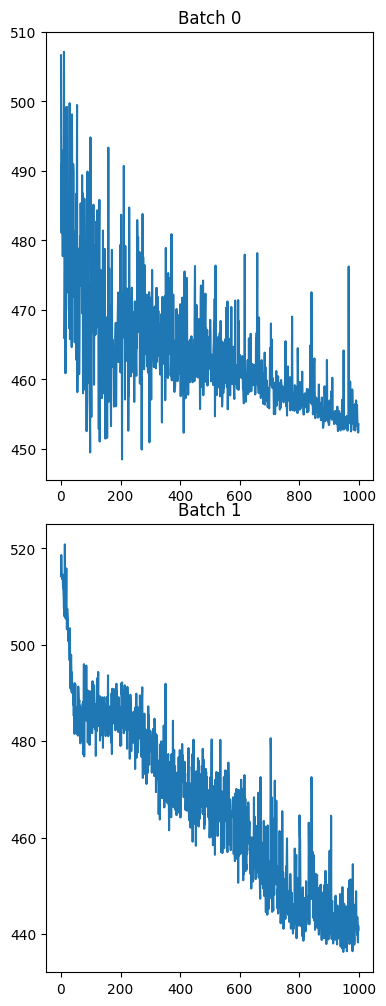

In [10]:
batch_plots(batch_loss_dict)

Done
tensor([[[ 2.8811e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -9.6084e-05,  8.9255e-01],
         [ 7.0489e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           7.1627e-04, -3.0726e-02],
         [ 5.6555e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -1.5004e-03, -2.7539e-04],
         ...,
         [ 5.3164e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           2.0365e-03,  1.2623e-23],
         [ 5.6384e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           6.3901e-04,  3.6359e-24],
         [ 4.9502e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           5.1081e-04,  2.9105e-24]],

        [[ 1.7329e-01,  0.0000e+00,  7.4431e-03,  ..., -1.4771e-05,
           9.7179e-05,  1.3035e-11],
         [ 3.6870e-02,  0.0000e+00, -2.4372e-02,  ...,  4.7765e-05,
          -3.1426e-04, -4.2152e-11],
         [ 6.1733e-02,  0.0000e+00,  9.0002e-01,  ..., -6.3145e-04,
           4.1556e-03,  5.5724e-10],
         ...,
         [ 9.5032e-0

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



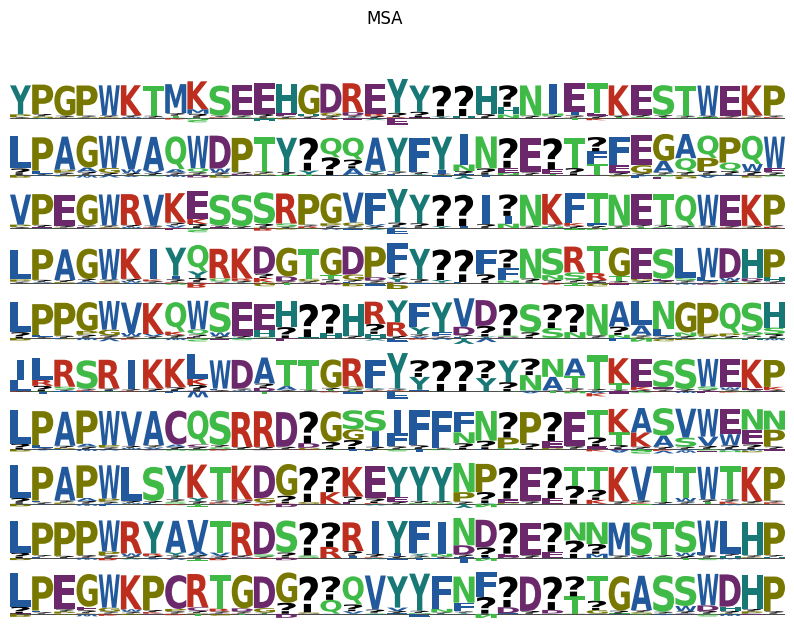

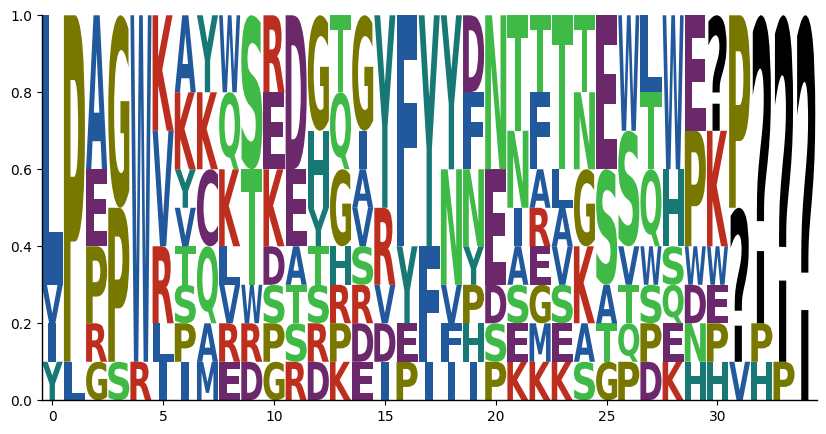

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



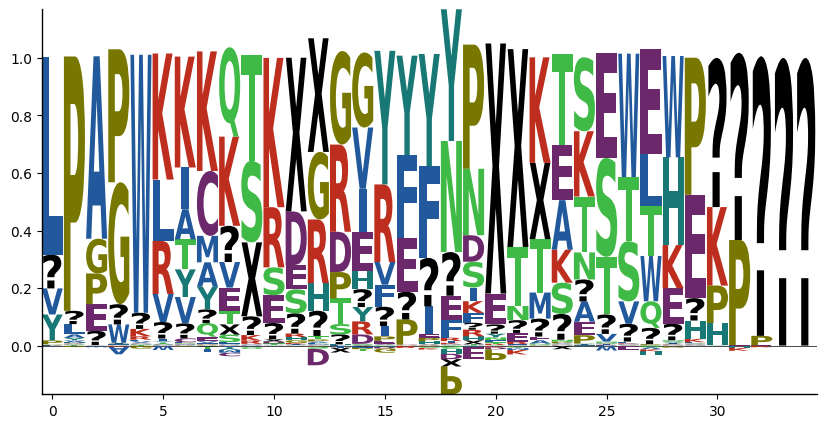

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



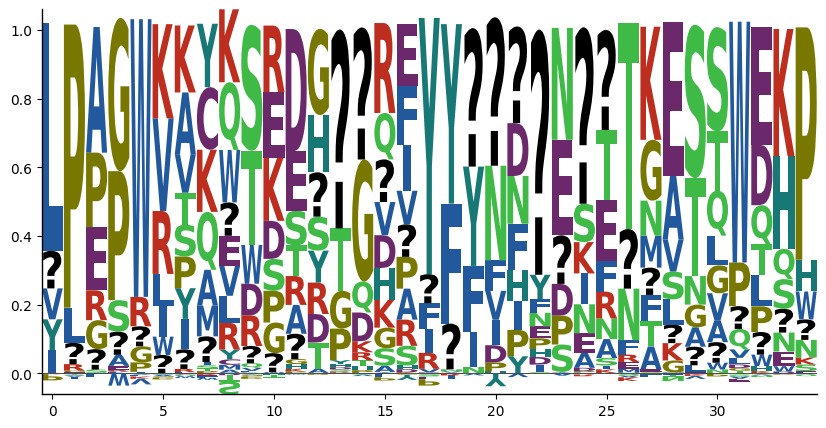

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)



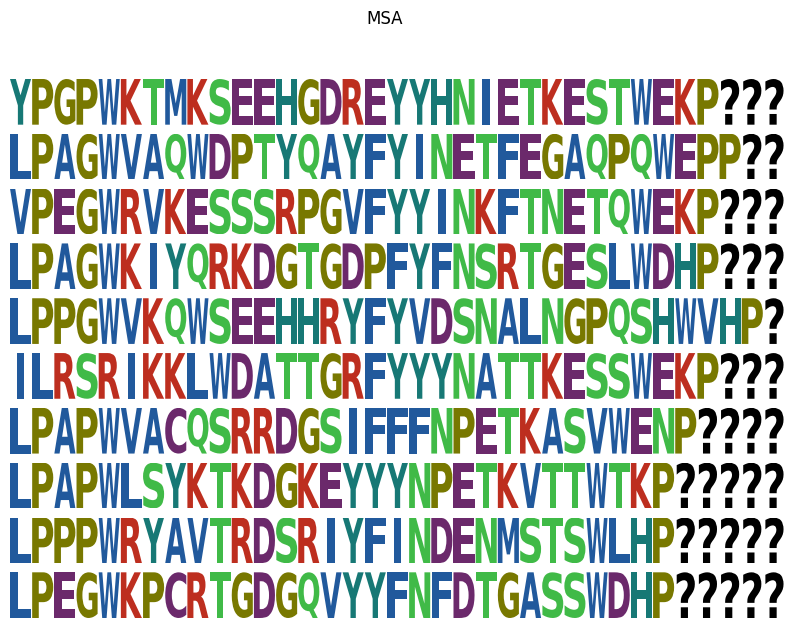

In [12]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):


    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq)
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])
    
    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq.to('cpu'), dataset_msa.prot_space.detach().cpu())



RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

In [ ]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])
    
plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()